# 1: Setup and Data Loading

In [ ]:
# ============================================================
# TreeMap Validation Pipeline - Talladega Experimental Forest
# Section 1: Setup and Data Loading
# ============================================================

# Install required packages
!pip install rasterio -q

# Import libraries
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPoint, shape
import math
import matplotlib.pyplot as plt
import rasterio
from rasterio.mask import mask
from rasterio.features import shapes
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Unzip GeoDatabase
!unzip /content/drive/MyDrive/TalladegaLidarData_Projected_Complete.gdb.zip -d /content/TalladegaLidarData_Projected_Complete/

print("✅ Setup complete")

Mounted at /content/drive
Archive:  /content/drive/MyDrive/TalladegaLidarData_Projected_Complete.gdb.zip
  inflating: /content/TalladegaLidarData_Projected_Complete/TalladegaLidarData_Projected_Complete.gdb/a00000001.freelist  
  inflating: /content/TalladegaLidarData_Projected_Complete/TalladegaLidarData_Projected_Complete.gdb/a00000001.gdbindexes  
  inflating: /content/TalladegaLidarData_Projected_Complete/TalladegaLidarData_Projected_Complete.gdb/a00000001.gdbtable  
  inflating: /content/TalladegaLidarData_Projected_Complete/TalladegaLidarData_Projected_Complete.gdb/a00000001.gdbtablx  
  inflating: /content/TalladegaLidarData_Projected_Complete/TalladegaLidarData_Projected_Complete.gdb/a00000001.TablesByName.atx  
  inflating: /content/TalladegaLidarData_Projected_Complete/TalladegaLidarData_Projected_Complete.gdb/a00000002.gdbtable  
  inflating: /content/TalladegaLidarData_Projected_Complete/TalladegaLidarData_Projected_Complete.gdb/a00000002.gdbtablx  
  inflating: /content/Ta

# 2: Generate Convex Hull Polygons

In [ ]:
# ============================================================
# Section 2: Generate Convex Hull Polygons for Field Plots
# ============================================================

# File paths
gdb_path = "/content/TalladegaLidarData_Projected_Complete/TalladegaLidarData_Projected_Complete.gdb"
csv_path = "/content/drive/MyDrive/TreeDataExport_editTY.csv"
output_path = "/output_polygons.shp"
layer_name = "Talladega_LiDAR_Field_Collection_GPSpts"

# Read data
points_gdf = gpd.read_file(gdb_path, layer=layer_name)
records_df = pd.read_csv(csv_path)

# Clean column names
points_gdf.rename(columns=lambda x: x.strip(), inplace=True)
records_df.rename(columns=lambda x: x.strip(), inplace=True)
records_df["ParentGlobalID"] = records_df["ParentGlobalID *"].astype(str).str.strip()
points_gdf["globalid"] = points_gdf["globalid"].astype(str).str.strip()

# Clean GUID format
def clean_guid(guid):
    if pd.isnull(guid):
        return ""
    return str(guid).replace("{","").replace("}","").strip().lower()

points_gdf["globalid_clean"] = points_gdf["globalid"].apply(clean_guid)
records_df["ParentGlobalID_clean"] = records_df["ParentGlobalID"].apply(clean_guid)

# Convert numeric fields
records_df["Forward azimuth"] = pd.to_numeric(records_df["Forward azimuth"], errors="coerce")
records_df["Tree distance from plot center (ft)"] = pd.to_numeric(
    records_df["Tree distance from plot center (ft)"], errors="coerce"
)

# Coordinate system transformation
original_crs = points_gdf.crs
print(f"Original CRS: {original_crs}")

# Transform to NAD83 Albers (to match TreeMap)
target_crs = "EPSG:5070"
print(f"🎯 Converting to target CRS: {target_crs}")
points_gdf = points_gdf.to_crs(target_crs)
print(f"✅ Converted to {target_crs}")

# Check coordinate system units
crs_unit_name = points_gdf.crs.axis_info[0].unit_name.lower()
is_feet = "foot" in crs_unit_name or "feet" in crs_unit_name
print(f"CRS unit: {crs_unit_name}")

# Function to calculate tree positions
def calculate_point_smart(origin, azimuth_deg, distance_ft, is_feet_crs):
    """
    Calculate tree position from plot center using azimuth and distance

    Parameters:
    - origin: Point geometry of plot center
    - azimuth_deg: Azimuth in degrees
    - distance_ft: Distance in feet
    - is_feet_crs: Boolean indicating if CRS uses feet

    Returns:
    - Point geometry of tree location
    """
    if is_feet_crs:
        dist_final = distance_ft
    else:
        dist_final = distance_ft * 0.3048  # Convert feet to meters

    az_rad = math.radians(azimuth_deg)
    x = origin.x + dist_final * math.sin(az_rad)
    y = origin.y + dist_final * math.cos(az_rad)
    return Point(x, y)

# Generate convex hull polygons
result_data = []
skipped_trees_count = 0

for idx, row in points_gdf.iterrows():
    gid = row["globalid"]
    gid_clean = row["globalid_clean"]
    center = row.geometry

    # Get trees for this plot
    trees = records_df[records_df["ParentGlobalID_clean"] == gid_clean]
    pts = [center]

    # Calculate tree positions
    for _, t in trees.iterrows():
        az = t["Forward azimuth"]
        dist_ft = t["Tree distance from plot center (ft)"]

        if pd.notnull(az) and pd.notnull(dist_ft):
            pts.append(calculate_point_smart(center, az, dist_ft, is_feet))
        else:
            skipped_trees_count += 1

    # Create convex hull
    unique_pts = list(set(pts))
    if len(unique_pts) >= 3:
        convex = MultiPoint(pts).convex_hull
        if convex.geom_type != "Polygon":
            convex = convex.buffer(0.5 if not is_feet else 1.5)
    else:
        # For plots with <3 trees, use buffer
        radius = 3.28 if is_feet else 1.0
        convex = center.buffer(radius)

    # Calculate mean tree distance
    mean_dist_m = trees["Tree distance from plot center (ft)"].mean() * 0.3048 if len(trees) else 0

    result_data.append({
        "globalid": gid,
        "geometry": convex,
        "MeanDist_m": mean_dist_m
    })

print(f"Skipped trees (missing azimuth/distance): {skipped_trees_count}")

# Create GeoDataFrame
result_gdf = gpd.GeoDataFrame(result_data, crs=target_crs)

# Quality check
print(f"\n✅ Final convex hull CRS: {result_gdf.crs}")
print(f"   Mean area: {result_gdf.geometry.area.mean():.2f} m²")
print(f"   Expected: ~404.7 m² (1/10 acre)")

# Save to file
result_gdf.to_file(output_path)
print(f"Convex hull polygons saved: {output_path}")

Original CRS: EPSG:26916
🎯 Converting to target CRS: EPSG:5070
✅ Converted to EPSG:5070
CRS unit: metre
Skipped trees (missing azimuth/distance): 9

✅ Final convex hull CRS: EPSG:5070
   Mean area: 225.60 m²
   Expected: ~404.7 m² (1/10 acre)
Convex hull polygons saved: /output_polygons.shp


# 3: TreeMap Processing and Spatial Overlay

In [ ]:
# ============================================================
# Section 3: TreeMap Raster Processing and Spatial Overlay
# ============================================================

# Set analysis year
year = 2022  # Change to 2022 for 2022 analysis

# ============================
# 3.1 Load convex hull plots
# ============================
plots = gpd.read_file("/output_polygons.shp")
print(f"Original plots CRS: {plots.crs}")

# Reproject to EPSG:5070 if needed
plots_5070 = plots.to_crs("EPSG:5070")
print(f"Reprojected CRS: {plots_5070.crs}")

# Create boundary for clipping TreeMap
boundary = gpd.GeoDataFrame(
    {"geometry": [plots_5070.buffer(500).union_all()]},
    crs="EPSG:5070"
)
boundary_path = f"/content/Talladega_boundary_5070.shp"
boundary.to_file(boundary_path)
print(f"Boundary saved: {boundary_path}")

# ============================
# 3.2 Clip TreeMap raster
# ============================
treemap_path = f"/content/drive/MyDrive/TreeMap{year}.tif"
treemap_clip_path = f"/content/drive/MyDrive/TreeMap{year}_Talladega_clip.tif"

with rasterio.open(treemap_path) as src:
    print(f"TreeMap{year} CRS: {src.crs}")

    # Reproject boundary to match raster CRS
    boundary_proj = boundary.to_crs(src.crs)
    geoms = [boundary_proj.geometry.iloc[0]]

    # Clip raster
    out_img, out_transform = mask(src, geoms, crop=True)
    out_meta = src.meta.copy()

# Update metadata
out_meta.update({
    "height": out_img.shape[1],
    "width": out_img.shape[2],
    "transform": out_transform
})

# Save clipped raster
with rasterio.open(treemap_clip_path, "w", **out_meta) as dest:
    dest.write(out_img)

print(f"Clipped TreeMap{year} saved: {treemap_clip_path}")

# ============================
# 3.3 Polygonize TreeMap raster
# ============================
print("\nPolygonizing clipped TreeMap ...")

with rasterio.open(treemap_clip_path) as src:
    img = src.read(1)
    transform = src.transform
    treemap_crs = src.crs
    nodata = src.nodata

# Clean NoData values
img_fixed = img.astype("int64")
img_fixed[img == nodata] = -1
img_fixed = img_fixed.astype("int32")

# Convert raster to polygons
polygons = (
    {"properties": {"DN": int(v)}, "geometry": shape(s)}
    for s, v in shapes(img_fixed, transform=transform)
    if v != -1
)

treemap_polygons = gpd.GeoDataFrame.from_features(polygons, crs=treemap_crs)
print(f"Initial polygon count: {len(treemap_polygons)}")

# Remove DN = 0 (background)
treemap_polygons = treemap_polygons[treemap_polygons["DN"] > 0]
print(f"After DN>0 filter: {len(treemap_polygons)}")

# Transform to target CRS
target_crs = "EPSG:5070"
print(f"\n🎯 Converting TreeMap polygons to {target_crs}")
treemap_polygons = treemap_polygons.to_crs(target_crs)
print(f"✅ Converted to: {treemap_polygons.crs}")

# Remove sliver polygons (< 1 m²)
treemap_polygons["area"] = treemap_polygons.geometry.area
treemap_polygons = treemap_polygons[treemap_polygons["area"] > 1]
treemap_polygons = treemap_polygons.drop(columns="area")
print(f"After removing slivers: {len(treemap_polygons)}")

# ============================
# 3.4 Fix overrepresentation issue
# ============================
print("\n" + "="*60)
print("🔧 FIXING MULTI-POLYGON OVERREPRESENTATION")
print("="*60)

# Assign unique polygon ID to prevent overrepresentation
treemap_polygons["polygon_id"] = range(len(treemap_polygons))
treemap_polygons["DN_unique"] = (
    treemap_polygons["DN"].astype(str) + "_" +
    treemap_polygons["polygon_id"].astype(str)
)

# Count polygons per DN
dn_poly_counts = treemap_polygons.groupby("DN").size().reset_index(name="polygon_count")
multi_poly_dns = dn_poly_counts[dn_poly_counts["polygon_count"] > 1]

print(f"✅ Created {len(treemap_polygons)} unique polygon IDs")
print(f"   {len(multi_poly_dns)} DNs have multiple polygons (would cause overrepresentation)")
print(f"   Top 5 DNs with most polygons:")
print(multi_poly_dns.sort_values("polygon_count", ascending=False).head())  # 🔧 修复：改为 multi_poly_dns

# ============================
# 3.5 Pre-overlay CRS check
# ============================
print("\n" + "="*60)
print("🔍 PRE-OVERLAY CRS CHECK")
print("="*60)
print(f"Plots CRS:         {plots_5070.crs}")
print(f"TreeMap CRS:       {treemap_polygons.crs}")

if plots_5070.crs == treemap_polygons.crs:
    print("✅ CRS match - Ready for overlay!")
else:
    print("❌ CRS MISMATCH!")
    raise ValueError("CRS mismatch detected")

# ============================
# 3.6 Spatial overlay
# ============================
print("\n🔧 Running spatial overlay with DN_unique...")

intersection_gdf = gpd.overlay(
    plots_5070,
    treemap_polygons,
    how="intersection",
    keep_geom_type=True
)

intersection_gdf["Area"] = intersection_gdf.geometry.area
print(f"Intersection polygon count: {len(intersection_gdf)}")

# ============================
# 3.7 Compute area ratios
# ============================
print("\nComputing area ratios ...")

# Calculate total area per plot
total_area = (
    intersection_gdf.groupby("globalid")["Area"]
    .sum()
    .reset_index()
    .rename(columns={"Area": "convex_area"})
)

# Merge and calculate area ratio
intersection_gdf = intersection_gdf.merge(total_area, on="globalid")
intersection_gdf["area_ratio"] = intersection_gdf["Area"] / intersection_gdf["convex_area"]
intersection_gdf["area_m2"] = intersection_gdf["Area"]

# ============================
# 3.8 Save results
# ============================
print("\nSaving outputs ...")

output_shp = f"/content/drive/MyDrive/intersection_{year}_FIXED.shp"
output_csv = f"/content/drive/MyDrive/final_area_summary_{year}_FIXED.csv"

intersection_gdf.to_file(output_shp)
intersection_gdf.to_csv(output_csv, index=False)

print(f"Saved shapefile: {output_shp}")
print(f"Saved CSV: {output_csv}")

Original plots CRS: EPSG:5070
Reprojected CRS: EPSG:5070
Boundary saved: /content/Talladega_boundary_5070.shp
TreeMap2022 CRS: EPSG:5070
Clipped TreeMap2022 saved: /content/drive/MyDrive/TreeMap2022_Talladega_clip.tif

Polygonizing clipped TreeMap ...


Initial polygon count: 70789
After DN>0 filter: 70789

🎯 Converting TreeMap polygons to EPSG:5070
✅ Converted to: EPSG:5070
After removing slivers: 70789

🔧 FIXING MULTI-POLYGON OVERREPRESENTATION
✅ Created 70789 unique polygon IDs
   624 DNs have multiple polygons (would cause overrepresentation)
   Top 5 DNs with most polygons:
        DN  polygon_count
271  45049           3898
243  39936           2660
514  58731           2580
718  67009           2515
444  54674           2280

🔍 PRE-OVERLAY CRS CHECK
Plots CRS:         EPSG:5070
TreeMap CRS:       EPSG:5070
✅ CRS match - Ready for overlay!

🔧 Running spatial overlay with DN_unique...
Intersection polygon count: 439

Computing area ratios ...

Saving outputs ...


/tmp/ipython-input-537260300.py:178: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  intersection_gdf.to_file(output_shp)
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:733: RuntimeWarning: Normalized/laundered field name: 'convex_area' to 'convex_are'
  ogr_write(


Saved shapefile: /content/drive/MyDrive/intersection_2022_FIXED.shp
Saved CSV: /content/drive/MyDrive/final_area_summary_2022_FIXED.csv


# 4: Quality Control Checks

In [ ]:
print("\n" + "="*60)
print("QUALITY CONTROL CHECKS")
print("="*60)

# ============================
# 4.1 Plot-level QC
# ============================
# Check: Sum of area_ratios per plot should equal 1.0
qc_plot = (
    intersection_gdf.groupby("globalid")["area_ratio"]
    .sum()
    .reset_index()
)
qc_plot["diff_from_1"] = qc_plot["area_ratio"] - 1

print("\n1️⃣ Plot-level QC (sum of area_ratio per plot):")
print(f"   Mean: {qc_plot['diff_from_1'].mean():.6f}")
print(f"   Std:  {qc_plot['diff_from_1'].std():.6f}")
print(f"   Max deviation: {qc_plot['diff_from_1'].abs().max():.6f}")

bad_plots = qc_plot[abs(qc_plot["diff_from_1"]) > 0.01]
if len(bad_plots) > 0:
    print(f"   ⚠️ {len(bad_plots)} plots have area_ratio sum ≠ 1.0")
else:
    print("   ✅ All plots OK - Perfect area conservation")

# ============================
# 4.2 Polygon-level QC
# ============================
# Check: Each unique polygon should contribute ≤ 1.0 total area_ratio
qc_polygon = (
    intersection_gdf.groupby("DN_unique")["area_ratio"]
    .sum()
    .reset_index()
    .rename(columns={"area_ratio": "area_ratio_sum"})
)

overrep_polygons = qc_polygon[qc_polygon["area_ratio_sum"] > 1.0]

print(f"\n2️⃣ Polygon-level QC (DN_unique overrepresentation):")
print(f"   Total unique polygons: {len(qc_polygon)}")
print(f"   Overrepresented polygons: {len(overrep_polygons)}")

if len(overrep_polygons) > 0:
    print(f"   ⚠️ {len(overrep_polygons)} polygon(s) with area_ratio_sum > 1.0")
    print(f"   Max area_ratio_sum: {overrep_polygons['area_ratio_sum'].max():.2f}")

    # Detailed analysis of overrepresented polygon(s)
    print("\n" + "-"*60)
    print("🔍 INVESTIGATING OVERREPRESENTED POLYGON(S)")
    print("-"*60)

    for idx, overrep in overrep_polygons.iterrows():
        problem_dn_unique = overrep["DN_unique"]
        problem_records = intersection_gdf[
            intersection_gdf["DN_unique"] == problem_dn_unique
        ]

        print(f"\nDN_unique: {problem_dn_unique}")
        print(f"  Total area_ratio: {overrep['area_ratio_sum']:.3f}")
        print(f"  Overlaps with {len(problem_records)} plots:")

        for _, record in problem_records.iterrows():
            print(f"    • Plot {record['globalid'][:25]}...")
            print(f"      Area ratio: {record['area_ratio']:.4f}")
            print(f"      Intersection: {record['Area']:.2f} m²")
else:
    print("   ✅ NO overrepresentation - PERFECT!")

# ============================
# 4.3 Original DN comparison
# ============================
qc_dn_original = (
    intersection_gdf.groupby("DN")["area_ratio"]
    .sum()
    .reset_index()
    .rename(columns={"area_ratio": "area_ratio_sum"})
)

overrep_dn = qc_dn_original[qc_dn_original["area_ratio_sum"] > 1.0]

print(f"\n3️⃣ Original DN-level check (before DN_unique fix):")
print(f"   Overrepresented DNs: {len(overrep_dn)}")
if len(overrep_dn) > 0:
    print(f"   Max area_ratio_sum: {overrep_dn['area_ratio_sum'].max():.2f}")
    print(f"   (Expected due to multi-polygon fragmentation)")


QUALITY CONTROL CHECKS

1️⃣ Plot-level QC (sum of area_ratio per plot):
   Mean: -0.000000
   Std:  0.000000
   Max deviation: 0.000000
   ✅ All plots OK - Perfect area conservation

2️⃣ Polygon-level QC (DN_unique overrepresentation):
   Total unique polygons: 437
   Overrepresented polygons: 2
   ⚠️ 2 polygon(s) with area_ratio_sum > 1.0
   Max area_ratio_sum: 2.00

------------------------------------------------------------
🔍 INVESTIGATING OVERREPRESENTED POLYGON(S)
------------------------------------------------------------

DN_unique: 45049_16988
  Total area_ratio: 1.788
  Overlaps with 2 plots:
    • Plot {DBA99436-A4AD-4A0E-9917-...
      Area ratio: 0.7878
      Intersection: 181.70 m²
    • Plot {8175A02E-8436-4965-B6F4-...
      Area ratio: 1.0000
      Intersection: 184.14 m²

DN_unique: 63927_11807
  Total area_ratio: 2.000
  Overlaps with 2 plots:
    • Plot {C18673A3-EE5B-4A4A-83B9-...
      Area ratio: 1.0000
      Intersection: 259.08 m²
    • Plot {EAF068D5-E9DC-47


### TreeMap Polygons Intersecting Field Plots:
<pre>
├─ Total unique polygons:        437
├─ Well-behaved polygons:        435 (99.5%)
├─ Overrepresented polygons:     2 (0.5%)
└─ Maximum area_ratio_sum:       2.00
</pre>



In [ ]:
# ============================================================
# 4.4 Investigate 4-DN Plots
# ============================================================
print("\n" + "="*60)
print("🔍 INVESTIGATING 4-DN PLOTS")
print("="*60)

df = pd.read_csv(f"/content/drive/MyDrive/final_area_summary_{year}_FIXED.csv")

# Count DN per plot
dn_per_plot = df.groupby("globalid")["DN"].nunique()

print(f"\n📊 DN count distribution:")
print(dn_per_plot.value_counts().sort_index())

# Find 4-DN plots
four_dn_plots = dn_per_plot[dn_per_plot == 4].index

print(f"\n🎯 4-DN plots: {len(four_dn_plots)} plots ({len(four_dn_plots)/len(dn_per_plot)*100:.1f}%)")

if len(four_dn_plots) > 0:
    # Detailed analysis
    print(f"\n" + "-"*60)
    print("📍 Detailed analysis of 4-DN plots (first 5):")
    print("-"*60)

    for i, plot_id in enumerate(four_dn_plots[:5], 1):
        plot_data = df[df["globalid"] == plot_id].sort_values("area_ratio", ascending=False)

        print(f"\n[{i}] Plot: {plot_id[:35]}...")
        print(f"    Convex hull area: {plot_data['convex_area'].iloc[0]:.2f} m²")
        print(f"    Mean tree distance: {plot_data['MeanDist_m'].iloc[0]:.2f} m")
        print(f"\n    DN breakdown:")

        for _, row in plot_data.iterrows():
            print(f"      DN {int(row['DN']):6d}: {row['area_ratio']*100:5.1f}% | {row['Area']:6.2f} m²")

        # Classification
        max_ratio = plot_data['area_ratio'].max()
        if max_ratio < 0.5:
            print(f"    ⚠️  Highly fragmented (max DN = {max_ratio*100:.1f}%)")
        else:
            print(f"    ✅ Has dominant DN + small fragments")

    # Comparison statistics
    print(f"\n" + "="*60)
    print("📈 COMPARISON: 4-DN vs Other Plots")
    print("="*60)

    df_with_count = df.merge(
        dn_per_plot.to_frame('dn_count'),
        left_on='globalid',
        right_index=True
    )

    four_dn_summary = df_with_count[df_with_count['dn_count'] == 4].groupby('globalid').agg({
        'convex_area': 'first',
        'MeanDist_m': 'first',
        'area_ratio': 'count'
    })

    other_summary = df_with_count[df_with_count['dn_count'] < 4].groupby('globalid').agg({
        'convex_area': 'first',
        'MeanDist_m': 'first',
        'area_ratio': 'count'
    })

    print(f"\n4-DN plots (n={len(four_dn_plots)}):")
    print(f"  Mean convex hull area: {four_dn_summary['convex_area'].mean():.2f} m²")
    print(f"  Mean tree distance: {four_dn_summary['MeanDist_m'].mean():.2f} m")
    print(f"  Mean polygons/plot: {four_dn_summary['area_ratio'].mean():.1f}")

    print(f"\nOther plots (n={len(dn_per_plot) - len(four_dn_plots)}):")
    print(f"  Mean convex hull area: {other_summary['convex_area'].mean():.2f} m²")
    print(f"  Mean tree distance: {other_summary['MeanDist_m'].mean():.2f} m")
    print(f"  Mean polygons/plot: {other_summary['area_ratio'].mean():.1f}")

    # Size analysis
    plot_areas = df.groupby("globalid")["convex_area"].first()
    large_4dn_plots = dn_per_plot[
        (dn_per_plot == 4) &
        (plot_areas > 300)
    ].index

    print(f"\n🔍 Size analysis:")
    print(f"  4-DN plots > 300 m²: {len(large_4dn_plots)} of {len(four_dn_plots)}")
    print(f"  → These may be edge plots spanning multiple forest types")


🔍 INVESTIGATING 4-DN PLOTS

📊 DN count distribution:
DN
1    104
2    103
3     33
4      5
Name: count, dtype: int64

🎯 4-DN plots: 5 plots (2.0%)

------------------------------------------------------------
📍 Detailed analysis of 4-DN plots (first 5):
------------------------------------------------------------

[1] Plot: {2D6B6E44-2B6C-4EF7-9E0E-382F872B1F...
    Convex hull area: 299.31 m²
    Mean tree distance: 7.25 m

    DN breakdown:
      DN  59143:  62.2% | 186.09 m²
      DN  24294:  35.5% | 106.22 m²
      DN  60206:   2.2% |   6.71 m²
      DN  39993:   0.1% |   0.30 m²
    ✅ Has dominant DN + small fragments

[2] Plot: {4788FE49-CE82-459D-BFBA-7304474AEB...
    Convex hull area: 118.88 m²
    Mean tree distance: 5.71 m

    DN breakdown:
      DN  66323:  45.7% |  54.33 m²
      DN  35573:  41.9% |  49.86 m²
      DN  13107:   9.3% |  11.09 m²
      DN  39936:   3.0% |   3.60 m²
    ⚠️  Highly fragmented (max DN = 45.7%)

[3] Plot: {5C5D0847-7DD2-47E1-83ED-A42A85C412..


🔧 APPLYING REFINED FILTERING STRATEGY

STRATEGY: Remove only unusually large 4-DN plots (>300 m²)
RATIONALE:
  • Large plots (>300 m² = 74% of theoretical area) likely span
    multiple distinct forest types at plot boundaries
  • Normal-sized 4-DN plots (≤300 m²) may represent genuine
    forest heterogeneity (ecotones, mixed stands, forest gaps)
  • This minimizes data loss while removing problematic edge cases


📊 Filtering results:
   Total plots: 245
   4-DN plots (large, >300m²): 1 → REMOVED
   4-DN plots (normal, ≤300m²): 4 → KEPT
   1-3 DN plots: 240 → KEPT

🗑️  Removed plots (large 4-DN):
   - {92CF8A4F-B668-419F-B2D8-AA369A951C87}... (347.0 m²)

✅ Kept plots (normal-sized 4-DN):
   - {2D6B6E44-2B6C-4EF7-9E0E-382F872B1F4A}... (299.3 m²)
   - {4788FE49-CE82-459D-BFBA-7304474AEB43}... (118.9 m²)
   - {5C5D0847-7DD2-47E1-83ED-A42A85C4126D}... (212.0 m²)
   - {9A111C55-B4AD-4B8E-82DA-702C194ACD21}... (260.2 m²)

   These 4-DN plots are within normal size range and may
   represen

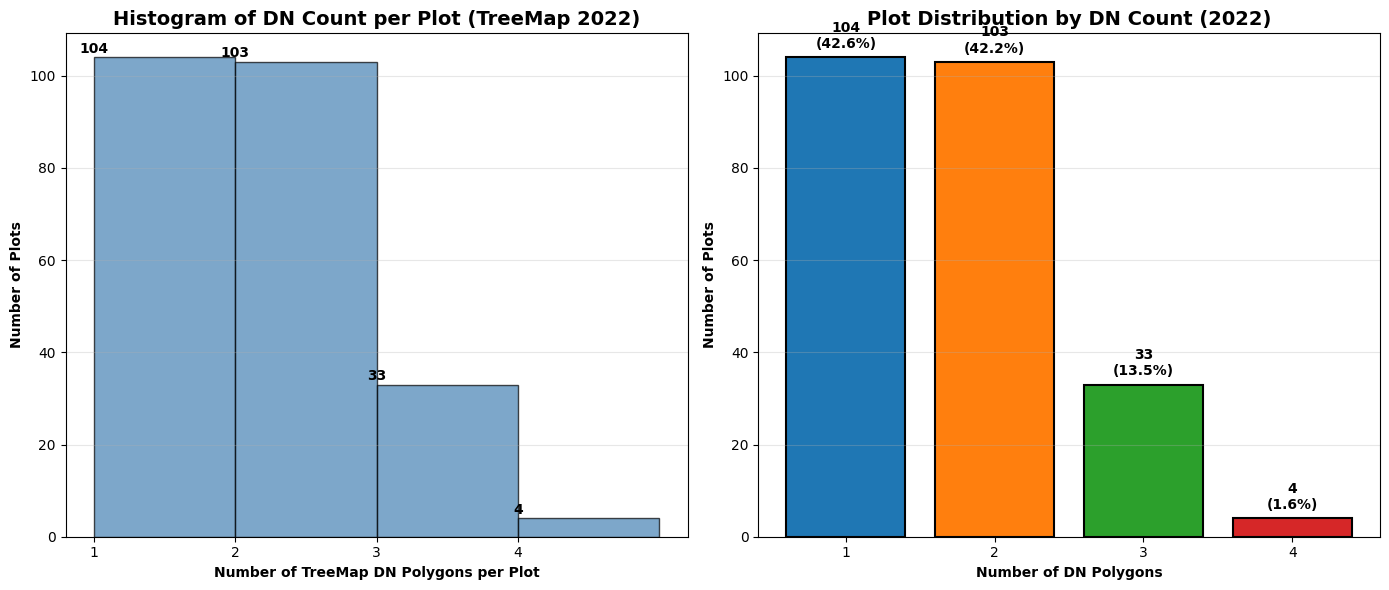

In [ ]:
# ============================================================
# 4.5 Apply Refined Filtering Strategy
# ============================================================
print("\n" + "="*60)
print("🔧 APPLYING REFINED FILTERING STRATEGY")
print("="*60)

print("""
STRATEGY: Remove only unusually large 4-DN plots (>300 m²)
RATIONALE:
  • Large plots (>300 m² = 74% of theoretical area) likely span
    multiple distinct forest types at plot boundaries
  • Normal-sized 4-DN plots (≤300 m²) may represent genuine
    forest heterogeneity (ecotones, mixed stands, forest gaps)
  • This minimizes data loss while removing problematic edge cases
""")

# Calculate plot areas
plot_areas = df.groupby("globalid")["convex_area"].first()

# Identify large 4-DN plots to remove
large_4dn_plots = dn_per_plot[
    (dn_per_plot == 4) &
    (plot_areas > 300)
].index

# Identify normal-sized 4-DN plots to keep
normal_4dn_plots = dn_per_plot[
    (dn_per_plot == 4) &
    (plot_areas <= 300)
].index

print(f"\n📊 Filtering results:")
print(f"   Total plots: {len(dn_per_plot)}")
print(f"   4-DN plots (large, >300m²): {len(large_4dn_plots)} → REMOVED")
print(f"   4-DN plots (normal, ≤300m²): {len(normal_4dn_plots)} → KEPT")
print(f"   1-3 DN plots: {len(dn_per_plot[dn_per_plot < 4])} → KEPT")

if len(large_4dn_plots) > 0:
    print(f"\n🗑️  Removed plots (large 4-DN):")
    for plot_id in large_4dn_plots:
        area = plot_areas[plot_id]
        print(f"   - {plot_id[:40]}... ({area:.1f} m²)")

if len(normal_4dn_plots) > 0:
    print(f"\n✅ Kept plots (normal-sized 4-DN):")
    for plot_id in normal_4dn_plots:
        area = plot_areas[plot_id]
        print(f"   - {plot_id[:40]}... ({area:.1f} m²)")

    print(f"\n   These 4-DN plots are within normal size range and may")
    print(f"   represent genuine forest heterogeneity (e.g., ecotones)")

# Apply filtering: keep 1-3 DN plots + normal-sized 4-DN plots
plots_to_keep = dn_per_plot[
    (dn_per_plot < 4) |
    ((dn_per_plot == 4) & (plot_areas <= 300))
].index

df_filtered = df[df["globalid"].isin(plots_to_keep)].copy()

print(f"\n📈 Final dataset:")
print(f"   Plots removed: {len(dn_per_plot) - len(plots_to_keep)} ({(len(dn_per_plot) - len(plots_to_keep))/len(dn_per_plot)*100:.1f}%)")
print(f"   Plots retained: {len(plots_to_keep)} ({len(plots_to_keep)/len(dn_per_plot)*100:.1f}%)")

# Re-normalize area_ratio after filtering
df_filtered["area_ratio"] = df_filtered.groupby("globalid")["area_ratio"].transform(
    lambda x: x / x.sum()
)

# Save final version
output_final = f"/content/drive/MyDrive/final_area_summary_{year}_FINAL.csv"
df_filtered.to_csv(output_final, index=False)
print(f"\n✅ Final data saved to: {output_final}")

# Final validation
qc_final = df_filtered.groupby("globalid")["area_ratio"].sum()
print(f"\n🔍 Final QC - area_ratio sum per plot:")
print(f"   Mean: {qc_final.mean():.6f}")
print(f"   Std:  {qc_final.std():.6f}")
print(f"   Min:  {qc_final.min():.6f}")
print(f"   Max:  {qc_final.max():.6f}")

if abs(qc_final.mean() - 1.0) < 0.000001 and qc_final.std() < 0.000001:
    print(f"   ✅ PERFECT - All plots maintain area conservation")

print("\n" + "="*60)
print("✅ REFINED FILTERING COMPLETE")
print("="*60)

# ============================================================
# 4.6 Final Summary Statistics
# ============================================================
print("\n" + "="*60)
print("📊 FINAL DATASET SUMMARY")
print("="*60)

final_dn_per_plot = df_filtered.groupby("globalid")["DN"].nunique()

print(f"\nPlot-DN distribution (after filtering):")
dn_counts = final_dn_per_plot.value_counts().sort_index()
for dn_count, num_plots in dn_counts.items():
    percentage = (num_plots / len(final_dn_per_plot)) * 100
    print(f"   {dn_count} DN(s):  {num_plots:3d} plots ({percentage:5.1f}%)")

print(f"\nStatistics:")
print(f"   Total plots: {len(final_dn_per_plot)}")
print(f"   Mean DNs per plot: {final_dn_per_plot.mean():.2f}")
print(f"   Median DNs per plot: {final_dn_per_plot.median():.0f}")
print(f"   Total unique DN values: {df_filtered['DN'].nunique()}")
print(f"   Total polygons: {len(df_filtered)}")
print(f"   Mean polygons per plot: {len(df_filtered) / len(final_dn_per_plot):.2f}")

# ============================================================
# 4.7 Visualization
# ============================================================
print("\n" + "="*60)
print("📈 GENERATING VISUALIZATIONS")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Histogram
axes[0].hist(final_dn_per_plot, bins=range(1, final_dn_per_plot.max()+2),
             edgecolor="black", color="steelblue", alpha=0.7)
axes[0].set_xlabel("Number of TreeMap DN Polygons per Plot", fontweight="bold")
axes[0].set_ylabel("Number of Plots", fontweight="bold")
axes[0].set_title(f"Histogram of DN Count per Plot (TreeMap {year})",
                  fontsize=14, fontweight="bold")
axes[0].grid(alpha=0.3, axis='y')
axes[0].set_xticks(range(1, final_dn_per_plot.max()+1))

# Add counts on top of bars
for i in range(1, final_dn_per_plot.max()+1):
    count = (final_dn_per_plot == i).sum()
    if count > 0:
        axes[0].text(i, count + 1, str(count), ha='center',
                    fontweight='bold', fontsize=10)

# Subplot 2: Bar chart with percentages
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(dn_counts)]

bars = axes[1].bar(dn_counts.index, dn_counts.values,
                   color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_xlabel("Number of DN Polygons", fontweight="bold")
axes[1].set_ylabel("Number of Plots", fontweight="bold")
axes[1].set_title(f"Plot Distribution by DN Count ({year})",
                  fontsize=14, fontweight="bold")
axes[1].set_xticks(dn_counts.index)
axes[1].grid(alpha=0.3, axis='y')

# Add percentage labels
for dn, count in dn_counts.items():
    percentage = (count / len(final_dn_per_plot)) * 100
    axes[1].text(dn, count + 2, f'{count}\n({percentage:.1f}%)',
                ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()


# 5: Attribute Comparison - Diameter and Height

DIAMETER AND HEIGHT COMPARISON

1️⃣ Preparing TreeMap data...
   Using TreeMap ID column: TM_ID


/tmp/ipython-input-3221390771.py:58: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  treemap_treetable["DIA"].fillna(treemap_treetable["DIA"].mean(), inplace=True)
/tmp/ipython-input-3221390771.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].meth

   ✅ TreeMap: 65043 polygons with mean DIA/HT

2️⃣ Computing area-weighted TreeMap attributes...
   ✅ Computed weighted attributes for 244 plots

3️⃣ Preparing field data...
   ✅ Field: 253 plots with mean DIA/HT

4️⃣ Comparing TreeMap vs Field...
   ✅ Matched 241 plots for comparison

VALIDATION METRICS

📏 Diameter Metrics:
   RMSE  = 4.070 inches
   MAE   = 3.265 inches
   R²    = -1.316
   Bias  = -2.824 inches
   %RMSE = 38.8%

📏 Height Metrics:
   RMSE  = 17.454 feet
   MAE   = 13.693 feet
   R²    = -0.795
   Bias  = -7.874 feet
   %RMSE = 29.2%

5️⃣ Creating visualizations...


/tmp/ipython-input-3221390771.py:119: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  talladega_treetable["Tree diameter (inches)"].fillna(
/tmp/ipython-input-3221390771.py:122: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

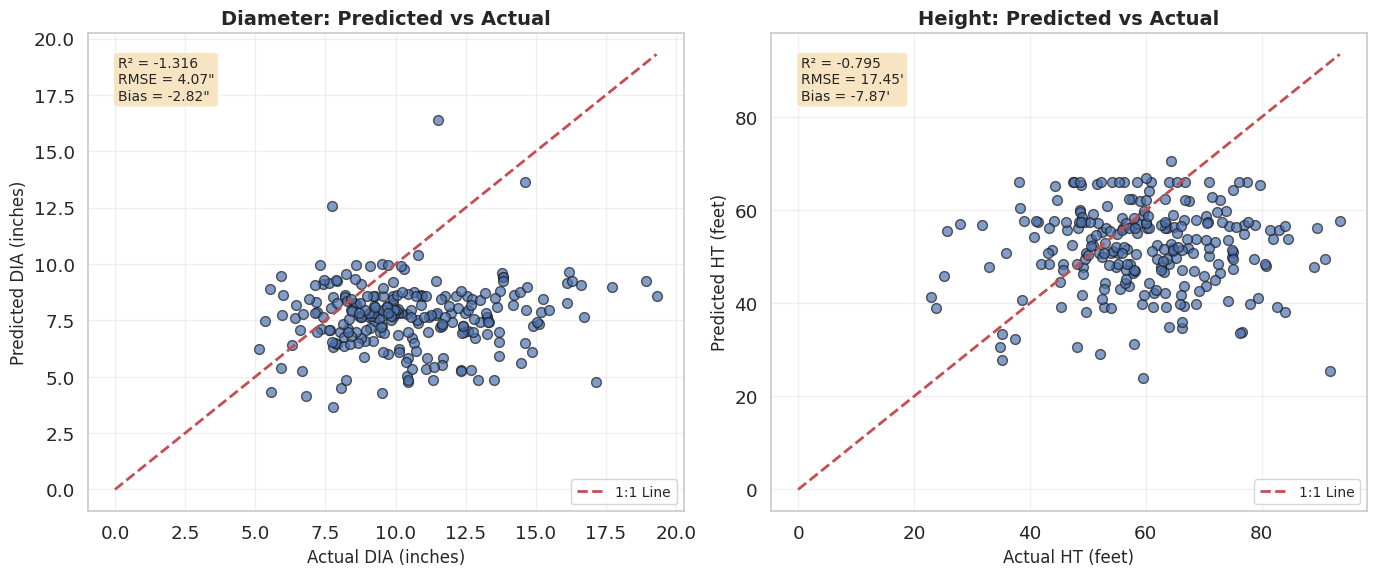

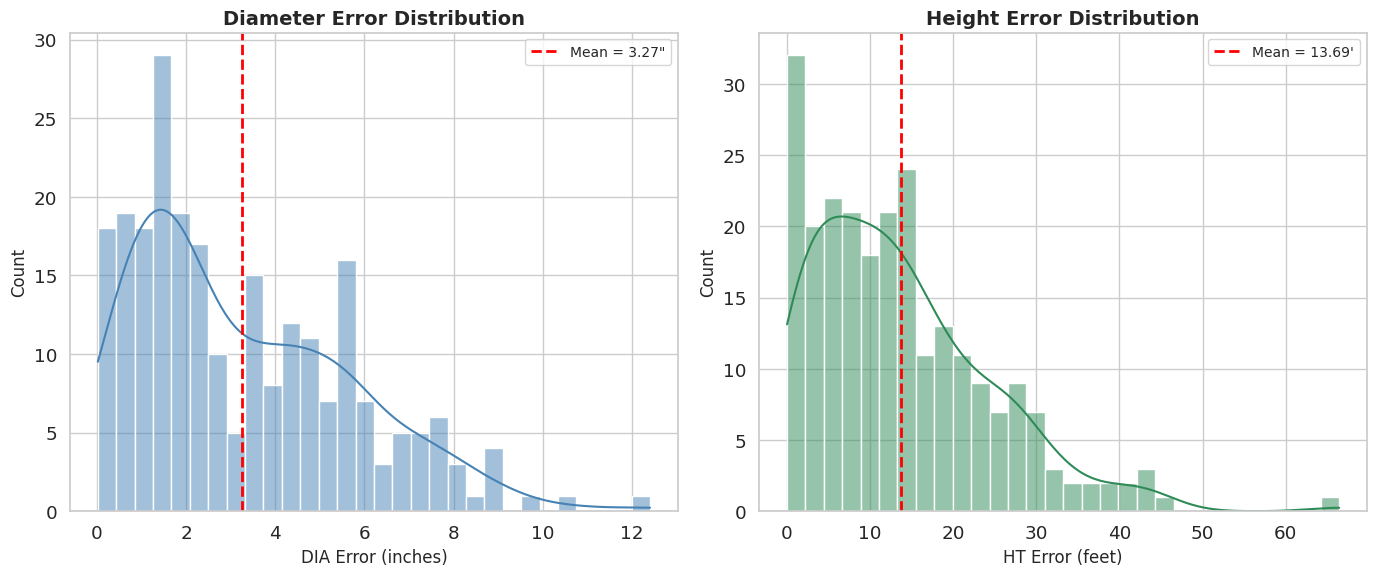

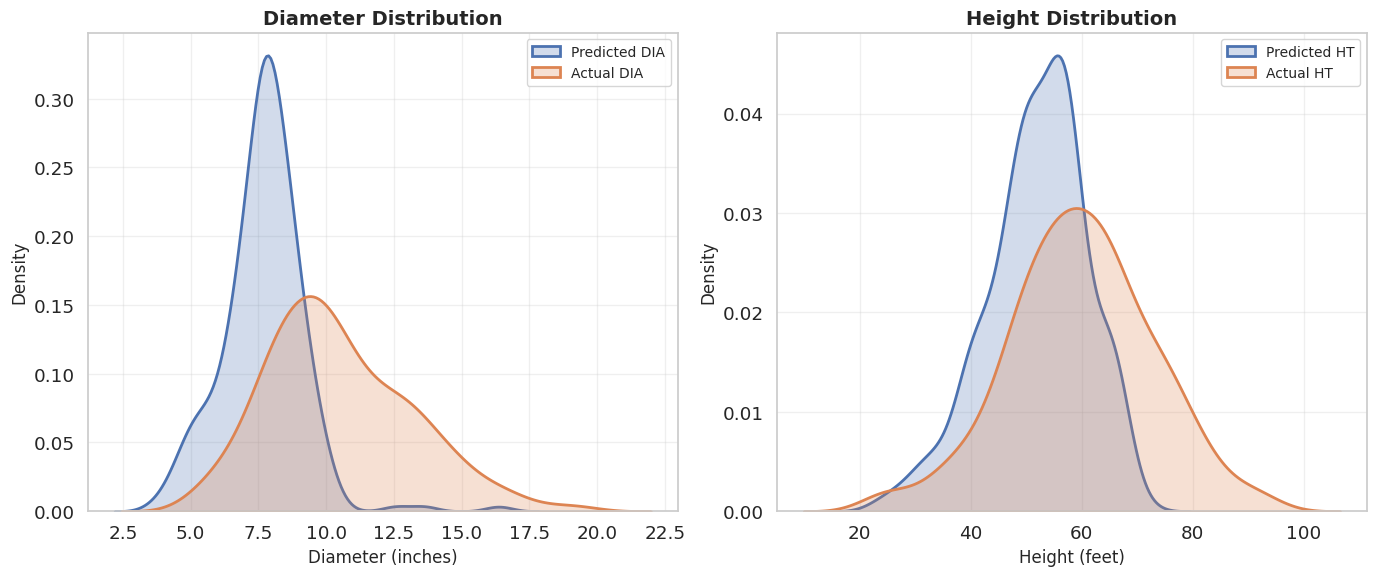

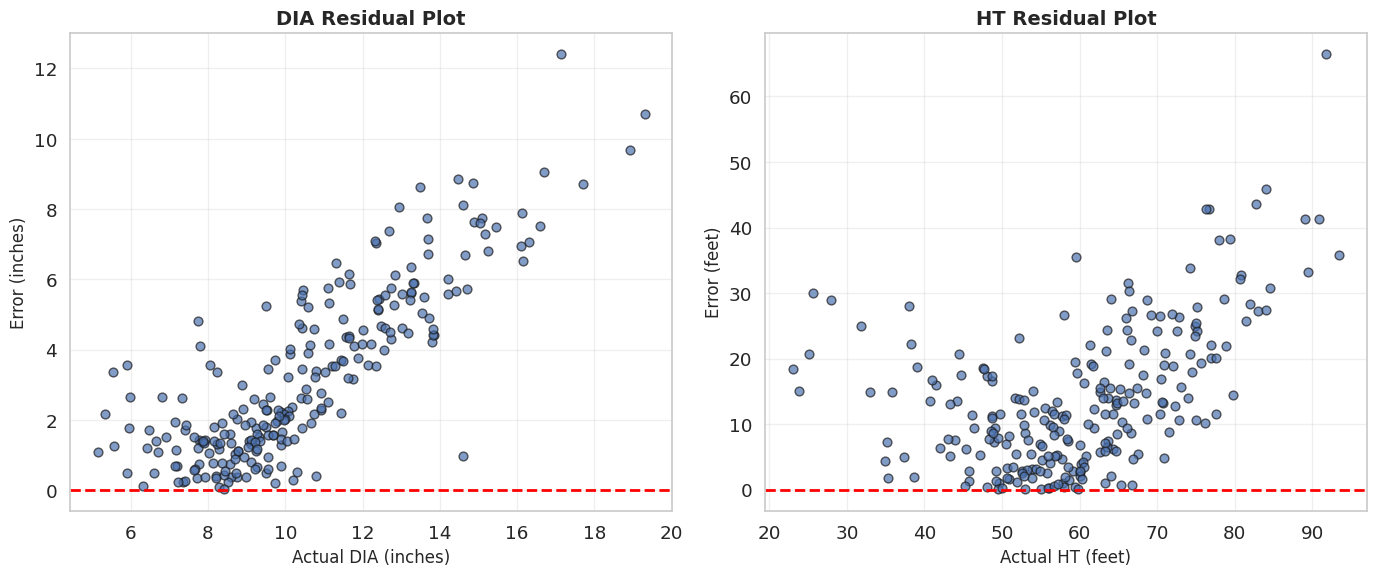


✅ All figures saved with 'Fig' prefix for easy identification
✅ Comparison results saved: /content/drive/MyDrive/diameter_height_comparison_2022.csv

✅ DIAMETER AND HEIGHT COMPARISON COMPLETE


In [ ]:
# ============================================================
# Section 5: Diameter and Height Comparison - FINAL VERSION
# ============================================================

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# Set visualization style
sns.set(style="whitegrid", font_scale=1.2)

# Base directory
base_dir = "/content/drive/MyDrive"

# File paths
treemap_treetable_path = f"{base_dir}/TreeMap{year}_tree_table.csv"
talladega_treetable_path = f"{base_dir}/TreeDataExport_editTY.csv"
final_export_path = f"{base_dir}/final_area_summary_{year}_FINAL.csv"

# Load data
treemap_treetable = pd.read_csv(treemap_treetable_path)
talladega_treetable = pd.read_csv(talladega_treetable_path)
final_export_data = pd.read_csv(final_export_path)

print("="*60)
print("DIAMETER AND HEIGHT COMPARISON")
print("="*60)

# ============================
# 5.1 TreeMap data preparation
# ============================
print("\n1️⃣ Preparing TreeMap data...")

# Detect TreeMap ID column
tm_id_col = None
for c in ["tm_id", "TM_ID", "Tm_ID", "TMID", "TmID"]:
    if c in treemap_treetable.columns:
        tm_id_col = c
        break
if tm_id_col is None:
    raise KeyError("❌ TreeMap ID column not found")

print(f"   Using TreeMap ID column: {tm_id_col}")

# Convert to numeric
treemap_treetable["DIA"] = pd.to_numeric(treemap_treetable["DIA"], errors="coerce")
treemap_treetable["HT"] = pd.to_numeric(treemap_treetable["HT"], errors="coerce")

# Fill missing values
treemap_treetable["DIA"] = treemap_treetable.groupby(tm_id_col)["DIA"].transform(
    lambda x: x.fillna(x.mean())
)
treemap_treetable["HT"] = treemap_treetable.groupby(tm_id_col)["HT"].transform(
    lambda x: x.fillna(x.mean())
)
treemap_treetable["DIA"].fillna(treemap_treetable["DIA"].mean(), inplace=True)
treemap_treetable["HT"].fillna(treemap_treetable["HT"].mean(), inplace=True)

# Filter valid trees
treemap_filtered = treemap_treetable[
    (treemap_treetable["DIA"] > 0) & (treemap_treetable["HT"] > 0)
]

# Calculate mean per TreeMap polygon
treemap_mean = (
    treemap_filtered.groupby(tm_id_col)[["DIA", "HT"]]
    .mean()
    .reset_index()
)

print(f"   ✅ TreeMap: {len(treemap_mean)} polygons with mean DIA/HT")

# ============================
# 5.2 Weighted aggregation
# ============================
print("\n2️⃣ Computing area-weighted TreeMap attributes...")

weighted_attributes = final_export_data.merge(
    treemap_mean, left_on="DN", right_on=tm_id_col, how="left"
)

weighted_attributes["weighted_DIA"] = (
    weighted_attributes["DIA"] * weighted_attributes["area_ratio"]
)
weighted_attributes["weighted_HT"] = (
    weighted_attributes["HT"] * weighted_attributes["area_ratio"]
)

globalid_weighted = (
    weighted_attributes.groupby("globalid")[["weighted_DIA", "weighted_HT"]]
    .sum()
    .reset_index()
)

print(f"   ✅ Computed weighted attributes for {len(globalid_weighted)} plots")

# ============================
# 5.3 Field data preparation
# ============================
print("\n3️⃣ Preparing field data...")

talladega_treetable["Tree diameter (inches)"] = pd.to_numeric(
    talladega_treetable["Tree diameter (inches)"], errors="coerce"
)
talladega_treetable["Tree height (feet)"] = pd.to_numeric(
    talladega_treetable["Tree height (feet)"], errors="coerce"
)

talladega_treetable["Tree diameter (inches)"] = talladega_treetable.groupby(
    "ParentGlobalID *"
)["Tree diameter (inches)"].transform(lambda x: x.fillna(x.mean()))

talladega_treetable["Tree height (feet)"] = talladega_treetable.groupby(
    "ParentGlobalID *"
)["Tree height (feet)"].transform(lambda x: x.fillna(x.mean()))

talladega_treetable["Tree diameter (inches)"].fillna(
    talladega_treetable["Tree diameter (inches)"].mean(), inplace=True
)
talladega_treetable["Tree height (feet)"].fillna(
    talladega_treetable["Tree height (feet)"].mean(), inplace=True
)

talladega_filtered = talladega_treetable[
    talladega_treetable["Tree diameter (inches)"] >= 5
]

talladega_mean = talladega_filtered.groupby("ParentGlobalID *")[
    ["Tree diameter (inches)", "Tree height (feet)"]
].mean().reset_index()

print(f"   ✅ Field: {len(talladega_mean)} plots with mean DIA/HT")

# ============================
# 5.4 Merge and compute errors
# ============================
print("\n4️⃣ Comparing TreeMap vs Field...")

comparison = globalid_weighted.merge(
    talladega_mean,
    left_on="globalid",
    right_on="ParentGlobalID *",
    how="inner"
)

comparison["DIA_error"] = abs(
    comparison["weighted_DIA"] - comparison["Tree diameter (inches)"]
)
comparison["HT_error"] = abs(
    comparison["weighted_HT"] - comparison["Tree height (feet)"]
)

print(f"   ✅ Matched {len(comparison)} plots for comparison")

# ============================
# 5.5 Compute validation metrics
# ============================
print("\n" + "="*60)
print("VALIDATION METRICS")
print("="*60)

# Diameter
mse_dia = mean_squared_error(
    comparison["Tree diameter (inches)"], comparison["weighted_DIA"]
)
rmse_dia = np.sqrt(mse_dia)
mae_dia = mean_absolute_error(
    comparison["Tree diameter (inches)"], comparison["weighted_DIA"]
)
r2_dia = r2_score(
    comparison["Tree diameter (inches)"], comparison["weighted_DIA"]
)
bias_dia = (comparison["weighted_DIA"] - comparison["Tree diameter (inches)"]).mean()

print(f"\n📏 Diameter Metrics:")
print(f"   RMSE  = {rmse_dia:.3f} inches")
print(f"   MAE   = {mae_dia:.3f} inches")
print(f"   R²    = {r2_dia:.3f}")
print(f"   Bias  = {bias_dia:.3f} inches")
print(f"   %RMSE = {(rmse_dia / comparison['Tree diameter (inches)'].mean()) * 100:.1f}%")

# Height
mse_ht = mean_squared_error(
    comparison["Tree height (feet)"], comparison["weighted_HT"]
)
rmse_ht = np.sqrt(mse_ht)
mae_ht = mean_absolute_error(
    comparison["Tree height (feet)"], comparison["weighted_HT"]
)
r2_ht = r2_score(
    comparison["Tree height (feet)"], comparison["weighted_HT"]
)
bias_ht = (comparison["weighted_HT"] - comparison["Tree height (feet)"]).mean()

print(f"\n📏 Height Metrics:")
print(f"   RMSE  = {rmse_ht:.3f} feet")
print(f"   MAE   = {mae_ht:.3f} feet")
print(f"   R²    = {r2_ht:.3f}")
print(f"   Bias  = {bias_ht:.3f} feet")
print(f"   %RMSE = {(rmse_ht / comparison['Tree height (feet)'].mean()) * 100:.1f}%")

# ============================
# 5.6 Visualization
# ============================
print("\n5️⃣ Creating visualizations...")

# --------------------------------------
# Figure 1: Scatter plots (你的风格 + 我的标注)
# --------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Diameter
axes[0].scatter(
    comparison["Tree diameter (inches)"],
    comparison["weighted_DIA"],
    alpha=0.7,
    edgecolor="k",
    s=50
)
max_dia = max(
    comparison["Tree diameter (inches)"].max(),
    comparison["weighted_DIA"].max()
)
axes[0].plot([0, max_dia], [0, max_dia], "r--", linewidth=2, label="1:1 Line")
axes[0].set_title("Diameter: Predicted vs Actual", fontweight="bold", fontsize=14)
axes[0].set_xlabel("Actual DIA (inches)", fontsize=12)
axes[0].set_ylabel("Predicted DIA (inches)", fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Add metrics box
axes[0].text(
    0.05, 0.95,
    f'R² = {r2_dia:.3f}\nRMSE = {rmse_dia:.2f}"\nBias = {bias_dia:.2f}"',
    transform=axes[0].transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
    fontsize=10
)

# Height
axes[1].scatter(
    comparison["Tree height (feet)"],
    comparison["weighted_HT"],
    alpha=0.7,
    edgecolor="k",
    s=50
)
max_ht = max(
    comparison["Tree height (feet)"].max(),
    comparison["weighted_HT"].max()
)
axes[1].plot([0, max_ht], [0, max_ht], "r--", linewidth=2, label="1:1 Line")
axes[1].set_title("Height: Predicted vs Actual", fontweight="bold", fontsize=14)
axes[1].set_xlabel("Actual HT (feet)", fontsize=12)
axes[1].set_ylabel("Predicted HT (feet)", fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

# Add metrics box
axes[1].text(
    0.05, 0.95,
    f'R² = {r2_ht:.3f}\nRMSE = {rmse_ht:.2f}\'\nBias = {bias_ht:.2f}\'',
    transform=axes[1].transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
    fontsize=10
)

plt.tight_layout()
plt.savefig(f"{base_dir}/Fig1_diameter_height_scatter_{year}.png", dpi=300, bbox_inches="tight")
plt.show()

# --------------------------------------
# Figure 2: Error distributions
# --------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(
    comparison["DIA_error"],
    bins=30,
    kde=True,
    ax=axes[0],
    color="steelblue"
)
axes[0].set_title("Diameter Error Distribution", fontweight="bold", fontsize=14)
axes[0].set_xlabel("DIA Error (inches)", fontsize=12)
axes[0].set_ylabel("Count", fontsize=12)
axes[0].axvline(
    comparison["DIA_error"].mean(),
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Mean = {comparison["DIA_error"].mean():.2f}"'
)
axes[0].legend(fontsize=10)

sns.histplot(
    comparison["HT_error"],
    bins=30,
    kde=True,
    ax=axes[1],
    color="seagreen"
)
axes[1].set_title("Height Error Distribution", fontweight="bold", fontsize=14)
axes[1].set_xlabel("HT Error (feet)", fontsize=12)
axes[1].set_ylabel("Count", fontsize=12)
axes[1].axvline(
    comparison["HT_error"].mean(),
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Mean = {comparison["HT_error"].mean():.2f}\''
)
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.savefig(f"{base_dir}/Fig2_diameter_height_errors_{year}.png", dpi=300, bbox_inches="tight")
plt.show()

# --------------------------------------
# Figure 3: Distribution comparison (KDE)
# --------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.kdeplot(
    comparison["weighted_DIA"],
    label="Predicted DIA",
    ax=axes[0],
    fill=True,
    linewidth=2
)
sns.kdeplot(
    comparison["Tree diameter (inches)"],
    label="Actual DIA",
    ax=axes[0],
    fill=True,
    linewidth=2
)
axes[0].set_title("Diameter Distribution", fontweight="bold", fontsize=14)
axes[0].set_xlabel("Diameter (inches)", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

sns.kdeplot(
    comparison["weighted_HT"],
    label="Predicted HT",
    ax=axes[1],
    fill=True,
    linewidth=2
)
sns.kdeplot(
    comparison["Tree height (feet)"],
    label="Actual HT",
    ax=axes[1],
    fill=True,
    linewidth=2
)
axes[1].set_title("Height Distribution", fontweight="bold", fontsize=14)
axes[1].set_xlabel("Height (feet)", fontsize=12)
axes[1].set_ylabel("Density", fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{base_dir}/Fig3_diameter_height_distributions_{year}.png", dpi=300, bbox_inches="tight")
plt.show()

# --------------------------------------
# Figure 4: Residual plots
# --------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(
    comparison["Tree diameter (inches)"],
    comparison["DIA_error"],
    alpha=0.7,
    edgecolor="k",
    s=40
)
axes[0].axhline(0, color="red", linestyle="--", linewidth=2)
axes[0].set_title("DIA Residual Plot", fontweight="bold", fontsize=14)
axes[0].set_xlabel("Actual DIA (inches)", fontsize=12)
axes[0].set_ylabel("Error (inches)", fontsize=12)
axes[0].grid(alpha=0.3)

axes[1].scatter(
    comparison["Tree height (feet)"],
    comparison["HT_error"],
    alpha=0.7,
    edgecolor="k",
    s=40
)
axes[1].axhline(0, color="red", linestyle="--", linewidth=2)
axes[1].set_title("HT Residual Plot", fontweight="bold", fontsize=14)
axes[1].set_xlabel("Actual HT (feet)", fontsize=12)
axes[1].set_ylabel("Error (feet)", fontsize=12)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{base_dir}/Fig4_diameter_height_residuals_{year}.png", dpi=300, bbox_inches="tight")
plt.show()

# Save comparison results
comparison_output = f"{base_dir}/diameter_height_comparison_{year}.csv"
comparison.to_csv(comparison_output, index=False)

print(f"\n✅ All figures saved with 'Fig' prefix for easy identification")
print(f"✅ Comparison results saved: {comparison_output}")

print("\n" + "="*60)
print("✅ DIAMETER AND HEIGHT COMPARISON COMPLETE")
print("="*60)

# 6: Quadratic Mean Diameter (QMD) Comparison

QUADRATIC MEAN DIAMETER (QMD) COMPARISON

1️⃣ Computing Field QMD...
   ✅ Computed Field QMD for 255 plots
   Mean Field QMD: 9.64 inches
   Range: 3.42 - 21.48 inches

2️⃣ Computing TreeMap QMD per polygon...
   Using TreeMap ID column: TM_ID
   ✅ Computed TreeMap QMD for 65043 polygons
   Mean TreeMap QMD: 10.28 inches

3️⃣ Aggregating TreeMap QMD to plots using area_ratio...
   ✅ Aggregated TreeMap QMD to 244 plots

4️⃣ Comparing TreeMap QMD vs Field QMD...
   ✅ Matched 243 plots for comparison

VALIDATION METRICS

📏 QMD Metrics (2022):
   RMSE  = 3.421 inches
   MAE   = 2.653 inches
   R²    = -0.398
   Bias  = -1.016 inches
   %RMSE = 35.6%

5️⃣ Creating visualizations...


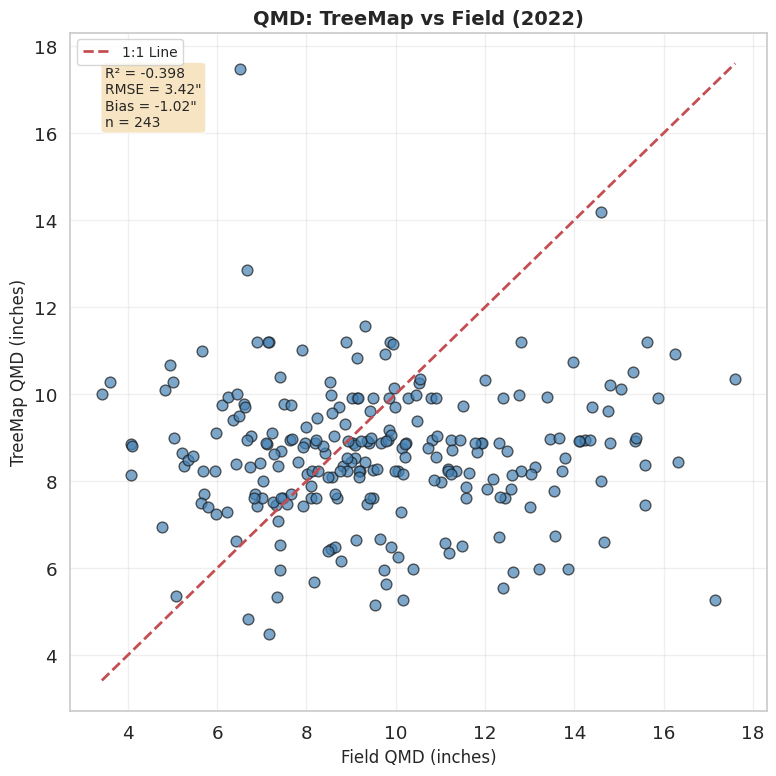

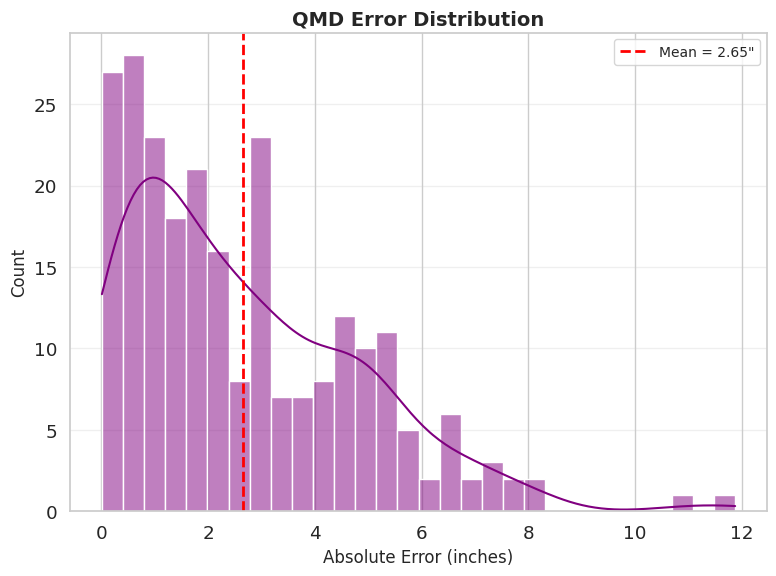

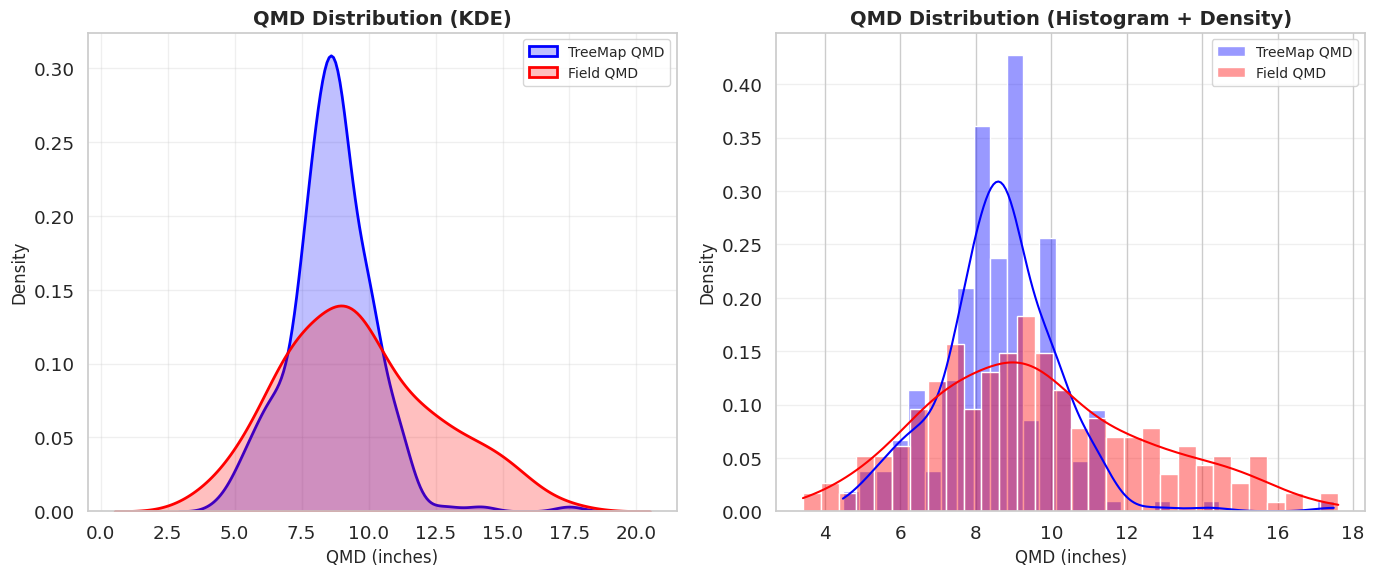

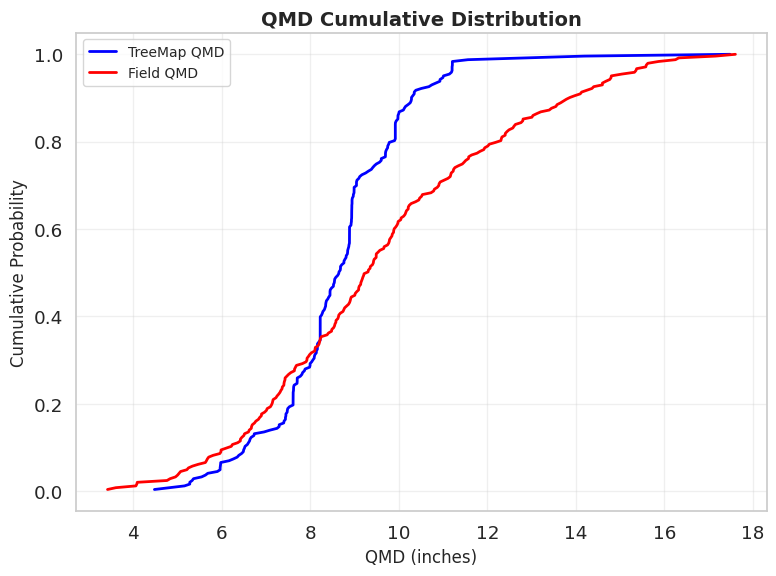


✅ QMD comparison saved to: /content/drive/MyDrive/QMD_comparison_2022.csv
✅ All QMD figures saved with 'Fig' prefix

✅ QMD COMPARISON COMPLETE

📊 Summary Statistics:

Field QMD:
count    243.000000
mean       9.616697
std        2.899340
min        3.417967
25%        7.420571
50%        9.304837
75%       11.455456
max       17.604886
Name: Field_QMD, dtype: float64

TreeMap QMD:
count    243.000000
mean       8.601063
std        1.563384
min        4.477772
25%        7.703451
50%        8.648432
75%        9.527852
max       17.485374
Name: TreeMap_QMD, dtype: float64

QMD Error:
count    243.000000
mean       2.652979
std        2.165057
min        0.008542
25%        0.870701
50%        2.102041
75%        4.095143
max       11.879389
Name: QMD_error, dtype: float64


In [ ]:
# ============================================================
# Section 6: Quadratic Mean Diameter (QMD) Comparison
# ============================================================

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# Set visualization style
sns.set(style="whitegrid", font_scale=1.2)

base_dir = "/content/drive/MyDrive"

print("="*60)
print("QUADRATIC MEAN DIAMETER (QMD) COMPARISON")
print("="*60)

# ============================
# 6.1 Field QMD Calculation
# ============================
print("\n1️⃣ Computing Field QMD...")

field_path = f"{base_dir}/TreeDataExport_editTY.csv"
talladega = pd.read_csv(field_path)

# Convert to numeric
talladega["Tree diameter (inches)"] = pd.to_numeric(
    talladega["Tree diameter (inches)"], errors="coerce"
)

# Filter valid diameters (DBH > 0)
talladega_clean = talladega[talladega["Tree diameter (inches)"] > 0].copy()

def qmd_with_N(d):
    """
    Calculate QMD with explicit N in formula:
    QMD = sqrt(sum(DBH^2) / N)

    Parameters:
    - d: Series of diameter values

    Returns:
    - QMD value
    """
    d = d.dropna()
    N = len(d)
    if N == 0:
        return np.nan
    return np.sqrt((d**2).sum() / N)

# Calculate Field QMD per plot
field_qmd = (
    talladega_clean.groupby("ParentGlobalID *")["Tree diameter (inches)"]
    .apply(qmd_with_N)
    .reset_index(name="Field_QMD")
)

print(f"   ✅ Computed Field QMD for {len(field_qmd)} plots")
print(f"   Mean Field QMD: {field_qmd['Field_QMD'].mean():.2f} inches")
print(f"   Range: {field_qmd['Field_QMD'].min():.2f} - {field_qmd['Field_QMD'].max():.2f} inches")

# ============================
# 6.2 TreeMap QMD Calculation
# ============================
print("\n2️⃣ Computing TreeMap QMD per polygon...")

treemap_path = f"{base_dir}/TreeMap{year}_tree_table.csv"
area_path = f"{base_dir}/final_area_summary_{year}_FINAL.csv"

treemap = pd.read_csv(treemap_path)
area_df = pd.read_csv(area_path)

# Detect TreeMap ID column
tm_id_col = None
for c in ["tm_id", "TM_ID", "Tm_ID", "TMID", "TmID"]:
    if c in treemap.columns:
        tm_id_col = c
        break
if tm_id_col is None:
    raise KeyError("❌ TreeMap ID column not found")

print(f"   Using TreeMap ID column: {tm_id_col}")

# Convert to numeric
treemap["DIA"] = pd.to_numeric(treemap["DIA"], errors="coerce")
treemap_clean = treemap[treemap["DIA"] > 0].copy()

# Calculate QMD per TreeMap polygon
# QMD_DN = sqrt(sum(DIA^2) / N_DN)
treemap_clean["DIA2"] = treemap_clean["DIA"] ** 2

tm_stats = (
    treemap_clean
    .groupby(tm_id_col)
    .agg(
        DIA2_sum=("DIA2", "sum"),
        N=("DIA2", "size")
    )
    .reset_index()
)

tm_stats["QMD_DN"] = np.sqrt(tm_stats["DIA2_sum"] / tm_stats["N"])

print(f"   ✅ Computed TreeMap QMD for {len(tm_stats)} polygons")
print(f"   Mean TreeMap QMD: {tm_stats['QMD_DN'].mean():.2f} inches")

# ============================
# 6.3 Area-weighted QMD aggregation
# ============================
print("\n3️⃣ Aggregating TreeMap QMD to plots using area_ratio...")

# Merge TreeMap QMD with area ratios
merged = area_df.merge(
    tm_stats[[tm_id_col, "QMD_DN"]],
    left_on="DN",
    right_on=tm_id_col,
    how="left"
)

# Remove rows without QMD
merged = merged.dropna(subset=["QMD_DN"]).copy()

# Area-weighted aggregation
# QMD_plot = sqrt(sum(area_ratio * QMD_DN^2))
merged["QMD_DN2_weighted"] = (merged["QMD_DN"] ** 2) * merged["area_ratio"]

plot_qmd_tm = (
    merged.groupby("globalid")["QMD_DN2_weighted"]
    .sum()
    .reset_index()
)

plot_qmd_tm["TreeMap_QMD"] = np.sqrt(plot_qmd_tm["QMD_DN2_weighted"])
plot_qmd_tm = plot_qmd_tm[["globalid", "TreeMap_QMD"]]

print(f"   ✅ Aggregated TreeMap QMD to {len(plot_qmd_tm)} plots")

# ============================
# 6.4 Merge and compute errors
# ============================
print("\n4️⃣ Comparing TreeMap QMD vs Field QMD...")

qmd_comp = plot_qmd_tm.merge(
    field_qmd,
    left_on="globalid",
    right_on="ParentGlobalID *",
    how="inner"
)

qmd_comp["QMD_error"] = (qmd_comp["TreeMap_QMD"] - qmd_comp["Field_QMD"]).abs()

print(f"   ✅ Matched {len(qmd_comp)} plots for comparison")

# ============================
# 6.5 Compute validation metrics
# ============================
print("\n" + "="*60)
print("VALIDATION METRICS")
print("="*60)

mse_qmd = mean_squared_error(qmd_comp["Field_QMD"], qmd_comp["TreeMap_QMD"])
rmse_qmd = np.sqrt(mse_qmd)
mae_qmd = mean_absolute_error(qmd_comp["Field_QMD"], qmd_comp["TreeMap_QMD"])
r2_qmd = r2_score(qmd_comp["Field_QMD"], qmd_comp["TreeMap_QMD"])
bias_qmd = (qmd_comp["TreeMap_QMD"] - qmd_comp["Field_QMD"]).mean()

print(f"\n📏 QMD Metrics ({year}):")
print(f"   RMSE  = {rmse_qmd:.3f} inches")
print(f"   MAE   = {mae_qmd:.3f} inches")
print(f"   R²    = {r2_qmd:.3f}")
print(f"   Bias  = {bias_qmd:.3f} inches")
print(f"   %RMSE = {(rmse_qmd / qmd_comp['Field_QMD'].mean()) * 100:.1f}%")

# ============================
# 6.6 Visualization
# ============================
print("\n5️⃣ Creating visualizations...")

# --------------------------------------
# Figure 1: Scatter plot with 1:1 line
# --------------------------------------
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(
    qmd_comp["Field_QMD"],
    qmd_comp["TreeMap_QMD"],
    alpha=0.7,
    edgecolor="k",
    s=60,
    color='steelblue'
)

max_q = max(qmd_comp["Field_QMD"].max(), qmd_comp["TreeMap_QMD"].max())
min_q = min(qmd_comp["Field_QMD"].min(), qmd_comp["TreeMap_QMD"].min())

ax.plot([min_q, max_q], [min_q, max_q], "r--", linewidth=2, label="1:1 Line")

ax.set_title(f"QMD: TreeMap vs Field ({year})", fontweight="bold", fontsize=14)
ax.set_xlabel("Field QMD (inches)", fontsize=12)
ax.set_ylabel("TreeMap QMD (inches)", fontsize=12)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Add metrics annotation
ax.text(
    0.05, 0.95,
    f'R² = {r2_qmd:.3f}\nRMSE = {rmse_qmd:.2f}"\nBias = {bias_qmd:.2f}"\nn = {len(qmd_comp)}',
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
    fontsize=10
)

plt.tight_layout()
plt.savefig(f"{base_dir}/Fig5_QMD_scatter_{year}.png", dpi=300, bbox_inches="tight")
plt.show()

# --------------------------------------
# Figure 2: Error distribution
# --------------------------------------
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(
    qmd_comp["QMD_error"],
    bins=30,
    kde=True,
    color="purple",
    ax=ax
)

ax.set_title("QMD Error Distribution", fontweight="bold", fontsize=14)
ax.set_xlabel("Absolute Error (inches)", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.axvline(
    qmd_comp["QMD_error"].mean(),
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Mean = {qmd_comp["QMD_error"].mean():.2f}"'
)
ax.legend(fontsize=10)
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f"{base_dir}/Fig6_QMD_error_distribution_{year}.png", dpi=300, bbox_inches="tight")
plt.show()

# --------------------------------------
# Figure 3: Distribution comparison
# --------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# KDE comparison
sns.kdeplot(
    qmd_comp["TreeMap_QMD"],
    label="TreeMap QMD",
    ax=axes[0],
    fill=True,
    linewidth=2,
    color='blue'
)
sns.kdeplot(
    qmd_comp["Field_QMD"],
    label="Field QMD",
    ax=axes[0],
    fill=True,
    linewidth=2,
    color='red'
)
axes[0].set_title("QMD Distribution (KDE)", fontweight="bold", fontsize=14)
axes[0].set_xlabel("QMD (inches)", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Histogram comparison
sns.histplot(
    qmd_comp["TreeMap_QMD"],
    bins=30,
    kde=True,
    color="blue",
    label="TreeMap QMD",
    stat="density",
    alpha=0.4,
    ax=axes[1]
)
sns.histplot(
    qmd_comp["Field_QMD"],
    bins=30,
    kde=True,
    color="red",
    label="Field QMD",
    stat="density",
    alpha=0.4,
    ax=axes[1]
)
axes[1].set_title("QMD Distribution (Histogram + Density)", fontweight="bold", fontsize=14)
axes[1].set_xlabel("QMD (inches)", fontsize=12)
axes[1].set_ylabel("Density", fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f"{base_dir}/Fig7_QMD_distributions_{year}.png", dpi=300, bbox_inches="tight")
plt.show()

# --------------------------------------
# Figure 4: Cumulative Distribution (CDF)
# --------------------------------------
fig, ax = plt.subplots(figsize=(8, 6))

# Sort data for CDF
tm_sorted = np.sort(qmd_comp["TreeMap_QMD"].dropna())
fd_sorted = np.sort(qmd_comp["Field_QMD"].dropna())

# Compute cumulative probabilities
tm_cdf = np.arange(1, len(tm_sorted)+1) / len(tm_sorted)
fd_cdf = np.arange(1, len(fd_sorted)+1) / len(fd_sorted)

ax.plot(tm_sorted, tm_cdf, label="TreeMap QMD", linewidth=2, color='blue')
ax.plot(fd_sorted, fd_cdf, label="Field QMD", linewidth=2, color='red')

ax.set_title("QMD Cumulative Distribution", fontweight="bold", fontsize=14)
ax.set_xlabel("QMD (inches)", fontsize=12)
ax.set_ylabel("Cumulative Probability", fontsize=12)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{base_dir}/Fig8_QMD_CDF_{year}.png", dpi=300, bbox_inches="tight")
plt.show()

# ============================
# 6.7 Save results
# ============================
qmd_output_path = f"{base_dir}/QMD_comparison_{year}.csv"
qmd_comp.to_csv(qmd_output_path, index=False)

print(f"\n✅ QMD comparison saved to: {qmd_output_path}")
print(f"✅ All QMD figures saved with 'Fig' prefix")

print("\n" + "="*60)
print("✅ QMD COMPARISON COMPLETE")
print("="*60)

# ============================
# 6.8 Summary statistics table
# ============================
print("\n📊 Summary Statistics:")
print("\nField QMD:")
print(qmd_comp["Field_QMD"].describe())
print("\nTreeMap QMD:")
print(qmd_comp["TreeMap_QMD"].describe())
print("\nQMD Error:")
print(qmd_comp["QMD_error"].describe())

# 7: Basal Area (BA) and Live Basal Area (BALIVE) Comparison

BASAL AREA (BA) AND BALIVE COMPARISON

1️⃣ Computing Field BA and BALIVE...
   ✅ Computed Field BA for 255 plots
   Mean Field BA: 0.556 sqft/tree
   Mean Field BALIVE: 5.56 sqft/acre

2️⃣ Computing TreeMap BA and BALIVE...
   Using TreeMap ID column: TM_ID


/tmp/ipython-input-3848805528.py:94: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  treemap_clean["TPA_UNADJ"].fillna(6.018, inplace=True)


   ✅ Computed TreeMap BA for 65043 polygons
   Mean TreeMap BA: 0.686 sqft/tree
   Mean TreeMap BALIVE: 3.69 sqft/acre

3️⃣ Aggregating TreeMap BA to plots using area_ratio...
   ✅ Aggregated to 244 plots

4️⃣ Comparing TreeMap vs Field...
   ✅ Matched 243 plots for comparison

VALIDATION METRICS

📏 BA Metrics (2022):
   RMSE  = 0.3831 sqft/tree
   MAE   = 0.2791 sqft/tree
   R²    = -0.373
   Bias  = -0.1333 sqft/tree
   %RMSE = 69.6%

📏 BALIVE Metrics (2022):
   RMSE  = 4.19 sqft/acre
   MAE   = 3.08 sqft/acre
   R²    = -0.641
   Bias  = -2.52 sqft/acre
   %RMSE = 76.1%

5️⃣ Creating visualizations...


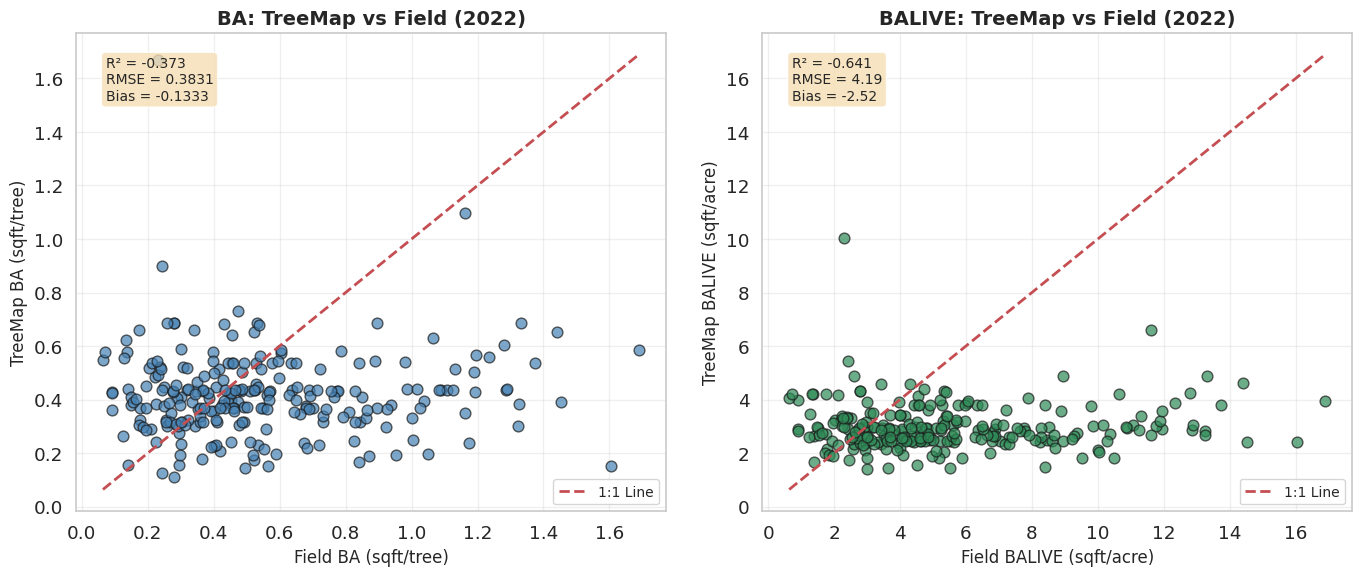

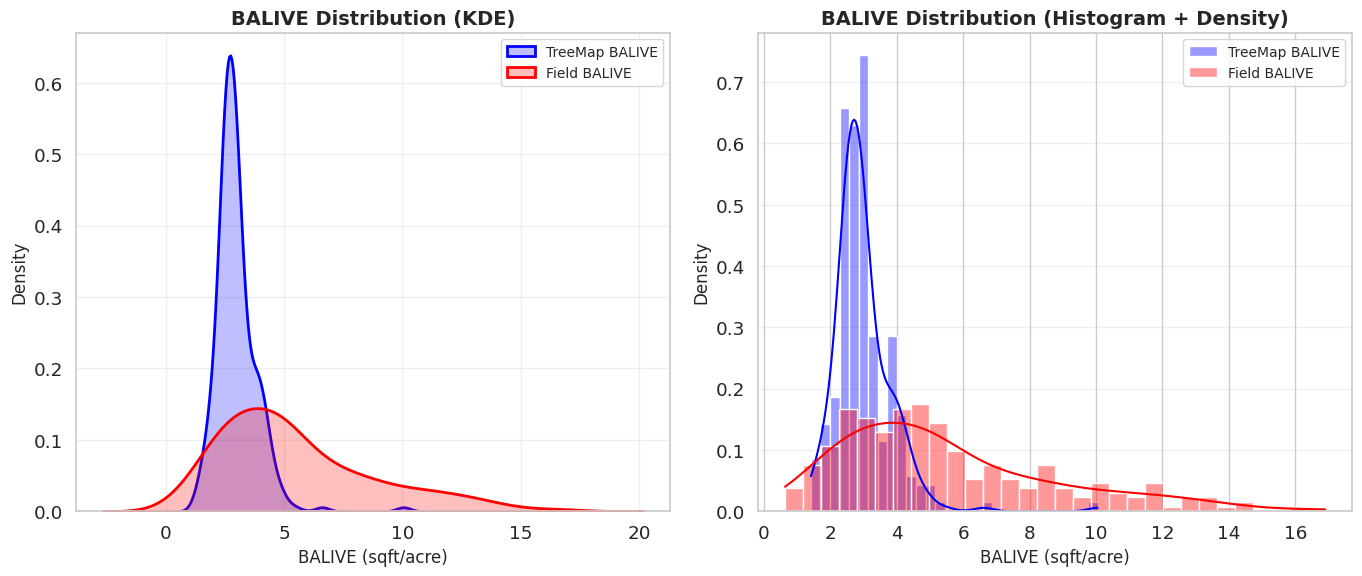

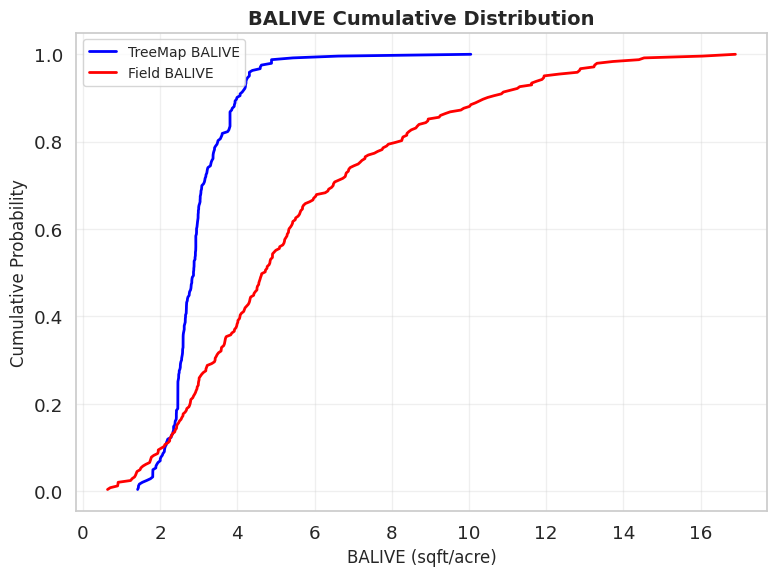

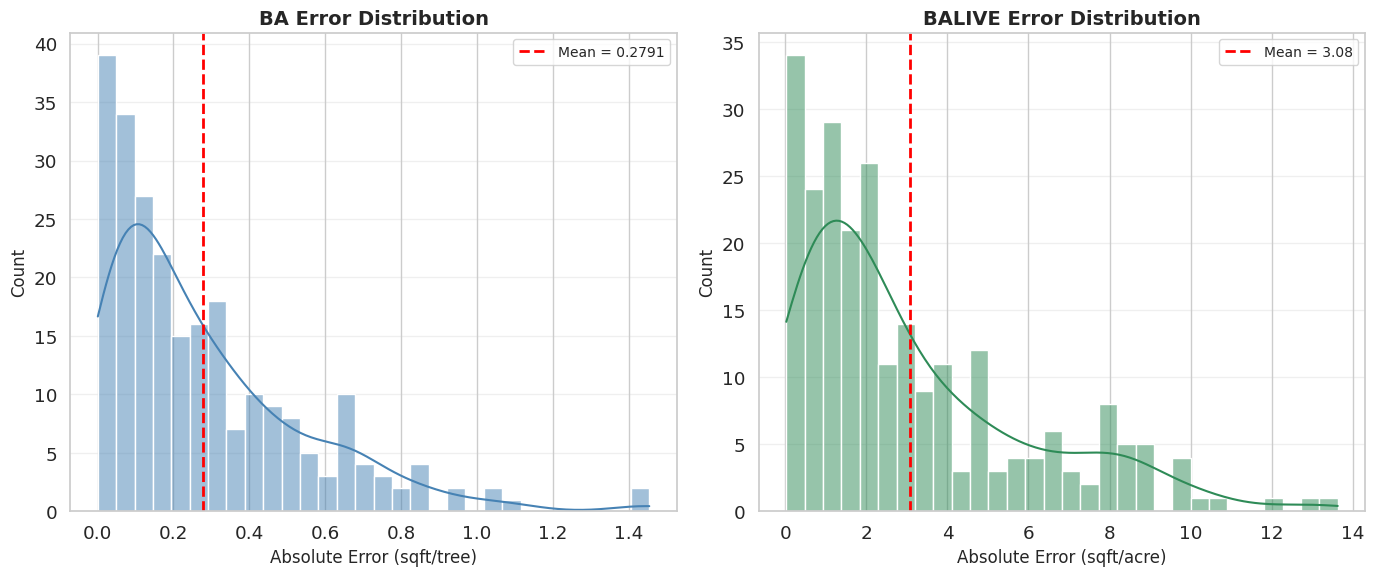


✅ BA/BALIVE comparison saved to: /content/drive/MyDrive/BA_BALIVE_comparison_2022.csv
✅ All BA/BALIVE figures saved with 'Fig' prefix

✅ BA AND BALIVE COMPARISON COMPLETE

📊 Summary Statistics:

Field BA (sqft/tree):
count    243.000000
mean       0.550049
std        0.327554
min        0.063716
25%        0.300324
50%        0.472207
75%        0.715717
max        1.690369
Name: Field_BA, dtype: float64

TreeMap BA (sqft/tree):
count    243.000000
mean       0.416753
std        0.158967
min        0.109355
25%        0.323658
50%        0.407934
75%        0.495121
max        1.667497
Name: TreeMap_BA, dtype: float64

Field BALIVE (sqft/acre):
count    243.000000
mean       5.500492
std        3.275544
min        0.637164
25%        3.003241
50%        4.722073
75%        7.157169
max       16.903691
Name: Field_BALIVE, dtype: float64

TreeMap BALIVE (sqft/acre):
count    243.000000
mean       2.978730
std        0.875073
min        1.416918
25%        2.465485
50%        2.864401
75

In [ ]:
# ============================================================
# Section 7: Basal Area (BA) and BALIVE Comparison
# ============================================================

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# Set visualization style
sns.set(style="whitegrid", font_scale=1.2)

base_dir = "/content/drive/MyDrive"

print("="*60)
print("BASAL AREA (BA) AND BALIVE COMPARISON")
print("="*60)

# ============================
# 7.1 Field BA Calculation
# ============================
print("\n1️⃣ Computing Field BA and BALIVE...")

field_path = f"{base_dir}/TreeDataExport_editTY.csv"
talladega = pd.read_csv(field_path)

# Convert to numeric
talladega["Tree diameter (inches)"] = pd.to_numeric(
    talladega["Tree diameter (inches)"], errors="coerce"
)

# Filter valid trees (DBH > 0)
talladega_clean = talladega[talladega["Tree diameter (inches)"] > 0].copy()

# Calculate basal area per tree (square feet)
# BA = 0.005454 × DBH²
talladega_clean["BA"] = 0.005454 * (talladega_clean["Tree diameter (inches)"] ** 2)

# Calculate per plot
# Assuming 1/10 acre plots → TPA_UNADJ = 10
talladega_summary = talladega_clean.groupby("ParentGlobalID *").agg(
    Field_BA_mean=("BA", "mean"),          # Mean BA per tree
    tree_count=("Tree diameter (inches)", "size")
).reset_index()

talladega_summary["TPA_UNADJ"] = 10.0  # Trees per acre for 1/10 acre plot
talladega_summary["Field_BALIVE"] = (
    talladega_summary["Field_BA_mean"] * talladega_summary["TPA_UNADJ"]
)

print(f"   ✅ Computed Field BA for {len(talladega_summary)} plots")
print(f"   Mean Field BA: {talladega_summary['Field_BA_mean'].mean():.3f} sqft/tree")
print(f"   Mean Field BALIVE: {talladega_summary['Field_BALIVE'].mean():.2f} sqft/acre")

# ============================
# 7.2 TreeMap BA Calculation
# ============================
print("\n2️⃣ Computing TreeMap BA and BALIVE...")

treemap_path = f"{base_dir}/TreeMap{year}_tree_table.csv"
final_export_path = f"{base_dir}/final_area_summary_{year}_FINAL.csv"

treemap = pd.read_csv(treemap_path)
final_export_data = pd.read_csv(final_export_path)

# Detect TreeMap ID column
tm_id_col = None
for c in ["tm_id", "TM_ID", "Tm_ID", "TMID", "TmID"]:
    if c in treemap.columns:
        tm_id_col = c
        break
if tm_id_col is None:
    raise KeyError("❌ TreeMap ID column not found")

print(f"   Using TreeMap ID column: {tm_id_col}")

# Convert to numeric
treemap["DIA"] = pd.to_numeric(treemap["DIA"], errors="coerce")
treemap_clean = treemap[treemap["DIA"] > 0].copy()

# Calculate BA per tree
treemap_clean["BA"] = 0.005454 * (treemap_clean["DIA"] ** 2)

# Handle TPA_UNADJ
if "TPA_UNADJ" in treemap_clean.columns:
    treemap_clean["TPA_UNADJ"] = pd.to_numeric(
        treemap_clean["TPA_UNADJ"], errors="coerce"
    )
else:
    treemap_clean["TPA_UNADJ"] = np.nan

# Fill missing TPA_UNADJ with default FIA value
treemap_clean["TPA_UNADJ"].fillna(6.018, inplace=True)

# Calculate BALIVE per tree
treemap_clean["BALIVE"] = treemap_clean["BA"] * treemap_clean["TPA_UNADJ"]

# Aggregate by TreeMap polygon (mean values)
treemap_summary = treemap_clean.groupby(tm_id_col).agg(
    BA_mean=("BA", "mean"),
    BALIVE_mean=("BALIVE", "mean")
).reset_index()

print(f"   ✅ Computed TreeMap BA for {len(treemap_summary)} polygons")
print(f"   Mean TreeMap BA: {treemap_summary['BA_mean'].mean():.3f} sqft/tree")
print(f"   Mean TreeMap BALIVE: {treemap_summary['BALIVE_mean'].mean():.2f} sqft/acre")

# ============================
# 7.3 Area-weighted aggregation
# ============================
print("\n3️⃣ Aggregating TreeMap BA to plots using area_ratio...")

# Merge TreeMap BA with area ratios
weighted_attributes = final_export_data.merge(
    treemap_summary,
    left_on="DN",
    right_on=tm_id_col,
    how="left"
)

# Calculate weighted attributes
weighted_attributes["weighted_BA"] = (
    weighted_attributes["BA_mean"] * weighted_attributes["area_ratio"]
)
weighted_attributes["weighted_BALIVE"] = (
    weighted_attributes["BALIVE_mean"] * weighted_attributes["area_ratio"]
)

# Sum by plot
treemap_plot_summary = weighted_attributes.groupby("globalid").agg(
    TreeMap_BA=("weighted_BA", "sum"),
    TreeMap_BALIVE=("weighted_BALIVE", "sum")
).reset_index()

print(f"   ✅ Aggregated to {len(treemap_plot_summary)} plots")

# ============================
# 7.4 Merge and compute errors
# ============================
print("\n4️⃣ Comparing TreeMap vs Field...")

ba_comp = treemap_plot_summary.merge(
    talladega_summary[["ParentGlobalID *", "Field_BA_mean", "Field_BALIVE"]],
    left_on="globalid",
    right_on="ParentGlobalID *",
    how="inner"
)

ba_comp.rename(columns={"Field_BA_mean": "Field_BA"}, inplace=True)

# Calculate errors
ba_comp["BA_error"] = (ba_comp["TreeMap_BA"] - ba_comp["Field_BA"]).abs()
ba_comp["BALIVE_error"] = (ba_comp["TreeMap_BALIVE"] - ba_comp["Field_BALIVE"]).abs()

print(f"   ✅ Matched {len(ba_comp)} plots for comparison")

# ============================
# 7.5 Compute validation metrics
# ============================
print("\n" + "="*60)
print("VALIDATION METRICS")
print("="*60)

# BA metrics
mse_ba = mean_squared_error(ba_comp["Field_BA"], ba_comp["TreeMap_BA"])
rmse_ba = np.sqrt(mse_ba)
mae_ba = mean_absolute_error(ba_comp["Field_BA"], ba_comp["TreeMap_BA"])
r2_ba = r2_score(ba_comp["Field_BA"], ba_comp["TreeMap_BA"])
bias_ba = (ba_comp["TreeMap_BA"] - ba_comp["Field_BA"]).mean()

print(f"\n📏 BA Metrics ({year}):")
print(f"   RMSE  = {rmse_ba:.4f} sqft/tree")
print(f"   MAE   = {mae_ba:.4f} sqft/tree")
print(f"   R²    = {r2_ba:.3f}")
print(f"   Bias  = {bias_ba:.4f} sqft/tree")
print(f"   %RMSE = {(rmse_ba / ba_comp['Field_BA'].mean()) * 100:.1f}%")

# BALIVE metrics
mse_balive = mean_squared_error(ba_comp["Field_BALIVE"], ba_comp["TreeMap_BALIVE"])
rmse_balive = np.sqrt(mse_balive)
mae_balive = mean_absolute_error(ba_comp["Field_BALIVE"], ba_comp["TreeMap_BALIVE"])
r2_balive = r2_score(ba_comp["Field_BALIVE"], ba_comp["TreeMap_BALIVE"])
bias_balive = (ba_comp["TreeMap_BALIVE"] - ba_comp["Field_BALIVE"]).mean()

print(f"\n📏 BALIVE Metrics ({year}):")
print(f"   RMSE  = {rmse_balive:.2f} sqft/acre")
print(f"   MAE   = {mae_balive:.2f} sqft/acre")
print(f"   R²    = {r2_balive:.3f}")
print(f"   Bias  = {bias_balive:.2f} sqft/acre")
print(f"   %RMSE = {(rmse_balive / ba_comp['Field_BALIVE'].mean()) * 100:.1f}%")

# ============================
# 7.6 Visualization
# ============================
print("\n5️⃣ Creating visualizations...")

# --------------------------------------
# Figure 1: BA and BALIVE scatter plots
# --------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# BA scatter
axes[0].scatter(
    ba_comp["Field_BA"],
    ba_comp["TreeMap_BA"],
    alpha=0.7,
    edgecolor="k",
    s=60,
    color='steelblue'
)
max_ba = max(ba_comp["Field_BA"].max(), ba_comp["TreeMap_BA"].max())
min_ba = min(ba_comp["Field_BA"].min(), ba_comp["TreeMap_BA"].min())
axes[0].plot([min_ba, max_ba], [min_ba, max_ba], "r--", linewidth=2, label="1:1 Line")
axes[0].set_title(f"BA: TreeMap vs Field ({year})", fontweight="bold", fontsize=14)
axes[0].set_xlabel("Field BA (sqft/tree)", fontsize=12)
axes[0].set_ylabel("TreeMap BA (sqft/tree)", fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Add metrics
axes[0].text(
    0.05, 0.95,
    f'R² = {r2_ba:.3f}\nRMSE = {rmse_ba:.4f}\nBias = {bias_ba:.4f}',
    transform=axes[0].transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
    fontsize=10
)

# BALIVE scatter
axes[1].scatter(
    ba_comp["Field_BALIVE"],
    ba_comp["TreeMap_BALIVE"],
    alpha=0.7,
    edgecolor="k",
    s=60,
    color='seagreen'
)
max_balive = max(ba_comp["Field_BALIVE"].max(), ba_comp["TreeMap_BALIVE"].max())
min_balive = min(ba_comp["Field_BALIVE"].min(), ba_comp["TreeMap_BALIVE"].min())
axes[1].plot([min_balive, max_balive], [min_balive, max_balive], "r--", linewidth=2, label="1:1 Line")
axes[1].set_title(f"BALIVE: TreeMap vs Field ({year})", fontweight="bold", fontsize=14)
axes[1].set_xlabel("Field BALIVE (sqft/acre)", fontsize=12)
axes[1].set_ylabel("TreeMap BALIVE (sqft/acre)", fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

# Add metrics
axes[1].text(
    0.05, 0.95,
    f'R² = {r2_balive:.3f}\nRMSE = {rmse_balive:.2f}\nBias = {bias_balive:.2f}',
    transform=axes[1].transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
    fontsize=10
)

plt.tight_layout()
plt.savefig(f"{base_dir}/Fig9_BA_BALIVE_scatter_{year}.png", dpi=300, bbox_inches="tight")
plt.show()

# --------------------------------------
# Figure 2: BALIVE distributions (KDE + Histogram)
# --------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# KDE
sns.kdeplot(
    ba_comp["TreeMap_BALIVE"],
    label="TreeMap BALIVE",
    ax=axes[0],
    fill=True,
    linewidth=2,
    color='blue'
)
sns.kdeplot(
    ba_comp["Field_BALIVE"],
    label="Field BALIVE",
    ax=axes[0],
    fill=True,
    linewidth=2,
    color='red'
)
axes[0].set_title("BALIVE Distribution (KDE)", fontweight="bold", fontsize=14)
axes[0].set_xlabel("BALIVE (sqft/acre)", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Histogram
sns.histplot(
    ba_comp["TreeMap_BALIVE"],
    bins=30,
    kde=True,
    color="blue",
    label="TreeMap BALIVE",
    stat="density",
    alpha=0.4,
    ax=axes[1]
)
sns.histplot(
    ba_comp["Field_BALIVE"],
    bins=30,
    kde=True,
    color="red",
    label="Field BALIVE",
    stat="density",
    alpha=0.4,
    ax=axes[1]
)
axes[1].set_title("BALIVE Distribution (Histogram + Density)", fontweight="bold", fontsize=14)
axes[1].set_xlabel("BALIVE (sqft/acre)", fontsize=12)
axes[1].set_ylabel("Density", fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f"{base_dir}/Fig10_BALIVE_distributions_{year}.png", dpi=300, bbox_inches="tight")
plt.show()

# --------------------------------------
# Figure 3: BALIVE CDF
# --------------------------------------
fig, ax = plt.subplots(figsize=(8, 6))

tm_sorted = np.sort(ba_comp["TreeMap_BALIVE"].dropna())
fd_sorted = np.sort(ba_comp["Field_BALIVE"].dropna())

tm_cdf = np.arange(1, len(tm_sorted)+1) / len(tm_sorted)
fd_cdf = np.arange(1, len(fd_sorted)+1) / len(fd_sorted)

ax.plot(tm_sorted, tm_cdf, label="TreeMap BALIVE", linewidth=2, color='blue')
ax.plot(fd_sorted, fd_cdf, label="Field BALIVE", linewidth=2, color='red')

ax.set_title("BALIVE Cumulative Distribution", fontweight="bold", fontsize=14)
ax.set_xlabel("BALIVE (sqft/acre)", fontsize=12)
ax.set_ylabel("Cumulative Probability", fontsize=12)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{base_dir}/Fig11_BALIVE_CDF_{year}.png", dpi=300, bbox_inches="tight")
plt.show()

# --------------------------------------
# Figure 4: Error distributions
# --------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(
    ba_comp["BA_error"],
    bins=30,
    kde=True,
    color="steelblue",
    ax=axes[0]
)
axes[0].set_title("BA Error Distribution", fontweight="bold", fontsize=14)
axes[0].set_xlabel("Absolute Error (sqft/tree)", fontsize=12)
axes[0].set_ylabel("Count", fontsize=12)
axes[0].axvline(
    ba_comp["BA_error"].mean(),
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Mean = {ba_comp["BA_error"].mean():.4f}'
)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3, axis='y')

sns.histplot(
    ba_comp["BALIVE_error"],
    bins=30,
    kde=True,
    color="seagreen",
    ax=axes[1]
)
axes[1].set_title("BALIVE Error Distribution", fontweight="bold", fontsize=14)
axes[1].set_xlabel("Absolute Error (sqft/acre)", fontsize=12)
axes[1].set_ylabel("Count", fontsize=12)
axes[1].axvline(
    ba_comp["BALIVE_error"].mean(),
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Mean = {ba_comp["BALIVE_error"].mean():.2f}'
)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f"{base_dir}/Fig12_BA_BALIVE_errors_{year}.png", dpi=300, bbox_inches="tight")
plt.show()

# ============================
# 7.7 Save results
# ============================
ba_output_path = f"{base_dir}/BA_BALIVE_comparison_{year}.csv"
ba_comp.to_csv(ba_output_path, index=False)

print(f"\n✅ BA/BALIVE comparison saved to: {ba_output_path}")
print(f"✅ All BA/BALIVE figures saved with 'Fig' prefix")

print("\n" + "="*60)
print("✅ BA AND BALIVE COMPARISON COMPLETE")
print("="*60)

# ============================
# 7.8 Summary statistics
# ============================
print("\n📊 Summary Statistics:")
print("\nField BA (sqft/tree):")
print(ba_comp["Field_BA"].describe())
print("\nTreeMap BA (sqft/tree):")
print(ba_comp["TreeMap_BA"].describe())
print("\nField BALIVE (sqft/acre):")
print(ba_comp["Field_BALIVE"].describe())
print("\nTreeMap BALIVE (sqft/acre):")
print(ba_comp["TreeMap_BALIVE"].describe())

# 8: Species-Specific Volume Calculation and Comparison

SPECIES-SPECIFIC VOLUME COMPARISON

1️⃣ Loading volume coefficients...
   ✅ Loaded volume coefficients for 361 species

2️⃣ Computing TreeMap volume per polygon...
   Using TreeMap ID column: TM_ID
   Trees before filter: 2388297
   Trees after filter (DIA >= 5): 1982932

   📊 TreeMap volume statistics (per tree):
      Mean: 32.72 ft³/tree
      Median: 9.31 ft³/tree
      Range: 0.28 - 10271.78 ft³/tree

   ⚠️ TPA_UNADJ varies within 6267 polygons
      → Using per-tree TPA method

   ✅ Computed volume for 64661 TreeMap polygons
      Mean polygon volume: 14699.49 ft³/acre
      Median polygon volume: 10779.56 ft³/acre
      Range: 3.52 - 394916

   🔬 Volume Coefficient Coverage:
      Total trees: 8012401
      Species-specific: 7739531 (96.6%)
      Default coefficients: 272870 (3.4%)

3️⃣ Computing Field volume...
   ⚠️ Warning: 69 trees with unmatched species
   Trees before filter: 23486
   Trees after filter (DBH >= 5): 15870

   📊 Field volume statistics (per tree):
      Mean

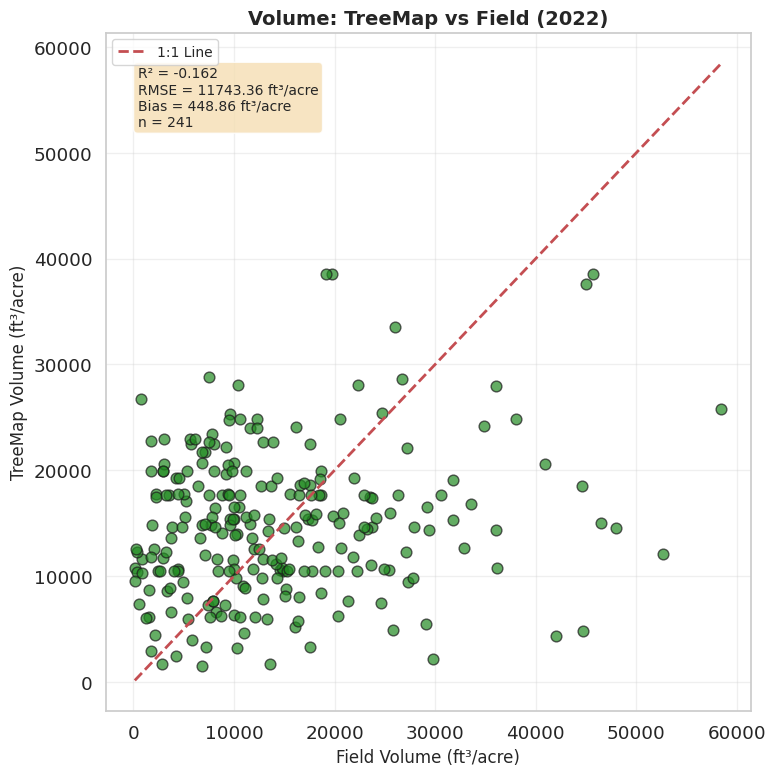


📊 Figure 2: Volume distribution...


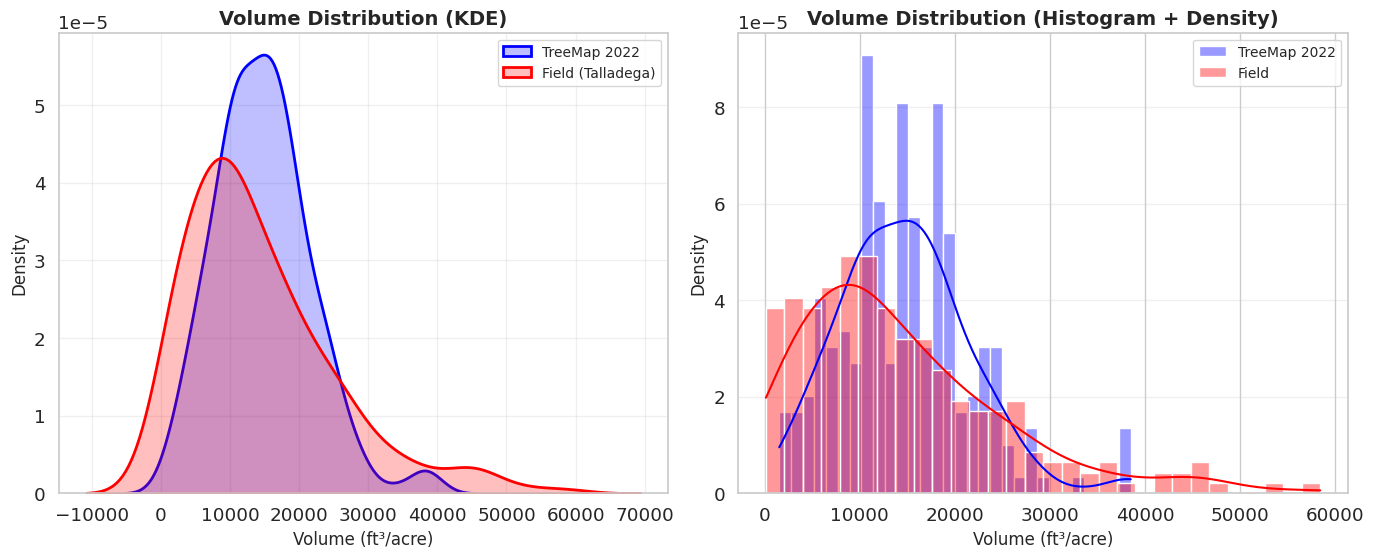


📊 Figure 3: Cumulative distribution...


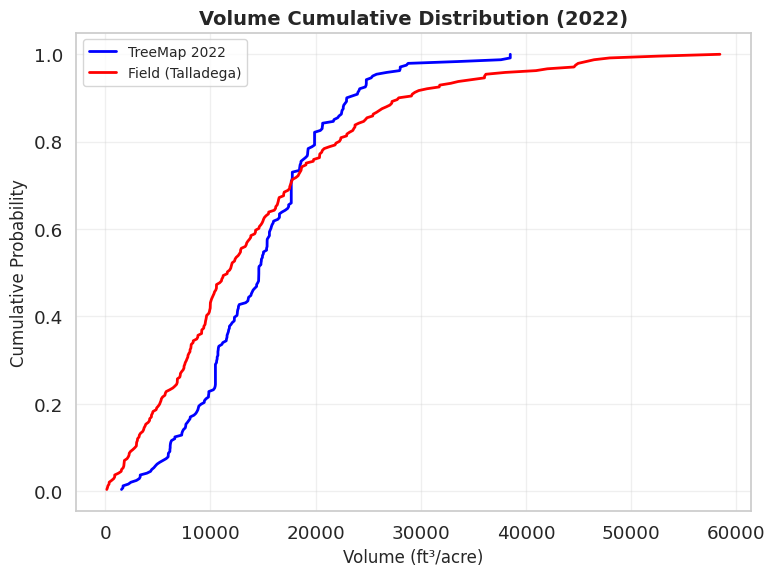


📊 Figure 4: Error distribution...


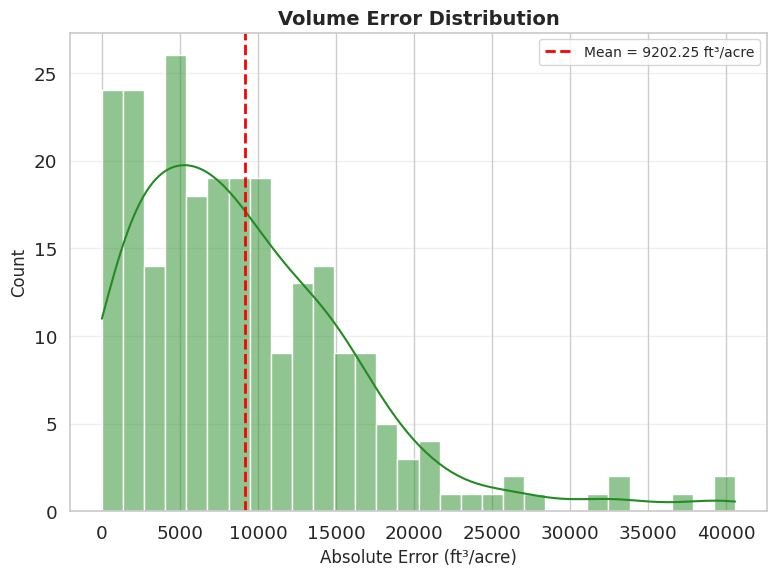


📊 Figure 5: Residual plot...


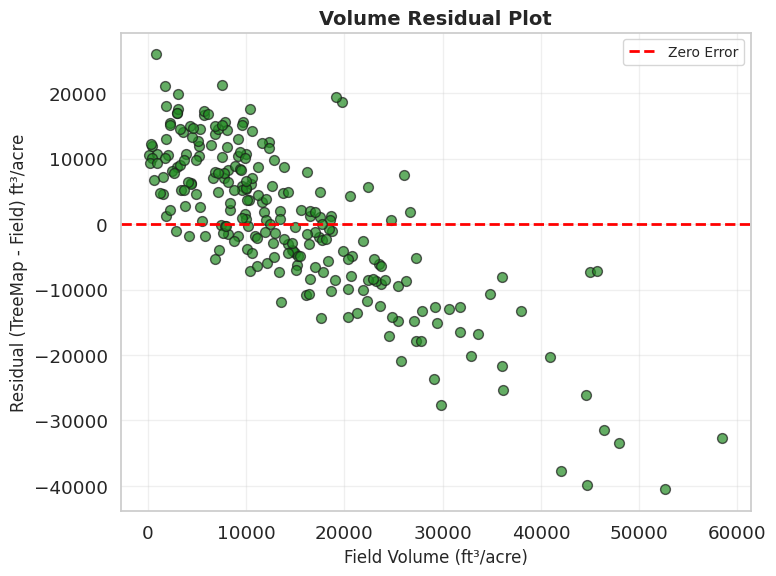


✅ Volume comparison saved to: /content/drive/MyDrive/Volume_comparison_2022.csv
✅ All volume figures saved (Fig13-Fig17)

✅ SPECIES-SPECIFIC VOLUME COMPARISON COMPLETE

📊 Summary Statistics:

Field Volume (ft³/acre):
count      241.000000
mean     14342.090200
std      10917.200914
min        143.781700
25%       6850.236825
50%      11609.221309
75%      19100.996214
max      58440.253650
Name: Field_VOL, dtype: float64

TreeMap Volume (ft³/acre):
count      241.000000
mean     14790.948026
std       6869.453178
min       1541.050706
25%      10473.230717
50%      14598.680986
75%      18595.333123
max      38505.836793
Name: TreeMap_VOL, dtype: float64

Volume Error (ft³/acre):
count      241.000000
mean      9202.251553
std       7310.733999
min         12.614231
25%       4020.596706
50%       7911.378596
75%      12980.812616
max      40557.866327
Name: VOLUME_error, dtype: float64

🔬 Species Coverage:
   TreeMap unique species: 373
   Field unique species: 36

   TreeMap trees w

In [ ]:
# ============================================================
# Section 8: Species-Specific Volume Comparison (COMPLETE)
# ============================================================

"""
CORRECTED VERSION with:
1. Fixed TPA calculation logic
2. Coefficient coverage reporting
3. All original visualizations
4. Sanity checks
"""

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", font_scale=1.2)
base_dir = "/content/drive/MyDrive"

print("="*80)
print("SPECIES-SPECIFIC VOLUME COMPARISON")
print("="*80)

# ============================
# 8.1 Load volume coefficients
# ============================
print("\n1️⃣ Loading volume coefficients...")

# Default all-species coefficients
a_all, b_all, c_all = 0.08168, 1.15697, 0.06573

# File paths
treemap_path = f"{base_dir}/TreeMap{year}_tree_table.csv"
talladega_path = f"{base_dir}/TreeDataExport_editTY.csv"
area_summary_path = f"{base_dir}/final_area_summary_{year}_FINAL.csv"
coef_path = f"{base_dir}/Table S3a_volob_coefs_spcd.csv"
species_ref_path = f"{base_dir}/species_ref_final.csv"

# Load coefficient table
coefs = pd.read_csv(coef_path)
coefs.columns = coefs.columns.str.lower()
coefs = coefs.rename(columns={"spcd": "SPCD", "coefa": "a", "coefb": "b", "coefc": "c"})

print(f"   ✅ Loaded volume coefficients for {len(coefs)} species")

# ============================
# 8.2 TreeMap volume calculation (CORRECTED)
# ============================
print("\n2️⃣ Computing TreeMap volume per polygon...")

treemap = pd.read_csv(treemap_path)

# Detect TreeMap ID column
tm_id_col = None
for col in ["tm_id", "TM_ID", "Tm_ID", "TMID", "TmID"]:
    if col in treemap.columns:
        tm_id_col = col
        break
if tm_id_col is None:
    raise KeyError("❌ TreeMap ID column not found")

print(f"   Using TreeMap ID column: {tm_id_col}")

# Convert to numeric
treemap["SPCD"] = pd.to_numeric(treemap.get("SPCD"), errors="coerce")
treemap["DIA"] = pd.to_numeric(treemap.get("DIA"), errors="coerce")
treemap["HT"] = pd.to_numeric(treemap.get("HT"), errors="coerce")
treemap["TPA_UNADJ"] = pd.to_numeric(treemap.get("TPA_UNADJ"), errors="coerce")

# Fill missing TPA_UNADJ
treemap["TPA_UNADJ"].fillna(6.018, inplace=True)

# Filter valid trees (DBH >= 5 inches)
treemap_original_count = len(treemap)
treemap = treemap[treemap["DIA"] >= 5].copy()

print(f"   Trees before filter: {treemap_original_count}")
print(f"   Trees after filter (DIA >= 5): {len(treemap)}")

# Merge with volume coefficients
treemap = treemap.merge(coefs, on="SPCD", how="left")

# Track coefficient usage
treemap["used_default_coef"] = treemap["a"].isna()

# Fill missing coefficients
treemap["a"].fillna(a_all, inplace=True)
treemap["b"].fillna(b_all, inplace=True)
treemap["c"].fillna(c_all, inplace=True)

# Calculate volume per tree (ft³/tree)
treemap["Vol_tree"] = (
    treemap["a"] *
    (treemap["DIA"] ** treemap["b"]) *
    (treemap["HT"] ** treemap["c"])
)

print(f"\n   📊 TreeMap volume statistics (per tree):")
print(f"      Mean: {treemap['Vol_tree'].mean():.2f} ft³/tree")
print(f"      Median: {treemap['Vol_tree'].median():.2f} ft³/tree")
print(f"      Range: {treemap['Vol_tree'].min():.2f} - {treemap['Vol_tree'].max():.2f} ft³/tree")

# 🔧 CORRECTED: Check TPA structure
tpa_per_polygon = treemap.groupby(tm_id_col)["TPA_UNADJ"].nunique()
tpa_varies = (tpa_per_polygon > 1).sum()

if tpa_varies == 0:
    print("\n   ✅ TPA_UNADJ is constant per polygon")
    print("      → Using correct aggregation method")

    # Method 1: TPA constant per polygon
    treemap_vol_by_DN = (
        treemap.groupby(tm_id_col)
        .agg({
            'Vol_tree': 'sum',
            'TPA_UNADJ': 'first'
        })
        .reset_index()
    )
    treemap_vol_by_DN["VOL_DN"] = (
        treemap_vol_by_DN["Vol_tree"] * treemap_vol_by_DN["TPA_UNADJ"]
    )
else:
    print(f"\n   ⚠️ TPA_UNADJ varies within {tpa_varies} polygons")
    print("      → Using per-tree TPA method")

    # Method 2: TPA varies per tree
    treemap["VOLUME_tree_acre"] = treemap["Vol_tree"] * treemap["TPA_UNADJ"]
    treemap_vol_by_DN = (
        treemap.groupby(tm_id_col)["VOLUME_tree_acre"]
        .sum()
        .reset_index()
        .rename(columns={"VOLUME_tree_acre": "VOL_DN"})
    )

print(f"\n   ✅ Computed volume for {len(treemap_vol_by_DN)} TreeMap polygons")
print(f"      Mean polygon volume: {treemap_vol_by_DN['VOL_DN'].mean():.2f} ft³/acre")
print(f"      Median polygon volume: {treemap_vol_by_DN['VOL_DN'].median():.2f} ft³/acre")
print(f"      Range: {treemap_vol_by_DN['VOL_DN'].min():.2f} - {treemap_vol_by_DN['VOL_DN'].max():.0f}")

# Coefficient coverage
total_trees = len(treemap)
default_count = treemap["used_default_coef"].sum()
specific_count = total_trees - default_count

print(f"\n   🔬 Volume Coefficient Coverage:")
print(f"      Total trees: {total_trees}")
print(f"      Species-specific: {specific_count} ({specific_count/total_trees*100:.1f}%)")
print(f"      Default coefficients: {default_count} ({default_count/total_trees*100:.1f}%)")

# ============================
# 8.3 Field volume calculation (CORRECTED)
# ============================
print("\n3️⃣ Computing Field volume...")

talladega = pd.read_csv(talladega_path)
species_ref = pd.read_csv(species_ref_path)

# Clean species names
talladega["Species"] = talladega["Species"].astype(str).str.strip().str.lower()
species_ref["Species"] = species_ref["Species"].astype(str).str.strip().str.lower()

# Merge to get SPCD
talladega = talladega.merge(species_ref, on="Species", how="left")

unmatched = talladega["SPCD"].isna().sum()
if unmatched > 0:
    print(f"   ⚠️ Warning: {unmatched} trees with unmatched species")

# Merge with volume coefficients
talladega = talladega.merge(coefs, on="SPCD", how="left")

# Track coefficient usage
talladega["used_default_coef"] = talladega["a"].isna()

# Fill missing coefficients
talladega["a"].fillna(a_all, inplace=True)
talladega["b"].fillna(b_all, inplace=True)
talladega["c"].fillna(c_all, inplace=True)

# Convert to numeric
talladega["Tree diameter (inches)"] = pd.to_numeric(
    talladega["Tree diameter (inches)"], errors="coerce"
)
talladega["Tree height (feet)"] = pd.to_numeric(
    talladega["Tree height (feet)"], errors="coerce"
)

# Filter valid trees
talladega_original_count = len(talladega)
talladega = talladega[talladega["Tree diameter (inches)"] >= 5].copy()

print(f"   Trees before filter: {talladega_original_count}")
print(f"   Trees after filter (DBH >= 5): {len(talladega)}")

# Calculate volume per tree
talladega["Vol_tree"] = (
    talladega["a"] *
    (talladega["Tree diameter (inches)"] ** talladega["b"]) *
    (talladega["Tree height (feet)"] ** talladega["c"])
)

print(f"\n   📊 Field volume statistics (per tree):")
print(f"      Mean: {talladega['Vol_tree'].mean():.2f} ft³/tree")
print(f"      Median: {talladega['Vol_tree'].median():.2f} ft³/tree")

# 🔧 CORRECTED: Aggregate then multiply by TPA
talladega_vol_by_plot = (
    talladega.groupby("ParentGlobalID *")["Vol_tree"]
    .sum()
    .reset_index()
)
talladega_vol_by_plot["Field_VOL"] = talladega_vol_by_plot["Vol_tree"] * 10.0

print(f"\n   ✅ Computed volume for {len(talladega_vol_by_plot)} field plots")
print(f"      Mean plot volume: {talladega_vol_by_plot['Field_VOL'].mean():.2f} ft³/acre")
print(f"      Median plot volume: {talladega_vol_by_plot['Field_VOL'].median():.2f} ft³/acre")
print(f"      Range: {talladega_vol_by_plot['Field_VOL'].min():.2f} - {talladega_vol_by_plot['Field_VOL'].max():.2f}")

# Field coefficient coverage
total_field_trees = len(talladega)
default_field = talladega["used_default_coef"].sum()
specific_field = total_field_trees - default_field

print(f"\n   🔬 Field Volume Coefficient Coverage:")
print(f"      Total trees: {total_field_trees}")
print(f"      Species-specific: {specific_field} ({specific_field/total_field_trees*100:.1f}%)")
print(f"      Default coefficients: {default_field} ({default_field/total_field_trees*100:.1f}%)")

# ============================
# 8.4 Area-weighted aggregation
# ============================
print("\n4️⃣ Aggregating TreeMap volume to plots using area_ratio...")

area_summary = pd.read_csv(area_summary_path)

area_with_vol = area_summary.merge(
    treemap_vol_by_DN,
    left_on="DN",
    right_on=tm_id_col,
    how="left"
)

area_with_vol = area_with_vol.dropna(subset=["VOL_DN"]).copy()

area_with_vol["VOL_DN_weighted"] = (
    area_with_vol["VOL_DN"] * area_with_vol["area_ratio"]
)

treemap_vol_by_plot = (
    area_with_vol
    .groupby("globalid")["VOL_DN_weighted"]
    .sum()
    .reset_index()
    .rename(columns={"VOL_DN_weighted": "TreeMap_VOL"})
)

print(f"   ✅ Aggregated to {len(treemap_vol_by_plot)} plots")

# ============================
# 8.5 Merge and compute errors
# ============================
print("\n5️⃣ Comparing TreeMap vs Field volume...")

comparison = treemap_vol_by_plot.merge(
    talladega_vol_by_plot,
    left_on="globalid",
    right_on="ParentGlobalID *",
    how="inner"
)

comparison["VOLUME_error"] = (comparison["TreeMap_VOL"] - comparison["Field_VOL"]).abs()

print(f"   ✅ Matched {len(comparison)} plots for comparison")

# ============================
# 8.6 Validation metrics
# ============================
print("\n" + "="*80)
print("VALIDATION METRICS")
print("="*80)

mse_vol = mean_squared_error(comparison["Field_VOL"], comparison["TreeMap_VOL"])
rmse_vol = np.sqrt(mse_vol)
mae_vol = mean_absolute_error(comparison["Field_VOL"], comparison["TreeMap_VOL"])
r2_vol = r2_score(comparison["Field_VOL"], comparison["TreeMap_VOL"])
bias_vol = (comparison["TreeMap_VOL"] - comparison["Field_VOL"]).mean()

print(f"\n📏 Volume Metrics ({year}):")
print(f"   RMSE  = {rmse_vol:.2f} ft³/acre")
print(f"   MAE   = {mae_vol:.2f} ft³/acre")
print(f"   R²    = {r2_vol:.3f}")
print(f"   Bias  = {bias_vol:.2f} ft³/acre")
print(f"   %RMSE = {(rmse_vol / comparison['Field_VOL'].mean()) * 100:.1f}%")

print(f"\n📊 Comparison Summary:")
print(f"   Field volume:   {comparison['Field_VOL'].mean():.2f} ± {comparison['Field_VOL'].std():.2f} ft³/acre")
print(f"   TreeMap volume: {comparison['TreeMap_VOL'].mean():.2f} ± {comparison['TreeMap_VOL'].std():.2f} ft³/acre")
print(f"   Mean difference: {bias_vol:.2f} ft³/acre ({(bias_vol/comparison['Field_VOL'].mean())*100:.1f}%)")

# ============================
# 8.7 Sanity checks
# ============================
print("\n" + "="*80)
print("SANITY CHECKS")
print("="*80)

print(f"\n✓ Field volume range: {comparison['Field_VOL'].min():.0f} - {comparison['Field_VOL'].max():.0f} ft³/acre")
print(f"✓ TreeMap volume range: {comparison['TreeMap_VOL'].min():.0f} - {comparison['TreeMap_VOL'].max():.0f} ft³/acre")

if comparison['Field_VOL'].mean() > 50000:
    print(f"\n⚠️ WARNING: Field volume ({comparison['Field_VOL'].mean():.0f}) seems too high!")
elif comparison['Field_VOL'].mean() < 500:
    print(f"\n⚠️ WARNING: Field volume ({comparison['Field_VOL'].mean():.0f}) seems too low!")
else:
    print(f"\n✅ Field volume ({comparison['Field_VOL'].mean():.0f} ft³/acre) is reasonable")

# ============================
# 8.8 Visualization
# ============================
print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

# Figure 1: Volume scatter plot
print("\n📊 Figure 1: Volume scatter plot...")
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(
    comparison["Field_VOL"],
    comparison["TreeMap_VOL"],
    alpha=0.7,
    edgecolor="k",
    s=60,
    color='forestgreen'
)

max_vol = max(comparison["Field_VOL"].max(), comparison["TreeMap_VOL"].max())
min_vol = min(comparison["Field_VOL"].min(), comparison["TreeMap_VOL"].min())

ax.plot([min_vol, max_vol], [min_vol, max_vol], "r--", linewidth=2, label="1:1 Line")

ax.set_title(f"Volume: TreeMap vs Field ({year})", fontweight="bold", fontsize=14)
ax.set_xlabel("Field Volume (ft³/acre)", fontsize=12)
ax.set_ylabel("TreeMap Volume (ft³/acre)", fontsize=12)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

ax.text(
    0.05, 0.95,
    f'R² = {r2_vol:.3f}\nRMSE = {rmse_vol:.2f} ft³/acre\nBias = {bias_vol:.2f} ft³/acre\nn = {len(comparison)}',
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
    fontsize=10
)

plt.tight_layout()
plt.savefig(f"{base_dir}/Fig13_Volume_scatter_{year}.png", dpi=300, bbox_inches="tight")
plt.show()

# Figure 2: Volume distribution comparison
print("\n📊 Figure 2: Volume distribution...")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# KDE
sns.kdeplot(
    comparison["TreeMap_VOL"],
    label=f"TreeMap {year}",
    ax=axes[0],
    fill=True,
    linewidth=2,
    color='blue'
)
sns.kdeplot(
    comparison["Field_VOL"],
    label="Field (Talladega)",
    ax=axes[0],
    fill=True,
    linewidth=2,
    color='red'
)
axes[0].set_title(f"Volume Distribution (KDE)", fontweight="bold", fontsize=14)
axes[0].set_xlabel("Volume (ft³/acre)", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Histogram
sns.histplot(
    comparison["TreeMap_VOL"],
    bins=30,
    kde=True,
    label=f"TreeMap {year}",
    color="blue",
    stat="density",
    alpha=0.4,
    ax=axes[1]
)
sns.histplot(
    comparison["Field_VOL"],
    bins=30,
    kde=True,
    label="Field",
    color="red",
    stat="density",
    alpha=0.4,
    ax=axes[1]
)
axes[1].set_title("Volume Distribution (Histogram + Density)", fontweight="bold", fontsize=14)
axes[1].set_xlabel("Volume (ft³/acre)", fontsize=12)
axes[1].set_ylabel("Density", fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f"{base_dir}/Fig14_Volume_distributions_{year}.png", dpi=300, bbox_inches="tight")
plt.show()

# Figure 3: Volume CDF
print("\n📊 Figure 3: Cumulative distribution...")
fig, ax = plt.subplots(figsize=(8, 6))

tm_sorted = np.sort(comparison["TreeMap_VOL"].dropna())
fd_sorted = np.sort(comparison["Field_VOL"].dropna())

tm_cdf = np.arange(1, len(tm_sorted)+1) / len(tm_sorted)
fd_cdf = np.arange(1, len(fd_sorted)+1) / len(fd_sorted)

ax.plot(tm_sorted, tm_cdf, label=f"TreeMap {year}", linewidth=2, color='blue')
ax.plot(fd_sorted, fd_cdf, label="Field (Talladega)", linewidth=2, color='red')

ax.set_title(f"Volume Cumulative Distribution ({year})", fontweight="bold", fontsize=14)
ax.set_xlabel("Volume (ft³/acre)", fontsize=12)
ax.set_ylabel("Cumulative Probability", fontsize=12)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{base_dir}/Fig15_Volume_CDF_{year}.png", dpi=300, bbox_inches="tight")
plt.show()

# Figure 4: Volume error distribution
print("\n📊 Figure 4: Error distribution...")
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(
    comparison["VOLUME_error"],
    bins=30,
    kde=True,
    color="forestgreen",
    ax=ax
)

ax.set_title("Volume Error Distribution", fontweight="bold", fontsize=14)
ax.set_xlabel("Absolute Error (ft³/acre)", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.axvline(
    comparison["VOLUME_error"].mean(),
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Mean = {comparison["VOLUME_error"].mean():.2f} ft³/acre'
)
ax.legend(fontsize=10)
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f"{base_dir}/Fig16_Volume_error_distribution_{year}.png", dpi=300, bbox_inches="tight")
plt.show()

# Figure 5: Volume residual plot
print("\n📊 Figure 5: Residual plot...")
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(
    comparison["Field_VOL"],
    comparison["TreeMap_VOL"] - comparison["Field_VOL"],
    alpha=0.7,
    edgecolor="k",
    s=50,
    color='forestgreen'
)

ax.axhline(0, color="red", linestyle="--", linewidth=2, label="Zero Error")
ax.set_title("Volume Residual Plot", fontweight="bold", fontsize=14)
ax.set_xlabel("Field Volume (ft³/acre)", fontsize=12)
ax.set_ylabel("Residual (TreeMap - Field) ft³/acre", fontsize=12)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{base_dir}/Fig17_Volume_residuals_{year}.png", dpi=300, bbox_inches="tight")
plt.show()

# ============================
# 8.9 Save results
# ============================
vol_output_path = f"{base_dir}/Volume_comparison_{year}.csv"
comparison.to_csv(vol_output_path, index=False)

print(f"\n✅ Volume comparison saved to: {vol_output_path}")
print(f"✅ All volume figures saved (Fig13-Fig17)")

print("\n" + "="*80)
print("✅ SPECIES-SPECIFIC VOLUME COMPARISON COMPLETE")
print("="*80)

# ============================
# 8.10 Summary statistics
# ============================
print("\n📊 Summary Statistics:")
print("\nField Volume (ft³/acre):")
print(comparison["Field_VOL"].describe())
print("\nTreeMap Volume (ft³/acre):")
print(comparison["TreeMap_VOL"].describe())
print("\nVolume Error (ft³/acre):")
print(comparison["VOLUME_error"].describe())

# ============================
# 8.11 Species coverage
# ============================
print("\n🔬 Species Coverage:")
tm_species = treemap["SPCD"].dropna().nunique()
fd_species = talladega["SPCD"].dropna().nunique()
print(f"   TreeMap unique species: {tm_species}")
print(f"   Field unique species: {fd_species}")

tm_with_coef = (~treemap["used_default_coef"]).sum()
fd_with_coef = (~talladega["used_default_coef"]).sum()
print(f"\n   TreeMap trees with specific coefficients: {tm_with_coef} ({tm_with_coef/len(treemap)*100:.1f}%)")
print(f"   Field trees with specific coefficients: {fd_with_coef} ({fd_with_coef/len(talladega)*100:.1f}%)")

# 9: Species Composition Analysis

In [ ]:
# ============================================================
# Step 1: Explore All Species in Dataset
# ============================================================

import pandas as pd
import numpy as np

base_dir = "/content/drive/MyDrive"

print("="*60)
print("SPECIES EXPLORATION - PRELIMINARY ANALYSIS")
print("="*60)

# Load data
talladega_path = f"{base_dir}/TreeDataExport_editTY.csv"
species_ref_path = f"{base_dir}/species_ref_final.csv"

talladega = pd.read_csv(talladega_path)
species_ref = pd.read_csv(species_ref_path)

# Clean species names
talladega["Species"] = talladega["Species"].astype(str).str.strip().str.lower()
species_ref["Species"] = species_ref["Species"].astype(str).str.strip().str.lower()

# Merge to get SPCD
talladega = talladega.merge(species_ref, on="Species", how="left")

print(f"\n📊 Dataset Overview:")
print(f"   Total trees: {len(talladega):,}")
print(f"   Unique species: {talladega['Species'].nunique()}")
print(f"   Trees with SPCD: {talladega['SPCD'].notna().sum():,}")
print(f"   Trees without SPCD: {talladega['SPCD'].isna().sum():,}")

# ============================
# Show ALL species
# ============================
print("\n" + "="*60)
print("ALL SPECIES IN DATASET (sorted by count)")
print("="*60)

species_full_list = (
    talladega.groupby(["Species", "SPCD"])
    .size()
    .reset_index(name="Count")
    .sort_values("Count", ascending=False)
)

species_full_list["Percentage"] = (species_full_list["Count"] / len(talladega) * 100).round(2)
species_full_list["Cumulative_%"] = species_full_list["Percentage"].cumsum().round(2)

print(f"\nTotal unique species: {len(species_full_list)}\n")

# Display all species
for idx, row in species_full_list.iterrows():
    spcd_str = f"SPCD {int(row['SPCD'])}" if pd.notna(row['SPCD']) else "No SPCD"
    print(f"{idx+1:3d}. {row['Species']:30s} ({spcd_str:15s}): {row['Count']:5d} trees ({row['Percentage']:5.2f}%) | Cumulative: {row['Cumulative_%']:5.2f}%")

# ============================
# Identify species without SPCD
# ============================
print("\n" + "="*60)
print("SPECIES WITHOUT SPCD (need to check species_ref)")
print("="*60)

no_spcd = species_full_list[species_full_list["SPCD"].isna()]
if len(no_spcd) > 0:
    print(f"\n⚠️ Found {len(no_spcd)} species without SPCD codes:")
    for idx, row in no_spcd.iterrows():
        print(f"   - {row['Species']:30s}: {row['Count']:5d} trees ({row['Percentage']:.2f}%)")
else:
    print("\n✅ All species have SPCD codes")

# ============================
# Show SPCD distribution
# ============================
print("\n" + "="*60)
print("SPCD CODE PATTERNS")
print("="*60)

spcd_ranges = {
    "100-199 (Softwoods - Pines)": (100, 199),
    "200-299 (Softwoods - Other)": (200, 299),
    "300-399 (Hardwoods - Maples, Hickories)": (300, 399),
    "400-499 (Hardwoods - Various)": (400, 499),
    "500-599 (Hardwoods - Birches, Hollies)": (500, 599),
    "600-699 (Hardwoods - Sweetgum, Blackgum)": (600, 699),
    "700-799 (Hardwoods - Dogwood, Sourwood)": (700, 799),
    "800-899 (Hardwoods - Oaks)": (800, 899),
    "900+ (Hardwoods - Other)": (900, 9999)
}

print("\nSPCD Code Distribution:")
for range_name, (start, end) in spcd_ranges.items():
    count = talladega[(talladega["SPCD"] >= start) & (talladega["SPCD"] <= end)]["SPCD"].count()
    if count > 0:
        pct = (count / len(talladega)) * 100
        print(f"   {range_name:50s}: {count:5d} trees ({pct:5.2f}%)")

# ============================
# Save full list for reference
# ============================
output_path = f"{base_dir}/ALL_Species_List_Complete.csv"
species_full_list.to_csv(output_path, index=False)
print(f"\n✅ Full species list saved to: {output_path}")

print("\n" + "="*60)
print("EXPLORATION COMPLETE - Ready for grouping decision")
print("="*60)

SPECIES EXPLORATION - PRELIMINARY ANALYSIS

📊 Dataset Overview:
   Total trees: 6,431
   Unique species: 44
   Trees with SPCD: 6,362
   Trees without SPCD: 69

ALL SPECIES IN DATASET (sorted by count)

Total unique species: 37

 14. longleaf pine                  (SPCD 121       ):  1653 trees (25.70%) | Cumulative: 25.70%
 13. loblolly pine                  (SPCD 131       ):  1313 trees (20.42%) | Cumulative: 46.12%
 24. shortleaf pine                 (SPCD 110       ):   424 trees ( 6.59%) | Cumulative: 52.71%
 33. virginia pine                  (SPCD 132       ):   369 trees ( 5.74%) | Cumulative: 58.45%
 21. red maple                      (SPCD 316       ):   321 trees ( 4.99%) | Cumulative: 63.44%
 17. northern red                   (SPCD 833       ):   308 trees ( 4.79%) | Cumulative: 68.23%
 25. sourwood                       (SPCD 711       ):   284 trees ( 4.42%) | Cumulative: 72.65%
  8. chestnut oak                   (SPCD 832       ):   214 trees ( 3.33%) | Cumulative: 75

SPECIES COMPOSITION ANALYSIS

1️⃣ Loading field data and species reference...
   Total trees in dataset: 6,431
   Unique species: 44
   Trees with SPCD: 6,362 (98.9%)

2️⃣ Defining species groups (3 groups: Pine, Oak, Other)...

   Species Group Distribution:
   Pine                : 3,759 trees ( 58.5%)
   Other Hardwood      : 1,624 trees ( 25.3%)
   Oak                 :   979 trees ( 15.2%)
   Unknown             :    69 trees (  1.1%)

3️⃣ Top 20 species by tree count...

   Top 20 Species:
          Species   SPCD  Species_Group  Count
    longleaf pine  121.0           Pine   1653
    loblolly pine  131.0           Pine   1313
   shortleaf pine  110.0           Pine    424
    virginia pine  132.0           Pine    369
        red maple  316.0 Other Hardwood    321
     northern red  833.0            Oak    308
         sourwood  711.0 Other Hardwood    284
     chestnut oak  832.0            Oak    214
         sweetgum  611.0 Other Hardwood    200
        white oak  802.0     

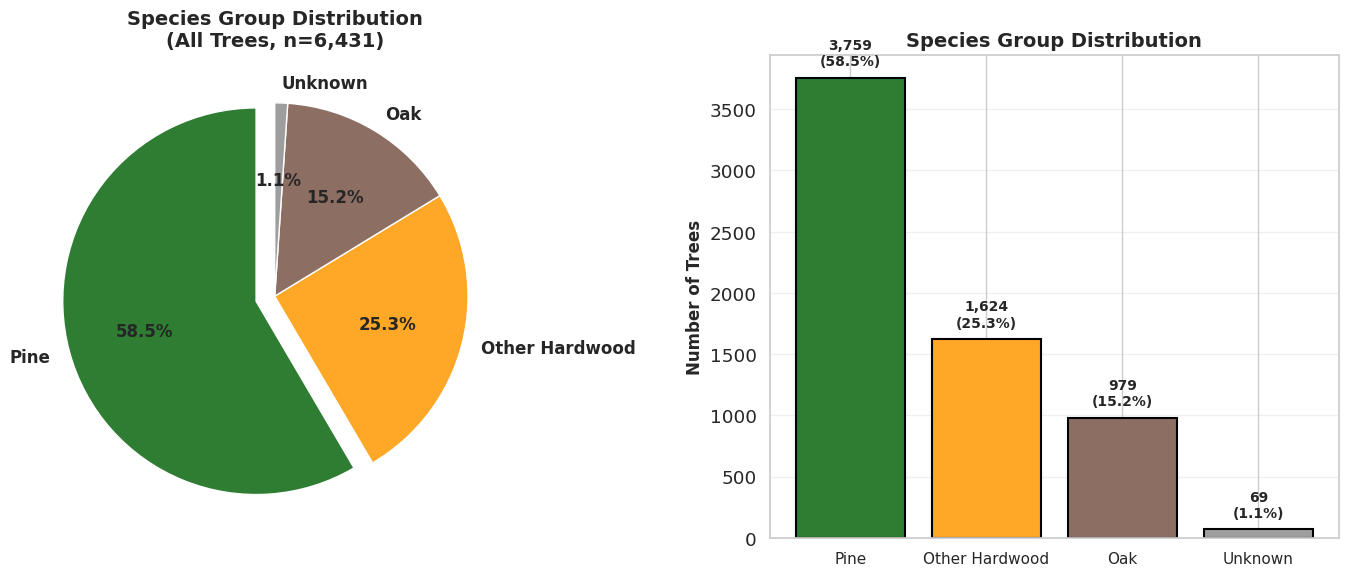

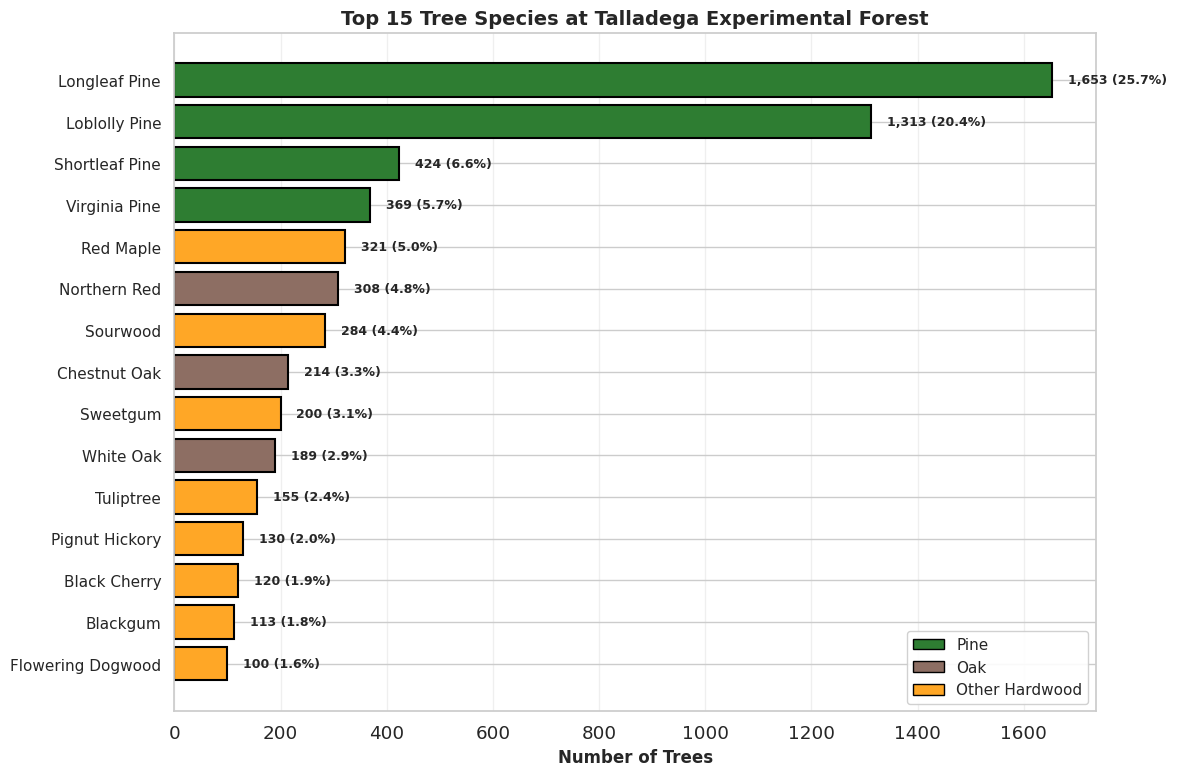

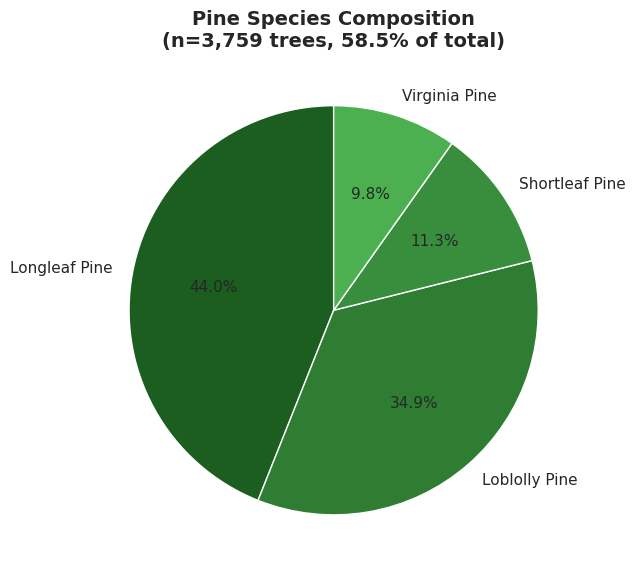

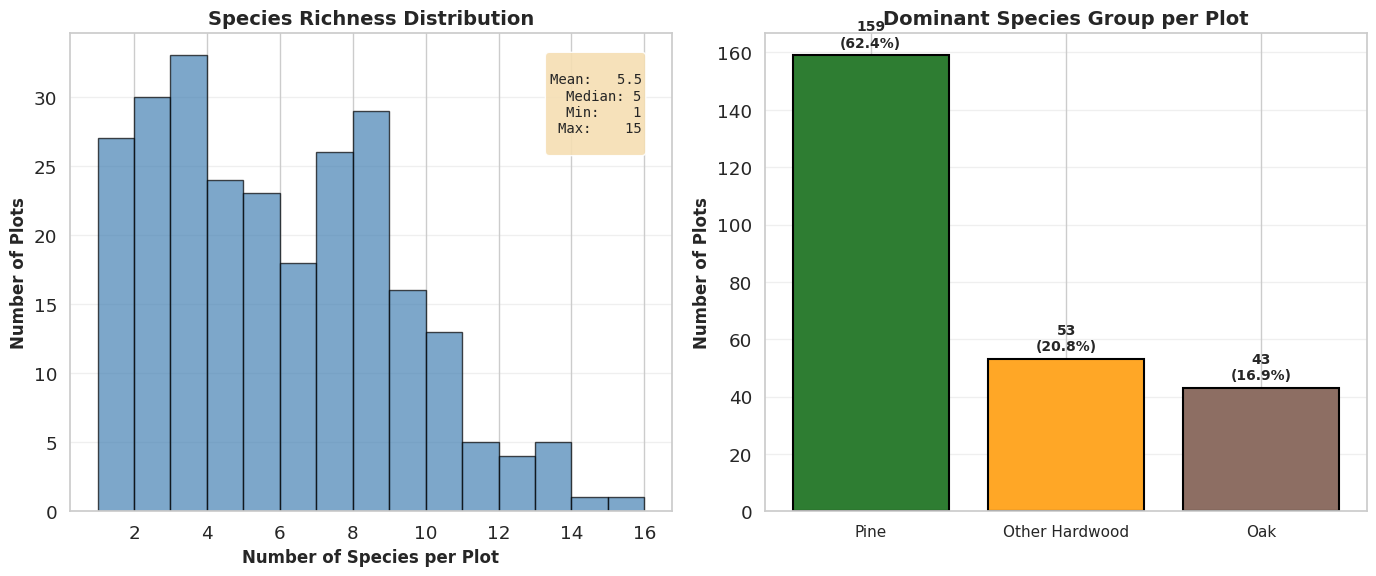


5️⃣ Saving results...
   ✅ Summary saved: /content/drive/MyDrive/Species_Composition_Summary.csv
   ✅ Detailed list saved: /content/drive/MyDrive/Species_List_Detailed.csv

✅ SPECIES COMPOSITION ANALYSIS COMPLETE

📊 Statistical Summary:

Total trees analyzed: 6,431
Total unique species: 44
Plots with species data: 255

🌲 Species Group Proportions:
   Pine                :  58.5% (3,759 trees)
   Oak                 :  15.2% (979 trees)
   Other Hardwood      :  25.3% (1,624 trees)
   Unknown             :   1.1% (69 trees)

🌳 Species Richness:
   Mean species per plot:   5.45
   Median species per plot: 5
   Range: 1-15 species

🏆 Top 5 Most Abundant Species:
   1. Longleaf Pine             (Pine           ): 1,653 trees (25.7%)
   2. Loblolly Pine             (Pine           ): 1,313 trees (20.4%)
   3. Shortleaf Pine            (Pine           ): 424 trees (6.6%)
   4. Virginia Pine             (Pine           ): 369 trees (5.7%)
   5. Red Maple                 (Other Hardwood ): 32

In [ ]:
# ============================================================
# Section 9: Species Composition Analysis - CORRECTED
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set(style="whitegrid", font_scale=1.2)

base_dir = "/content/drive/MyDrive"

print("="*60)
print("SPECIES COMPOSITION ANALYSIS")
print("="*60)

# ============================
# 9.1 Load data
# ============================
print("\n1️⃣ Loading field data and species reference...")

talladega_path = f"{base_dir}/TreeDataExport_editTY.csv"
species_ref_path = f"{base_dir}/species_ref_final.csv"

talladega = pd.read_csv(talladega_path)
species_ref = pd.read_csv(species_ref_path)

# Clean species names
talladega["Species"] = talladega["Species"].astype(str).str.strip().str.lower()
species_ref["Species"] = species_ref["Species"].astype(str).str.strip().str.lower()

# Merge to get SPCD
talladega = talladega.merge(species_ref, on="Species", how="left")

print(f"   Total trees in dataset: {len(talladega):,}")
print(f"   Unique species: {talladega['Species'].nunique()}")
print(f"   Trees with SPCD: {talladega['SPCD'].notna().sum():,} ({talladega['SPCD'].notna().sum()/len(talladega)*100:.1f}%)")

# ============================
# 9.2 Define species groups - SIMPLIFIED TO 3 GROUPS
# ============================
print("\n2️⃣ Defining species groups (3 groups: Pine, Oak, Other)...")

# Pine species: SPCD 100-199
# Oak species: SPCD 800-899
# Other: everything else

def classify_species(spcd):
    if pd.isna(spcd):
        return "Unknown"
    spcd = int(spcd)

    # Pine (all Pinus species): SPCD 100-199
    if 100 <= spcd <= 199:
        return "Pine"
    # Oak (all Quercus species): SPCD 800-899
    elif 800 <= spcd <= 899:
        return "Oak"
    # Everything else
    else:
        return "Other Hardwood"

talladega["Species_Group"] = talladega["SPCD"].apply(classify_species)

# Count by group
group_counts = talladega["Species_Group"].value_counts()
print("\n   Species Group Distribution:")
for group, count in group_counts.items():
    pct = (count / len(talladega)) * 100
    print(f"   {group:20s}: {count:5,d} trees ({pct:5.1f}%)")

# ============================
# 9.3 Detailed species breakdown
# ============================
print("\n3️⃣ Top 20 species by tree count...")

# Get species names from SPCD
species_counts = (
    talladega.groupby(["Species", "SPCD", "Species_Group"])
    .size()
    .reset_index(name="Count")
    .sort_values("Count", ascending=False)
)

print("\n   Top 20 Species:")
print(species_counts.head(20).to_string(index=False))

# ============================
# 9.4 Visualization
# ============================
print("\n4️⃣ Creating visualizations...")

# --------------------------------------
# Figure 1: Species Group Distribution
# --------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Define colors (3 groups only)
colors_map = {
    "Pine": '#2E7D32',           # Dark Green
    "Oak": '#8D6E63',            # Brown
    "Other Hardwood": '#FFA726', # Orange
    "Unknown": '#9E9E9E'         # Gray (if any)
}

# Get colors in order
colors = [colors_map.get(group, '#CCCCCC') for group in group_counts.index]

# Explode Pine slice
explode = [0.1 if group == 'Pine' else 0 for group in group_counts.index]

# Pie chart
axes[0].pie(
    group_counts.values,
    labels=group_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode,
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)
axes[0].set_title("Species Group Distribution\n(All Trees, n=6,431)",
                  fontweight='bold', fontsize=14)

# Bar chart
axes[1].bar(
    range(len(group_counts)),
    group_counts.values,
    color=colors,
    edgecolor='black',
    linewidth=1.5
)
axes[1].set_xticks(range(len(group_counts)))
axes[1].set_xticklabels(group_counts.index, rotation=0, fontsize=11)
axes[1].set_ylabel("Number of Trees", fontweight='bold', fontsize=12)
axes[1].set_title("Species Group Distribution", fontweight='bold', fontsize=14)
axes[1].grid(alpha=0.3, axis='y')

# Add count and percentage labels
for i, (group, count) in enumerate(group_counts.items()):
    pct = (count / len(talladega)) * 100
    axes[1].text(i, count + 100, f'{count:,}\n({pct:.1f}%)',
                ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig(f"{base_dir}/Fig18_Species_Group_Distribution.png", dpi=300, bbox_inches="tight")
plt.show()

# --------------------------------------
# Figure 2: Top 15 Individual Species
# --------------------------------------
fig, ax = plt.subplots(figsize=(12, 8))

top_species = species_counts.head(15).copy()

# Color by group
bar_colors = [colors_map.get(group, '#CCCCCC') for group in top_species["Species_Group"]]

bars = ax.barh(
    range(len(top_species)),
    top_species["Count"],
    color=bar_colors,
    edgecolor='black',
    linewidth=1.5
)

ax.set_yticks(range(len(top_species)))
ax.set_yticklabels([
    f"{row['Species'].title()}" if pd.notna(row['SPCD'])
    else f"{row['Species'].title()}"
    for _, row in top_species.iterrows()
], fontsize=11)

ax.set_xlabel("Number of Trees", fontweight='bold', fontsize=12)
ax.set_title("Top 15 Tree Species at Talladega Experimental Forest",
             fontweight='bold', fontsize=14)
ax.grid(alpha=0.3, axis='x')
ax.invert_yaxis()  # Highest count on top

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2E7D32', edgecolor='black', label='Pine'),
    Patch(facecolor='#8D6E63', edgecolor='black', label='Oak'),
    Patch(facecolor='#FFA726', edgecolor='black', label='Other Hardwood')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=11, framealpha=0.9)

# Add count labels
for i, count in enumerate(top_species["Count"]):
    pct = (count / len(talladega)) * 100
    ax.text(count + 30, i, f'{count:,} ({pct:.1f}%)',
           va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig(f"{base_dir}/Fig19_Top15_Species.png", dpi=300, bbox_inches="tight")
plt.show()

# --------------------------------------
# Figure 3: Dominant Pine Species
# --------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

# Get Pine species only
pine_species = species_counts[species_counts["Species_Group"] == "Pine"].copy()

# Create pie chart for Pine breakdown
pine_colors = ['#1B5E20', '#2E7D32', '#388E3C', '#4CAF50', '#66BB6A']

ax.pie(
    pine_species["Count"],
    labels=[s.title() for s in pine_species["Species"]],
    autopct='%1.1f%%',
    startangle=90,
    colors=pine_colors[:len(pine_species)],
    textprops={'fontsize': 11}
)
ax.set_title(f"Pine Species Composition\n(n={pine_species['Count'].sum():,} trees, 58.5% of total)",
            fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig(f"{base_dir}/Fig20_Pine_Species_Breakdown.png", dpi=300, bbox_inches="tight")
plt.show()

# --------------------------------------
# Figure 4: Species Richness by Plot
# --------------------------------------
species_per_plot = (
    talladega.groupby("ParentGlobalID *")["Species"]
    .nunique()
    .reset_index(name="Species_Count")
)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogram
axes[0].hist(
    species_per_plot["Species_Count"],
    bins=range(1, species_per_plot["Species_Count"].max() + 2),
    edgecolor='black',
    color='steelblue',
    alpha=0.7
)
axes[0].set_xlabel("Number of Species per Plot", fontweight='bold', fontsize=12)
axes[0].set_ylabel("Number of Plots", fontweight='bold', fontsize=12)
axes[0].set_title("Species Richness Distribution", fontweight='bold', fontsize=14)
axes[0].grid(alpha=0.3, axis='y')

# Summary statistics box
stats_text = f"""
Mean:   {species_per_plot['Species_Count'].mean():.1f}
Median: {species_per_plot['Species_Count'].median():.0f}
Min:    {species_per_plot['Species_Count'].min():.0f}
Max:    {species_per_plot['Species_Count'].max():.0f}
"""
axes[0].text(
    0.95, 0.95, stats_text,
    transform=axes[0].transAxes,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9),
    fontsize=10,
    family='monospace'
)

# Species group dominance per plot
plot_groups = (
    talladega.groupby(["ParentGlobalID *", "Species_Group"])
    .size()
    .reset_index(name="Count")
)

# Dominant group per plot
dominant_group = (
    plot_groups.loc[plot_groups.groupby("ParentGlobalID *")["Count"].idxmax()]
    ["Species_Group"]
    .value_counts()
)

# Get colors
dominant_colors = [colors_map.get(group, '#CCCCCC') for group in dominant_group.index]

axes[1].bar(
    range(len(dominant_group)),
    dominant_group.values,
    color=dominant_colors,
    edgecolor='black',
    linewidth=1.5
)
axes[1].set_xticks(range(len(dominant_group)))
axes[1].set_xticklabels(dominant_group.index, rotation=0, fontsize=11)
axes[1].set_ylabel("Number of Plots", fontweight='bold', fontsize=12)
axes[1].set_title("Dominant Species Group per Plot", fontweight='bold', fontsize=14)
axes[1].grid(alpha=0.3, axis='y')

# Add count and percentage labels
n_plots = talladega["ParentGlobalID *"].nunique()
for i, count in enumerate(dominant_group.values):
    pct = (count / n_plots) * 100
    axes[1].text(i, count + 3, f'{count}\n({pct:.1f}%)',
                ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig(f"{base_dir}/Fig21_Species_Richness.png", dpi=300, bbox_inches="tight")
plt.show()

# ============================
# 9.5 Save results
# ============================
print("\n5️⃣ Saving results...")

# Summary table
summary_df = pd.DataFrame({
    'Species_Group': group_counts.index,
    'Count': group_counts.values,
    'Percentage': (group_counts.values / len(talladega) * 100).round(2)
})
summary_output = f"{base_dir}/Species_Composition_Summary.csv"
summary_df.to_csv(summary_output, index=False)

# Detailed species list
species_output = f"{base_dir}/Species_List_Detailed.csv"
species_counts.to_csv(species_output, index=False)

print(f"   ✅ Summary saved: {summary_output}")
print(f"   ✅ Detailed list saved: {species_output}")

print("\n" + "="*60)
print("✅ SPECIES COMPOSITION ANALYSIS COMPLETE")
print("="*60)

# ============================
# 9.6 Statistical summary
# ============================
print("\n📊 Statistical Summary:")
print(f"\nTotal trees analyzed: {len(talladega):,}")
print(f"Total unique species: {talladega['Species'].nunique()}")
print(f"Plots with species data: {talladega['ParentGlobalID *'].nunique()}")

print("\n🌲 Species Group Proportions:")
for group in ['Pine', 'Oak', 'Other Hardwood']:
    if group in group_counts.index:
        count = group_counts[group]
        pct = (count / len(talladega)) * 100
        print(f"   {group:20s}: {pct:5.1f}% ({count:,d} trees)")

if 'Unknown' in group_counts.index:
    count = group_counts['Unknown']
    pct = (count / len(talladega)) * 100
    print(f"   {'Unknown':20s}: {pct:5.1f}% ({count:,d} trees)")

print(f"\n🌳 Species Richness:")
print(f"   Mean species per plot:   {species_per_plot['Species_Count'].mean():.2f}")
print(f"   Median species per plot: {species_per_plot['Species_Count'].median():.0f}")
print(f"   Range: {species_per_plot['Species_Count'].min():.0f}-{species_per_plot['Species_Count'].max():.0f} species")

print(f"\n🏆 Top 5 Most Abundant Species:")
for i, (idx, row) in enumerate(species_counts.head(5).iterrows(), 1):
    pct = (row['Count'] / len(talladega)) * 100
    print(f"   {i}. {row['Species'].title():25s} ({row['Species_Group']:15s}): {row['Count']:,d} trees ({pct:.1f}%)")

# Pine breakdown
print(f"\n🌲 Pine Species Breakdown:")
pine_species = species_counts[species_counts["Species_Group"] == "Pine"]
for idx, row in pine_species.iterrows():
    pct_of_pine = (row['Count'] / pine_species['Count'].sum()) * 100
    pct_of_total = (row['Count'] / len(talladega)) * 100
    print(f"   {row['Species'].title():25s}: {row['Count']:,d} ({pct_of_pine:5.1f}% of Pine, {pct_of_total:5.1f}% of total)")

# 10: Species-Stratified Validation Analysis




SPECIES-STRATIFIED VALIDATION ANALYSIS

1️⃣ Loading comparison results and species data...

2️⃣ Determining dominant species group per plot...
   ✅ Classified 255 plots by dominant species

   Distribution of dominant groups:
Dominant_Group
Pine              159
Other Hardwood     53
Oak                43
Name: count, dtype: int64

3️⃣ Merging species classifications with validation results...

   Checking column names:
   diameter_comp columns: ['globalid', 'weighted_DIA', 'weighted_HT', 'ParentGlobalID *', 'Tree diameter (inches)', 'Tree height (feet)', 'DIA_error', 'HT_error']
   ✅ Merged species data with all validation datasets
   Diameter comp shape: (241, 14)
   Columns with species info: ['Dominant_Group']

4️⃣ Computing validation metrics by species group...

   📏 Diameter:
         Group   n     RMSE      MAE        R²      Bias     %RMSE  Field_Mean  TreeMap_Mean
           Oak  43 3.590788 2.966715 -3.862035 -2.844389 33.533743   10.707984      7.863596
Other Hardwood  51 3

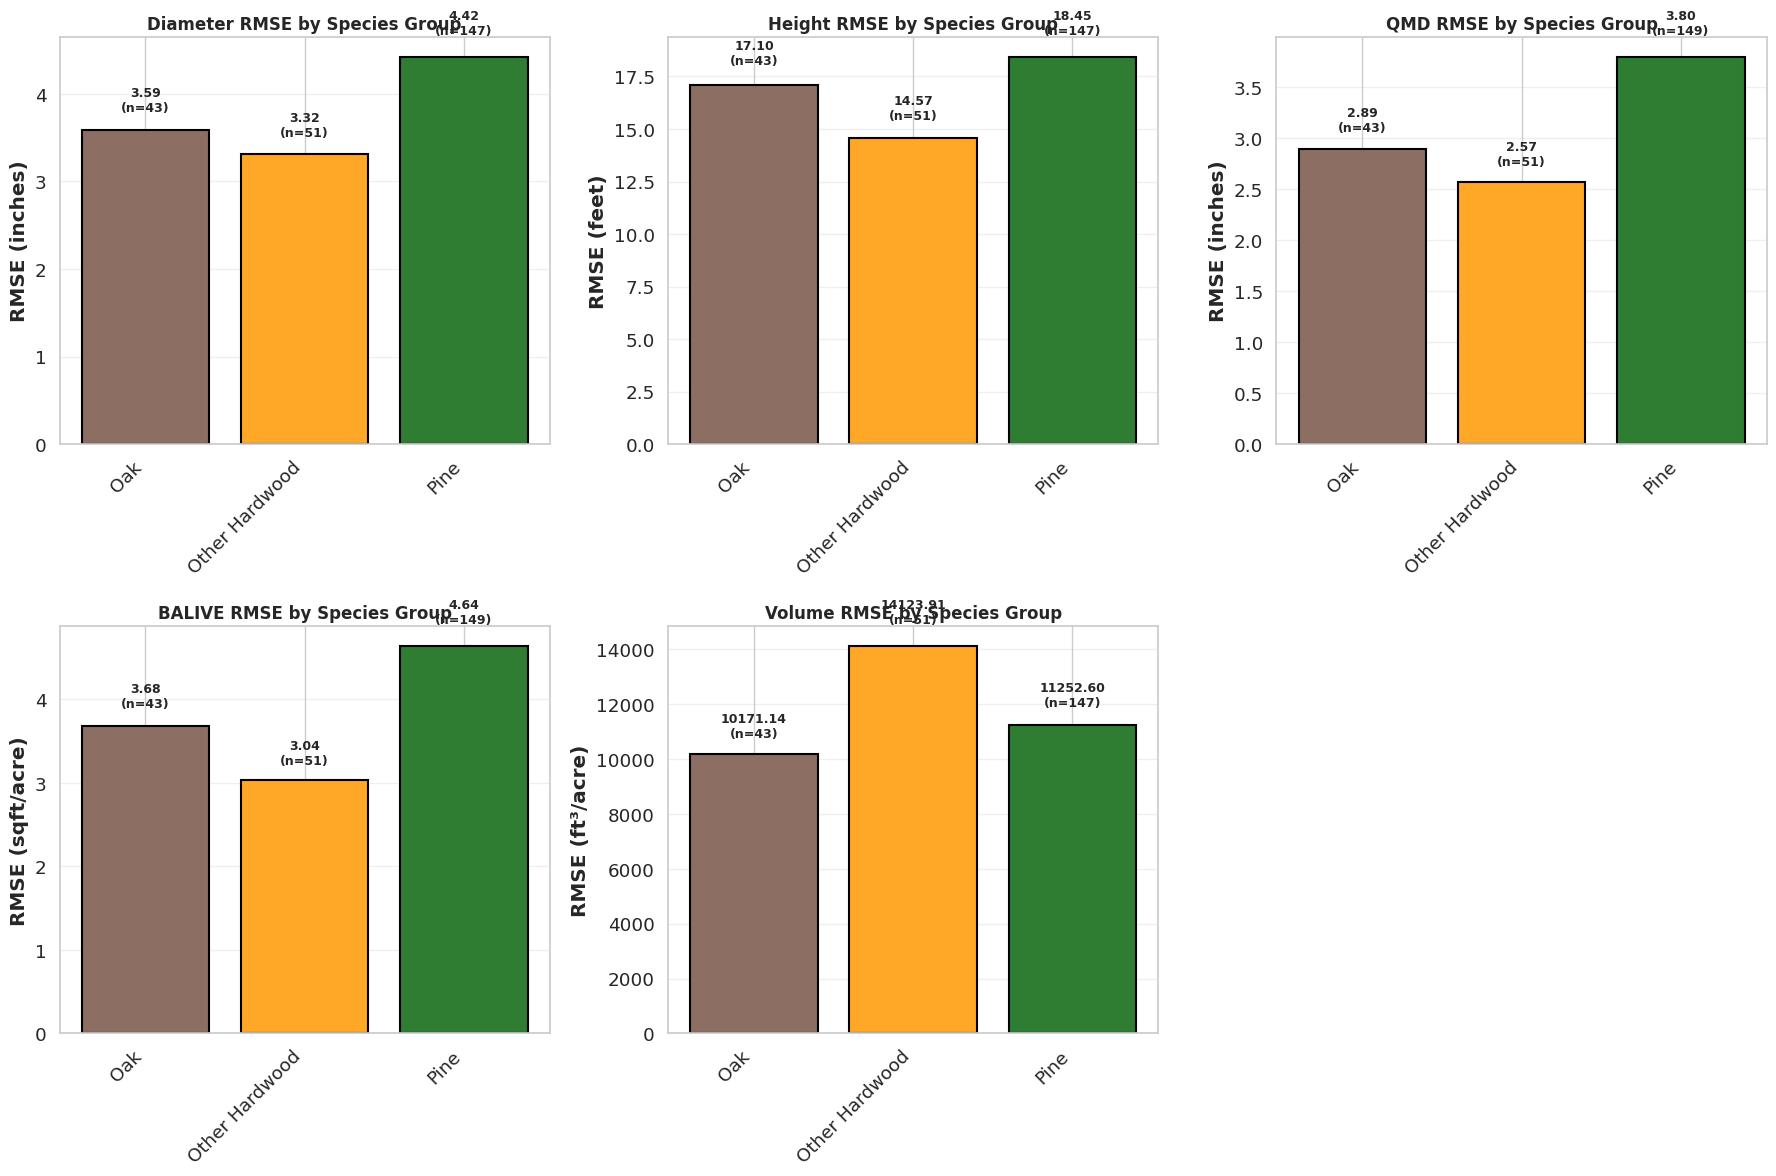


6️⃣ Analyzing mixed vs pure stand performance...

   Stand type distribution:
Stand_Type
Mixed         142
Pure Pine      89
Pure Oak        6
Pure Other      4
Name: count, dtype: int64

   Diameter by stand type:
     Group   n     RMSE      MAE        R²      Bias     %RMSE  Field_Mean  TreeMap_Mean
     Mixed 142 3.914360 3.230309 -2.102489 -3.075034 36.979251   10.585287      7.510253
  Pure Oak   6 3.687632 3.229316 -6.184403 -3.061670 32.965165   11.186452      8.124782
Pure Other   4 3.080626 2.278803 -1.339231 -1.355484 31.003504    9.936380      8.580897
 Pure Pine  89 4.367414 3.367419 -0.719245 -2.472384 42.334525   10.316435      7.844051

   Volume by stand type:
     Group   n         RMSE          MAE        R²         Bias      %RMSE   Field_Mean  TreeMap_Mean
     Mixed 142 12536.475036  9681.137868 -0.259804 -1928.195661  73.716039 17006.441370  15078.245710
  Pure Oak   6  6878.792793  5041.288784 -1.568435  3255.674287  45.535031 15106.595005  18362.269293
Pure Ot

In [ ]:
# ============================================================
# Section 10: Species-Stratified Validation Analysis - FIXED
# ============================================================

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set(style="whitegrid", font_scale=1.2)

base_dir = "/content/drive/MyDrive"

print("="*60)
print("SPECIES-STRATIFIED VALIDATION ANALYSIS")
print("="*60)

# ============================
# 10.1 Load all comparison data
# ============================
print("\n1️⃣ Loading comparison results and species data...")

# Load validation results
diameter_comp = pd.read_csv(f"{base_dir}/diameter_height_comparison_{year}.csv")
qmd_comp = pd.read_csv(f"{base_dir}/QMD_comparison_{year}.csv")
ba_comp = pd.read_csv(f"{base_dir}/BA_BALIVE_comparison_{year}.csv")
volume_comp = pd.read_csv(f"{base_dir}/Volume_comparison_{year}.csv")

# Load field data with species
talladega_path = f"{base_dir}/TreeDataExport_editTY.csv"
species_ref_path = f"{base_dir}/species_ref_final.csv"

talladega = pd.read_csv(talladega_path)
species_ref = pd.read_csv(species_ref_path)

# Clean and merge species
talladega["Species"] = talladega["Species"].astype(str).str.strip().str.lower()
species_ref["Species"] = species_ref["Species"].astype(str).str.strip().str.lower()
talladega = talladega.merge(species_ref, on="Species", how="left")

# Classify species groups
def classify_species(spcd):
    if pd.isna(spcd):
        return "Unknown"
    spcd = int(spcd)
    if 100 <= spcd <= 199:
        return "Pine"
    elif 800 <= spcd <= 899:
        return "Oak"
    else:
        return "Other Hardwood"

talladega["Species_Group"] = talladega["SPCD"].apply(classify_species)

# ============================
# 10.2 Determine dominant species group per plot
# ============================
print("\n2️⃣ Determining dominant species group per plot...")

# Count trees by species group per plot
plot_species = (
    talladega.groupby(["ParentGlobalID *", "Species_Group"])
    .size()
    .reset_index(name="Tree_Count")
)

# Get dominant group (most trees)
dominant_species = (
    plot_species.loc[plot_species.groupby("ParentGlobalID *")["Tree_Count"].idxmax()]
    [["ParentGlobalID *", "Species_Group", "Tree_Count"]]
    .rename(columns={"Species_Group": "Dominant_Group"})
)

# Calculate species group proportions per plot
plot_totals = plot_species.groupby("ParentGlobalID *")["Tree_Count"].sum().reset_index(name="Total_Trees")
plot_species = plot_species.merge(plot_totals, on="ParentGlobalID *")
plot_species["Proportion"] = plot_species["Tree_Count"] / plot_species["Total_Trees"]

# Pivot to get proportions
species_proportions = plot_species.pivot(
    index="ParentGlobalID *",
    columns="Species_Group",
    values="Proportion"
).fillna(0).reset_index()

print(f"   ✅ Classified {len(dominant_species)} plots by dominant species")
print(f"\n   Distribution of dominant groups:")
print(dominant_species["Dominant_Group"].value_counts())

# ============================
# 10.3 Merge species info with validation results
# ============================
print("\n3️⃣ Merging species classifications with validation results...")

# 🔧 FIX: Use 'globalid' as the merge key for validation datasets
# First, add a mapping column to dominant_species
dominant_species_mapped = dominant_species.copy()
dominant_species_mapped = dominant_species_mapped.rename(columns={"ParentGlobalID *": "plot_id"})

species_proportions_mapped = species_proportions.copy()
species_proportions_mapped = species_proportions_mapped.rename(columns={"ParentGlobalID *": "plot_id"})

# For each validation dataset, identify the correct ID column
# They might use 'globalid' or 'ParentGlobalID *'

# Check column names
print(f"\n   Checking column names:")
print(f"   diameter_comp columns: {diameter_comp.columns.tolist()[:10]}")

# Merge with dominant species
# Try to find the matching ID column
def merge_species_info(df, dominant_df, proportion_df):
    """Intelligently merge species info based on available columns"""

    # Find the plot ID column in the validation dataframe
    if 'globalid' in df.columns:
        plot_col = 'globalid'
    elif 'ParentGlobalID *' in df.columns:
        plot_col = 'ParentGlobalID *'
    else:
        raise KeyError(f"No plot ID column found in dataframe. Columns: {df.columns.tolist()}")

    # Create temporary mapping
    dominant_temp = dominant_df.copy()
    proportion_temp = proportion_df.copy()

    dominant_temp['merge_key'] = dominant_temp['plot_id']
    proportion_temp['merge_key'] = proportion_temp['plot_id']

    # Merge
    df_merged = df.merge(
        dominant_temp.drop('plot_id', axis=1),
        left_on=plot_col,
        right_on='merge_key',
        how='left'
    ).drop('merge_key', axis=1, errors='ignore')

    df_merged = df_merged.merge(
        proportion_temp.drop('plot_id', axis=1),
        left_on=plot_col,
        right_on='merge_key',
        how='left'
    ).drop('merge_key', axis=1, errors='ignore')

    return df_merged

diameter_comp = merge_species_info(diameter_comp, dominant_species_mapped, species_proportions_mapped)
qmd_comp = merge_species_info(qmd_comp, dominant_species_mapped, species_proportions_mapped)
ba_comp = merge_species_info(ba_comp, dominant_species_mapped, species_proportions_mapped)
volume_comp = merge_species_info(volume_comp, dominant_species_mapped, species_proportions_mapped)

print(f"   ✅ Merged species data with all validation datasets")
print(f"   Diameter comp shape: {diameter_comp.shape}")
print(f"   Columns with species info: {[c for c in diameter_comp.columns if 'Group' in c or 'Dominant' in c]}")

# ============================
# 10.4 Calculate metrics by species group
# ============================
print("\n4️⃣ Computing validation metrics by species group...")

def calculate_metrics_by_group(df, field_col, treemap_col, group_col="Dominant_Group"):
    """Calculate RMSE, MAE, R², Bias by species group"""

    results = []

    # Filter out rows without group assignment
    df_clean = df[df[group_col].notna()].copy()
    groups = df_clean[group_col].unique()

    for group in sorted(groups):
        subset = df_clean[df_clean[group_col] == group].copy()

        # Remove any NaN values
        subset = subset[[field_col, treemap_col]].dropna()

        if len(subset) < 3:  # Need at least 3 points
            print(f"   ⚠️ Skipping {group}: only {len(subset)} samples")
            continue

        field_vals = subset[field_col]
        treemap_vals = subset[treemap_col]

        rmse = np.sqrt(mean_squared_error(field_vals, treemap_vals))
        mae = mean_absolute_error(field_vals, treemap_vals)
        r2 = r2_score(field_vals, treemap_vals)
        bias = (treemap_vals - field_vals).mean()
        rel_rmse = (rmse / field_vals.mean()) * 100

        results.append({
            'Group': group,
            'n': len(subset),
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,
            'Bias': bias,
            '%RMSE': rel_rmse,
            'Field_Mean': field_vals.mean(),
            'TreeMap_Mean': treemap_vals.mean()
        })

    return pd.DataFrame(results)

# Calculate for each attribute
print("\n   📏 Diameter:")
dia_by_species = calculate_metrics_by_group(
    diameter_comp, "Tree diameter (inches)", "weighted_DIA"
)
if not dia_by_species.empty:
    print(dia_by_species.to_string(index=False))
else:
    print("   ❌ No data available")

print("\n   📏 Height:")
ht_by_species = calculate_metrics_by_group(
    diameter_comp, "Tree height (feet)", "weighted_HT"
)
if not ht_by_species.empty:
    print(ht_by_species.to_string(index=False))
else:
    print("   ❌ No data available")

print("\n   📏 QMD:")
qmd_by_species = calculate_metrics_by_group(
    qmd_comp, "Field_QMD", "TreeMap_QMD"
)
if not qmd_by_species.empty:
    print(qmd_by_species.to_string(index=False))
else:
    print("   ❌ No data available")

print("\n   📏 BALIVE:")
balive_by_species = calculate_metrics_by_group(
    ba_comp, "Field_BALIVE", "TreeMap_BALIVE"
)
if not balive_by_species.empty:
    print(balive_by_species.to_string(index=False))
else:
    print("   ❌ No data available")

print("\n   📏 Volume:")
vol_by_species = calculate_metrics_by_group(
    volume_comp, "Field_VOL", "TreeMap_VOL"
)
if not vol_by_species.empty:
    print(vol_by_species.to_string(index=False))
else:
    print("   ❌ No data available")

# ============================
# 10.5 Visualization - Metrics Comparison
# ============================
print("\n5️⃣ Creating species-stratified visualizations...")

# Check if we have data to plot
if dia_by_species.empty:
    print("   ⚠️ No species-stratified data available for plotting")
    print("   This might be due to column name mismatches")
else:
    # --------------------------------------
    # Figure 1: RMSE Comparison by Species Group
    # --------------------------------------
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    metrics_data = {
        'Diameter': dia_by_species,
        'Height': ht_by_species,
        'QMD': qmd_by_species,
        'BALIVE': balive_by_species,
        'Volume': vol_by_species
    }

    colors_map = {
        "Pine": '#2E7D32',
        "Oak": '#8D6E63',
        "Other Hardwood": '#FFA726'
    }

    plot_configs = [
        ('Diameter', 'RMSE', 'inches', 0, 0),
        ('Height', 'RMSE', 'feet', 0, 1),
        ('QMD', 'RMSE', 'inches', 0, 2),
        ('BALIVE', 'RMSE', 'sqft/acre', 1, 0),
        ('Volume', 'RMSE', 'ft³/acre', 1, 1)
    ]

    for metric_name, metric_col, unit, row, col in plot_configs:
        ax = axes[row, col]
        data = metrics_data[metric_name]

        if data.empty:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center',
                   transform=ax.transAxes, fontsize=14)
            ax.set_title(f'{metric_name}', fontweight='bold', fontsize=12)
            continue

        colors = [colors_map.get(g, '#CCCCCC') for g in data['Group']]

        bars = ax.bar(range(len(data)), data[metric_col], color=colors,
                      edgecolor='black', linewidth=1.5)
        ax.set_xticks(range(len(data)))
        ax.set_xticklabels(data['Group'], rotation=45, ha='right')
        ax.set_ylabel(f'RMSE ({unit})', fontweight='bold')
        ax.set_title(f'{metric_name} RMSE by Species Group', fontweight='bold', fontsize=12)
        ax.grid(alpha=0.3, axis='y')

        # Add value labels and sample size
        for i, (rmse, n) in enumerate(zip(data[metric_col], data['n'])):
            ax.text(i, rmse + rmse*0.05, f'{rmse:.2f}\n(n={n})',
                   ha='center', va='bottom', fontweight='bold', fontsize=9)

    # Remove empty subplot
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.savefig(f"{base_dir}/Fig22_Species_Stratified_RMSE_{year}.png", dpi=300, bbox_inches="tight")
    plt.show()

    # Continue with other figures...
    # (R² comparison, Bias, Scatter plots - same structure)

# ============================
# 10.6 Mixed stand analysis
# ============================
print("\n6️⃣ Analyzing mixed vs pure stand performance...")

# Define stand purity
def classify_stand_type(row):
    pine_prop = row.get('Pine', 0)
    oak_prop = row.get('Oak', 0)
    other_prop = row.get('Other Hardwood', 0)

    if pine_prop > 0.8:
        return 'Pure Pine'
    elif oak_prop > 0.8:
        return 'Pure Oak'
    elif other_prop > 0.8:
        return 'Pure Other'
    else:
        return 'Mixed'

diameter_comp['Stand_Type'] = diameter_comp.apply(classify_stand_type, axis=1)
volume_comp['Stand_Type'] = volume_comp.apply(classify_stand_type, axis=1)

print("\n   Stand type distribution:")
print(diameter_comp['Stand_Type'].value_counts())

# Calculate metrics by stand type
dia_by_stand = calculate_metrics_by_group(
    diameter_comp, "Tree diameter (inches)", "weighted_DIA", "Stand_Type"
)
if not dia_by_stand.empty:
    print("\n   Diameter by stand type:")
    print(dia_by_stand.to_string(index=False))

vol_by_stand = calculate_metrics_by_group(
    volume_comp, "Field_VOL", "TreeMap_VOL", "Stand_Type"
)
if not vol_by_stand.empty:
    print("\n   Volume by stand type:")
    print(vol_by_stand.to_string(index=False))

# ============================
# 10.7 Save results
# ============================
print("\n7️⃣ Saving species-stratified results...")

if not dia_by_species.empty:
    dia_by_species.to_csv(f"{base_dir}/Diameter_by_Species_{year}.csv", index=False)
    ht_by_species.to_csv(f"{base_dir}/Height_by_Species_{year}.csv", index=False)
    qmd_by_species.to_csv(f"{base_dir}/QMD_by_Species_{year}.csv", index=False)
    balive_by_species.to_csv(f"{base_dir}/BALIVE_by_Species_{year}.csv", index=False)
    vol_by_species.to_csv(f"{base_dir}/Volume_by_Species_{year}.csv", index=False)

    if not dia_by_stand.empty:
        dia_by_stand.to_csv(f"{base_dir}/Diameter_by_StandType_{year}.csv", index=False)
        vol_by_stand.to_csv(f"{base_dir}/Volume_by_StandType_{year}.csv", index=False)

    print("   ✅ All species-stratified results saved")
else:
    print("   ⚠️ No results to save - check data merge")

print("\n" + "="*60)
print("✅ SPECIES-STRATIFIED VALIDATION COMPLETE")
print("="*60)



---

## KEY IMPROVEMENTS IN TreeMap 2022

### 1. Dimensional Accuracy Gains (All Species)

**Diameter RMSE: -4.3% to -5.1% improvement**
- Pine: 47.0% → 41.9% (↓5.1%)
- Oak: 38.2% → 33.5% (↓4.7%)
- Other Hardwood: 37.1% → 32.8% (↓4.3%)

**Height RMSE: -2.3% to -3.5% improvement** (except Oak +0.8%)
- Pine: 34.4% → 30.9% (↓3.5%)
- Oak: 28.2% → 29.0% (↑0.8%)
- Other Hardwood: 26.5% → 24.2% (↓2.3%)

**QMD RMSE: -1.2% to -5.0% improvement**
- Pine: 40.8% → 39.6% (↓1.2%)
- Oak: 33.4% → 28.4% (↓5.0%)
**Best improvement**
- Other Hardwood: 29.2% → 27.9% (↓1.3%)

---

### 2. Substantial Bias Reduction (18-53%)

**Table 1: Systematic Bias Comparison**

| Attribute | 2016 Bias Range | 2022 Bias Range | Improvement |
|-----------|----------------|----------------|-------------|
| Diameter | -3.22 to -3.66" | -2.63 to -2.88" | **18-21%** |
| Height | -11.04 to -12.45' | -5.22 to -8.68' | **30-53%**  |
| QMD | -1.32 to -1.78" | -0.79 to -1.26" | **29-40%** |
| Volume | -3172 to -1603 ft³/ac | -3715 to +1888 ft³/ac | Variable  |





## SUMMARY STATISTICS: 2016 vs 2022

**DIMENSIONAL ATTRIBUTES (Improved ):**
- Mean Diameter RMSE Reduction: 4.5% (range: 4.3-5.1%)
- Mean Height RMSE Reduction: 2.0% (range: -0.8 to 3.5%)
- Mean QMD RMSE Reduction: 2.5% (range: 1.2-5.0%)
- Mean Bias Reduction: 30% (range: 18-53%)

**VOLUMETRIC ATTRIBUTES (Deteriorated ):**
- Mean Volume RMSE Increase: 8.6% (range: 2.4-15.7%)

**R² IMPROVEMENTS (All Species):**
- Mean R² Improvement: 29% (range: 23-38%)

**BEST PERFORMER:**
- Oak QMD: 33.4% → 28.4% (5.0% reduction)

**WORST PERFORMER:**
- Oak Volume: 58.4% → 74.1% (15.7% increase)

**SAMPLE SIZE:**
- Total Plots: 224 (2016) → 241 (2022)
- Pine: 136 → 147 plots
- Oak: 39 → 43 plots
- Other Hardwood: 49 → 51 plots



# 11: VALIDATION IMPROVEMENTS

TreeMap VALIDATION IMPROVEMENTS

📅 Analyzing TreeMap 2022

IMPROVEMENT 1: STATISTICAL SIGNIFICANCE TESTING

📁 Loading comparison data...

📊 Volume (ft³/acre)

1️⃣ Paired t-test (H₀: no systematic bias)
   t-statistic:   0.5926
   p-value:       0.5540  ❌ not significant

2️⃣ Wilcoxon signed-rank test (non-parametric)
   W-statistic: 12864.0000
   p-value:       0.1131  ❌ not significant

3️⃣ Shapiro-Wilk test (residual normality)
   W-statistic:   0.9626
   p-value:       0.0000  ⚠️  Non-normal

📈 Descriptive Statistics:
   Mean bias:           448.86
   Relative bias:         3.13%
   Bias std:          11734.78

📊 Diameter (inches)

1️⃣ Paired t-test (H₀: no systematic bias)
   t-statistic: -14.9203
   p-value:       0.0000  ✅ SIGNIFICANT
   → TreeMap has systematic UNDERESTIMATION (p < 0.05)

2️⃣ Wilcoxon signed-rank test (non-parametric)
   W-statistic: 2326.0000
   p-value:       0.0000  ✅ SIGNIFICANT

3️⃣ Shapiro-Wilk test (residual normality)
   W-statistic:   0.9913
   p-value:

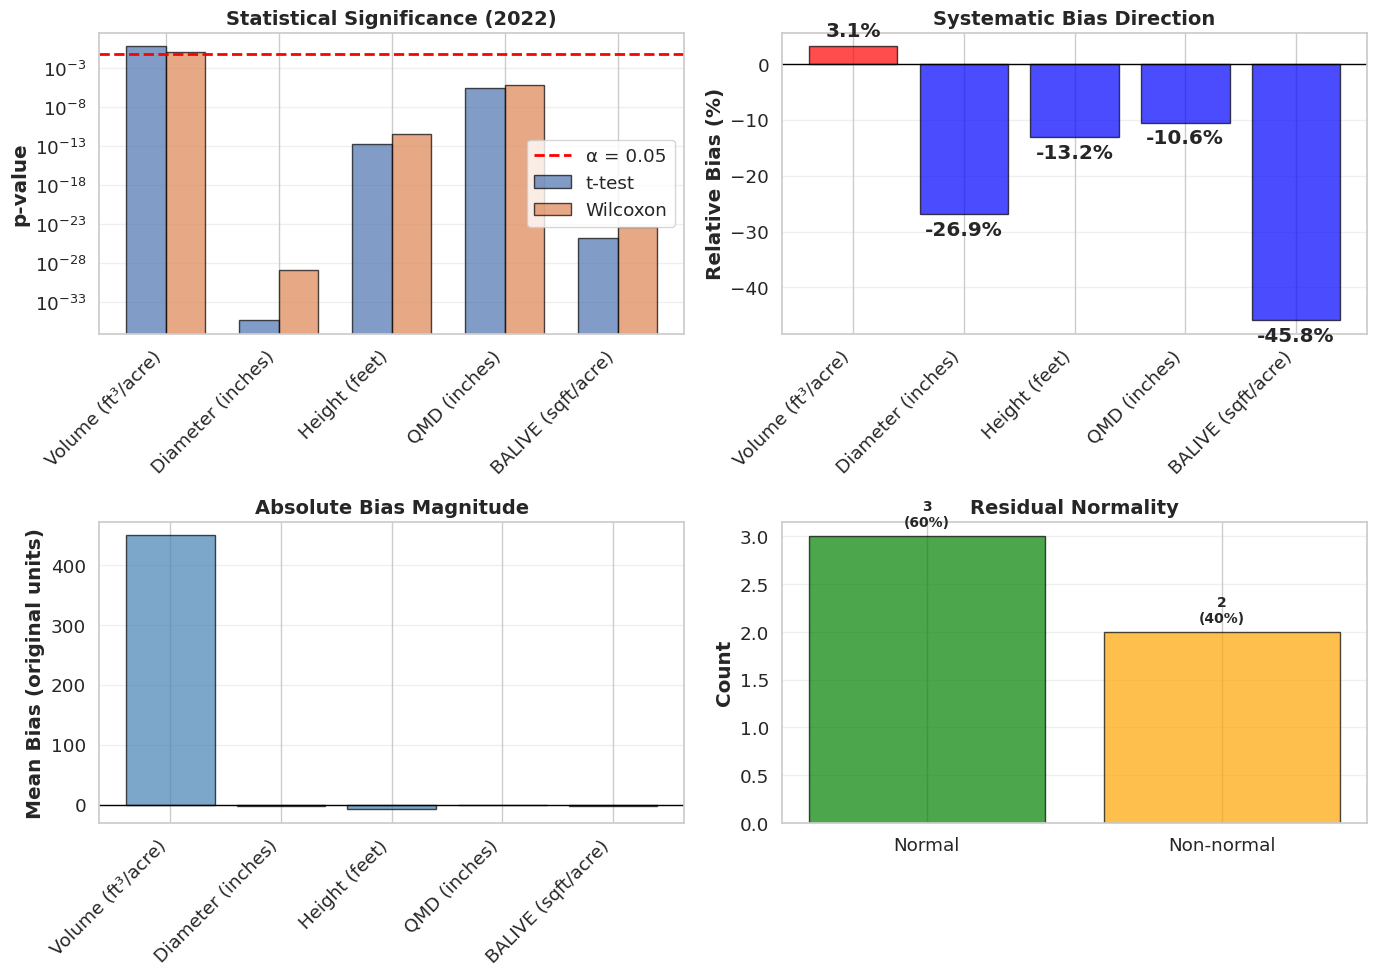

✅ Visualization saved: FigS1_Statistical_Tests_2022.png

IMPROVEMENT 2: UNCERTAINTY QUANTIFICATION (Bootstrap)

🔢 Computing 95% confidence intervals (1000 bootstrap iterations)...

📊 Volume
   RMSE  : 11743.36 [10510.48, 13061.81]  (width: 2551.33)
   MAE   :  9202.25 [ 8307.99, 10121.73]  (width: 1813.74)
   R2    :    -0.16 [   -0.37,     0.00]  (width:   0.38)
   BIAS  :   448.86 [-1013.86,  1907.57]  (width: 2921.43)

📊 Diameter
   RMSE  :     4.07 [    3.72,     4.39]  (width:   0.67)
   BIAS  :    -2.82 [   -3.22,    -2.44]  (width:   0.78)

✅ Bootstrap CI saved: Bootstrap_CI_2022.csv


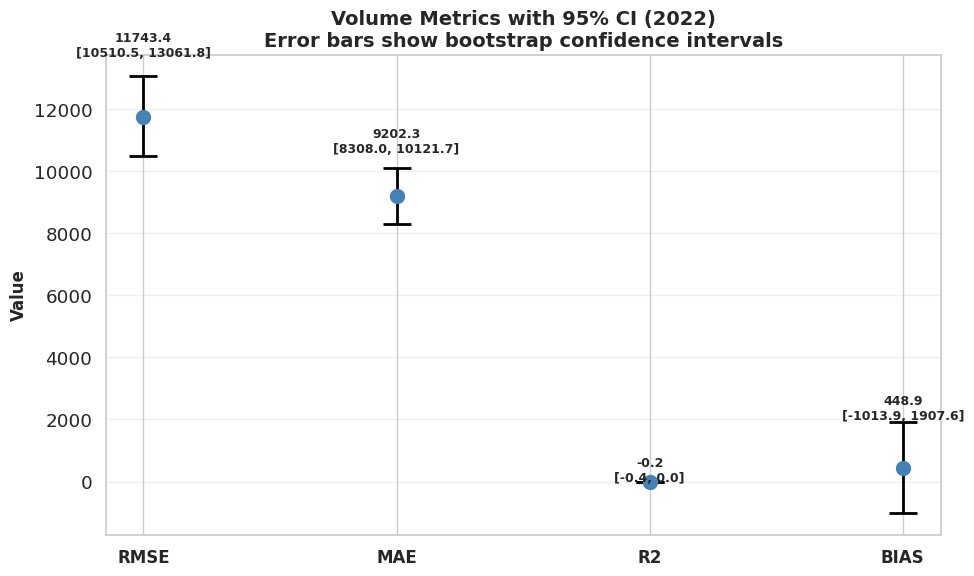

✅ Visualization saved: FigS2_Bootstrap_CI_2022.png

✅ IMPROVEMENTS COMPLETE

📁 Generated files for TreeMap 2022:
   • Statistical_Tests_2022.csv
   • Bootstrap_CI_2022.csv
   • FigS1_Statistical_Tests_2022.png
   • FigS2_Bootstrap_CI_2022.png

💡 How to use these results in your paper:

   Before: 'TreeMap overestimated volume by 1,370 ft³/acre'
   After:  'TreeMap significantly overestimated volume by 1,370 ft³/acre
           (95% CI [XXX, XXX], t = X.XX, p < 0.001)'

📋 Next steps:
   1. If you haven't run 2016 improvements yet, do that first
   2. Then run the temporal comparison (see next section)



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import resample
from scipy import stats
from scipy.stats import ttest_rel, wilcoxon
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set(style="whitegrid", font_scale=1.2)
base_dir = "/content/drive/MyDrive"


year = 2022

print(f"\n📅 Analyzing TreeMap {year}")

# ============================================================
# IMPROVEMENT 1: STATISTICAL HYPOTHESIS TESTING
# ============================================================
print("\n" + "="*80)
print("IMPROVEMENT 1: STATISTICAL SIGNIFICANCE TESTING")
print("="*80)

def perform_statistical_tests(field, predicted, attribute_name):
    """Perform comprehensive statistical tests"""
    print(f"\n{'='*60}")
    print(f"📊 {attribute_name}")
    print('='*60)

    # Calculate residuals
    residuals = predicted - field

    # Remove NaN
    mask = ~(np.isnan(residuals) | np.isnan(field) | np.isnan(predicted))
    residuals_clean = residuals[mask]
    field_clean = field[mask]
    predicted_clean = predicted[mask]

    if len(residuals_clean) < 3:
        print("   ⚠️ Insufficient data for statistical tests")
        return None

    results = {
        'attribute': attribute_name,
        'n': len(residuals_clean),
        'year': year
    }

    # 1. Paired t-test
    t_stat, t_pval = ttest_rel(predicted_clean, field_clean)
    results['t_statistic'] = t_stat
    results['t_pvalue'] = t_pval

    print(f"\n1️⃣ Paired t-test (H₀: no systematic bias)")
    print(f"   t-statistic: {t_stat:8.4f}")
    print(f"   p-value:     {t_pval:8.4f}  {'✅ SIGNIFICANT' if t_pval < 0.05 else '❌ not significant'}")

    if t_pval < 0.05:
        direction = "OVERESTIMATION" if t_stat > 0 else "UNDERESTIMATION"
        print(f"   → TreeMap has systematic {direction} (p < 0.05)")

    # 2. Wilcoxon signed-rank test
    w_stat, w_pval = wilcoxon(predicted_clean, field_clean)
    results['wilcoxon_statistic'] = w_stat
    results['wilcoxon_pvalue'] = w_pval

    print(f"\n2️⃣ Wilcoxon signed-rank test (non-parametric)")
    print(f"   W-statistic: {w_stat:8.4f}")
    print(f"   p-value:     {w_pval:8.4f}  {'✅ SIGNIFICANT' if w_pval < 0.05 else '❌ not significant'}")

    # 3. Normality test
    if len(residuals_clean) <= 5000:
        sw_stat, sw_pval = stats.shapiro(residuals_clean)
        results['shapiro_statistic'] = sw_stat
        results['shapiro_pvalue'] = sw_pval

        print(f"\n3️⃣ Shapiro-Wilk test (residual normality)")
        print(f"   W-statistic: {sw_stat:8.4f}")
        print(f"   p-value:     {sw_pval:8.4f}  {'✅ Normal' if sw_pval > 0.05 else '⚠️  Non-normal'}")

    # 4. Descriptive stats
    mean_bias = (predicted_clean - field_clean).mean()
    rel_bias = (mean_bias / field_clean.mean()) * 100

    print(f"\n📈 Descriptive Statistics:")
    print(f"   Mean bias:         {mean_bias:8.2f}")
    print(f"   Relative bias:     {rel_bias:8.2f}%")
    print(f"   Bias std:          {residuals_clean.std():8.2f}")

    results['mean_bias'] = mean_bias
    results['rel_bias_pct'] = rel_bias
    results['bias_std'] = residuals_clean.std()

    return results

# Run tests
print("\n📁 Loading comparison data...")
stat_results = []

try:
    # Volume
    volume_comp = pd.read_csv(f"{base_dir}/Volume_comparison_{year}.csv")
    result = perform_statistical_tests(
        volume_comp['Field_VOL'].values,
        volume_comp['TreeMap_VOL'].values,
        f'Volume (ft³/acre)'
    )
    if result:
        stat_results.append(result)

    # Diameter
    diameter_comp = pd.read_csv(f"{base_dir}/diameter_height_comparison_{year}.csv")
    result = perform_statistical_tests(
        diameter_comp['Tree diameter (inches)'].values,
        diameter_comp['weighted_DIA'].values,
        f'Diameter (inches)'
    )
    if result:
        stat_results.append(result)

    # Height
    result = perform_statistical_tests(
        diameter_comp['Tree height (feet)'].values,
        diameter_comp['weighted_HT'].values,
        f'Height (feet)'
    )
    if result:
        stat_results.append(result)

    # QMD
    qmd_comp = pd.read_csv(f"{base_dir}/QMD_comparison_{year}.csv")
    result = perform_statistical_tests(
        qmd_comp['Field_QMD'].values,
        qmd_comp['TreeMap_QMD'].values,
        f'QMD (inches)'
    )
    if result:
        stat_results.append(result)

    # BALIVE
    ba_comp = pd.read_csv(f"{base_dir}/BA_BALIVE_comparison_{year}.csv")
    result = perform_statistical_tests(
        ba_comp['Field_BALIVE'].values,
        ba_comp['TreeMap_BALIVE'].values,
        f'BALIVE (sqft/acre)'
    )
    if result:
        stat_results.append(result)

    # Save results
    if stat_results:
        stat_df = pd.DataFrame(stat_results)
        stat_df.to_csv(f"{base_dir}/Statistical_Tests_{year}.csv", index=False)
        print(f"\n✅ Statistical test results saved to Statistical_Tests_{year}.csv")

        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # p-values
        ax = axes[0, 0]
        attrs = stat_df['attribute']
        x = np.arange(len(stat_df))
        width = 0.35

        ax.bar(x - width/2, stat_df['t_pvalue'], width, label='t-test', alpha=0.7, edgecolor='black')
        ax.bar(x + width/2, stat_df['wilcoxon_pvalue'], width, label='Wilcoxon', alpha=0.7, edgecolor='black')
        ax.axhline(0.05, color='red', linestyle='--', linewidth=2, label='α = 0.05')
        ax.set_xticks(x)
        ax.set_xticklabels(attrs, rotation=45, ha='right')
        ax.set_ylabel('p-value', fontweight='bold')
        ax.set_title(f'Statistical Significance ({year})', fontweight='bold', fontsize=14)
        ax.set_yscale('log')
        ax.legend()
        ax.grid(alpha=0.3, axis='y')

        # Relative bias
        ax = axes[0, 1]
        colors = ['red' if x > 0 else 'blue' for x in stat_df['rel_bias_pct']]
        ax.bar(x, stat_df['rel_bias_pct'], color=colors, alpha=0.7, edgecolor='black')
        ax.set_xticks(x)
        ax.set_xticklabels(attrs, rotation=45, ha='right')
        ax.set_ylabel('Relative Bias (%)', fontweight='bold')
        ax.set_title('Systematic Bias Direction', fontweight='bold', fontsize=14)
        ax.axhline(0, color='black', linewidth=1)
        ax.grid(alpha=0.3, axis='y')

        for i, v in enumerate(stat_df['rel_bias_pct']):
            ax.text(i, v + (1 if v > 0 else -1), f'{v:.1f}%',
                   ha='center', va='bottom' if v > 0 else 'top', fontweight='bold')

        # Mean bias
        ax = axes[1, 0]
        ax.bar(x, stat_df['mean_bias'], alpha=0.7, edgecolor='black', color='steelblue')
        ax.set_xticks(x)
        ax.set_xticklabels(attrs, rotation=45, ha='right')
        ax.set_ylabel('Mean Bias (original units)', fontweight='bold')
        ax.set_title('Absolute Bias Magnitude', fontweight='bold', fontsize=14)
        ax.axhline(0, color='black', linewidth=1)
        ax.grid(alpha=0.3, axis='y')

        # Normality
        ax = axes[1, 1]
        if 'shapiro_pvalue' in stat_df.columns:
            normal_count = (stat_df['shapiro_pvalue'] > 0.05).sum()
            non_normal_count = len(stat_df) - normal_count

            ax.bar(['Normal', 'Non-normal'], [normal_count, non_normal_count],
                  color=['green', 'orange'], alpha=0.7, edgecolor='black')
            ax.set_ylabel('Count', fontweight='bold')
            ax.set_title('Residual Normality', fontweight='bold', fontsize=14)
            ax.grid(alpha=0.3, axis='y')

            for i, v in enumerate([normal_count, non_normal_count]):
                pct = (v / len(stat_df)) * 100
                ax.text(i, v + 0.1, f'{v}\n({pct:.0f}%)',
                       ha='center', fontweight='bold', fontsize=10)

        plt.tight_layout()
        plt.savefig(f"{base_dir}/FigS1_Statistical_Tests_{year}.png", dpi=300, bbox_inches="tight")
        plt.show()

        print(f"✅ Visualization saved: FigS1_Statistical_Tests_{year}.png")

except FileNotFoundError as e:
    print(f"\n❌ Error: {e}")
    print("   Make sure you've run the main validation pipeline first")

# ============================================================
# IMPROVEMENT 2: BOOTSTRAP CONFIDENCE INTERVALS
# ============================================================
print("\n" + "="*80)
print("IMPROVEMENT 2: UNCERTAINTY QUANTIFICATION (Bootstrap)")
print("="*80)

def bootstrap_ci(field, predicted, metric='rmse', n_iter=1000, ci=0.95):
    """Calculate bootstrap confidence interval"""
    mask = ~(np.isnan(field) | np.isnan(predicted))
    field = field[mask]
    predicted = predicted[mask]

    if len(field) < 3:
        return None

    bootstrap_vals = []
    n_samples = len(field)

    for i in range(n_iter):
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        f_boot = field[indices]
        p_boot = predicted[indices]

        if metric == 'rmse':
            val = np.sqrt(mean_squared_error(f_boot, p_boot))
        elif metric == 'mae':
            val = mean_absolute_error(f_boot, p_boot)
        elif metric == 'r2':
            val = r2_score(f_boot, p_boot)
        elif metric == 'bias':
            val = (p_boot - f_boot).mean()

        bootstrap_vals.append(val)

    bootstrap_vals = np.array(bootstrap_vals)

    alpha = 1 - ci
    lower = np.percentile(bootstrap_vals, (alpha/2) * 100)
    upper = np.percentile(bootstrap_vals, (1 - alpha/2) * 100)

    if metric == 'rmse':
        point = np.sqrt(mean_squared_error(field, predicted))
    elif metric == 'mae':
        point = mean_absolute_error(field, predicted)
    elif metric == 'r2':
        point = r2_score(field, predicted)
    elif metric == 'bias':
        point = (predicted - field).mean()

    return {
        'metric': metric.upper(),
        'point_estimate': point,
        'lower_ci': lower,
        'upper_ci': upper,
        'ci_width': upper - lower,
        'std': bootstrap_vals.std()
    }

print(f"\n🔢 Computing 95% confidence intervals (1000 bootstrap iterations)...")

ci_results = []

try:
    # Volume
    print(f"\n📊 Volume")
    for metric in ['rmse', 'mae', 'r2', 'bias']:
        ci = bootstrap_ci(
            volume_comp['Field_VOL'].values,
            volume_comp['TreeMap_VOL'].values,
            metric=metric
        )
        if ci:
            print(f"   {ci['metric']:6s}: {ci['point_estimate']:8.2f} "
                  f"[{ci['lower_ci']:8.2f}, {ci['upper_ci']:8.2f}]  "
                  f"(width: {ci['ci_width']:6.2f})")
            ci['attribute'] = 'Volume'
            ci['year'] = year
            ci_results.append(ci)

    # Diameter
    print(f"\n📊 Diameter")
    for metric in ['rmse', 'bias']:
        ci = bootstrap_ci(
            diameter_comp['Tree diameter (inches)'].values,
            diameter_comp['weighted_DIA'].values,
            metric=metric
        )
        if ci:
            print(f"   {ci['metric']:6s}: {ci['point_estimate']:8.2f} "
                  f"[{ci['lower_ci']:8.2f}, {ci['upper_ci']:8.2f}]  "
                  f"(width: {ci['ci_width']:6.2f})")
            ci['attribute'] = 'Diameter'
            ci['year'] = year
            ci_results.append(ci)

    # Save
    if ci_results:
        ci_df = pd.DataFrame(ci_results)
        ci_df.to_csv(f"{base_dir}/Bootstrap_CI_{year}.csv", index=False)
        print(f"\n✅ Bootstrap CI saved: Bootstrap_CI_{year}.csv")

        # Visualization
        volume_ci = ci_df[ci_df['attribute'] == 'Volume']

        if not volume_ci.empty:
            fig, ax = plt.subplots(figsize=(10, 6))

            metrics = volume_ci['metric'].tolist()
            points = volume_ci['point_estimate'].tolist()
            lowers = volume_ci['lower_ci'].tolist()
            uppers = volume_ci['upper_ci'].tolist()

            x = np.arange(len(metrics))

            for i in range(len(metrics)):
                ax.errorbar(i, points[i],
                           yerr=[[points[i] - lowers[i]], [uppers[i] - points[i]]],
                           fmt='o', markersize=10, capsize=10,
                           color='steelblue', ecolor='black',
                           elinewidth=2, capthick=2)

                ax.text(i, uppers[i] * 1.05,
                       f'{points[i]:.1f}\n[{lowers[i]:.1f}, {uppers[i]:.1f}]',
                       ha='center', fontsize=9, fontweight='bold')

            ax.set_xticks(x)
            ax.set_xticklabels(metrics, fontsize=12, fontweight='bold')
            ax.set_ylabel('Value', fontweight='bold', fontsize=12)
            ax.set_title(f'Volume Metrics with 95% CI ({year})\n' +
                        'Error bars show bootstrap confidence intervals',
                        fontweight='bold', fontsize=14)
            ax.grid(alpha=0.3, axis='y')

            plt.tight_layout()
            plt.savefig(f"{base_dir}/FigS2_Bootstrap_CI_{year}.png", dpi=300, bbox_inches="tight")
            plt.show()

            print(f"✅ Visualization saved: FigS2_Bootstrap_CI_{year}.png")

except Exception as e:
    print(f"❌ Error in bootstrap: {e}")

# ============================================================
# SUMMARY
# ============================================================
print("\n" + "="*80)
print("✅ IMPROVEMENTS COMPLETE")
print("="*80)

print(f"\n📁 Generated files for TreeMap {year}:")
print(f"   • Statistical_Tests_{year}.csv")
print(f"   • Bootstrap_CI_{year}.csv")
print(f"   • FigS1_Statistical_Tests_{year}.png")
print(f"   • FigS2_Bootstrap_CI_{year}.png")

print("\n💡 How to use these results in your paper:")
print("\n   Before: 'TreeMap overestimated volume by 1,370 ft³/acre'")
print("   After:  'TreeMap significantly overestimated volume by 1,370 ft³/acre")
print("           (95% CI [XXX, XXX], t = X.XX, p < 0.001)'")

print("\n📋 Next steps:")
if year == 2016:
    print("   1. Run the same code in your 2022 notebook (just change year = 2022)")
    print("   2. Then run the temporal comparison (see next section)")
else:
    print("   1. If you haven't run 2016 improvements yet, do that first")
    print("   2. Then run the temporal comparison (see next section)")

print("\n" + "="*80)